In [1]:
from math import floor
import pandas as pd
import numpy as np
import h5py
import matplotlib.pylab as plt
import os
import librosa
import librosa.display
import datetime
import pickle
import ctypes
from datetime import datetime
from scipy import stats
import glob
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import random
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import pearsonr
import glob

In [2]:
#FUNCTIONS
def get_linearity(transitions):
    firsts = transitions[:, 0]
    unique_types = np.unique(firsts)
    string_t = []
    for t in transitions:
        string_t.append(t[0] + t[1])
    unique_transitions = np.unique(string_t)
    #unique_transitions = np.unique(transitions, axis=0)
    #print(unique_transitions)
    return len(unique_types) / len(unique_transitions)

def get_consistency(transitions, times):
    common_transitions = get_common_transitions(transitions)
    common_counts = 0
    non_common_times = []
    for i, transition in enumerate(transitions):
        #print(transition, common_transitions)
        if any(np.array_equal(common, transition) for common in common_transitions):
            common_counts += 1
        else:
            non_common_times.append(times[i])
    return common_counts / len(transitions), non_common_times

def get_common_transitions(transitions):
    firsts = transitions[:,0]
    unique_types = np.unique(firsts)
    common_transitions = []
    for type in unique_types:
        current_transitions = []
        for i, transition in enumerate(transitions):
            if firsts[i] == type:
                current_transitions.append(list(transition))
        #print("current transitions: ", current_transitions)
        if len(current_transitions) > 0:
            unique, counts = np.unique(current_transitions, axis=0, return_counts=True)
            max_ind = np.argmax(counts)
            common_transitions.append(list(unique[max_ind]))
    return common_transitions

def get_consistency_with_commons(transitions, times, common_transitions):
    common_counts = 0
    non_common_times = []
    for i, transition in enumerate(transitions):
        #print(transition, common_transitions)
        if any(np.array_equal(common, transition) for common in common_transitions):
            common_counts += 1
        else:
            non_common_times.append(times[i])
    return common_counts / len(transitions), non_common_times

def get_rolling_linearity(types, times, cluster_size):
    lins = []
    new_times = []
    for i, time in enumerate(times):
        half_cluster = int(cluster_size / 2)
        if i > half_cluster and i < len(types) - 1 - half_cluster:
            center = time + 0.001
            transitions = get_valid_transitions_around_a_time(types, times, center, cluster_size)
            if transitions is not None:
                lin = get_linearity(transitions)
                lins.append(lin)
                new_times.append(time)
    return lins, new_times

def get_rolling_consistency(types, times, cluster_size):
    cons = []
    new_times = []
    for i, time in enumerate(times):
        half_cluster = int(cluster_size / 2)
        if i > half_cluster and i < len(types) - 1 - half_cluster:
            center = time + 0.001
            transitions = get_valid_transitions_around_a_time(types, times, center, cluster_size)
            if transitions is not None:
                con = get_consistency(transitions)
                cons.append(con)
                new_times.append(times[i])
    return cons, new_times

def get_valid_transitions(types, times, nsk, psk):
    transitions = []
    new_times = []
    for i, time in enumerate(times):
        if i < len(times) - 1:
            if times[i + 1] - time < 10 and nsk[i] == 1 and psk[i+1] == 1:
                transitions.append([types[i], types[i+1]])
                new_times.append(time)
    return np.array(transitions), np.array(new_times)

def get_valid_transitions_around_a_time(types, times, center, cluster_size):
    half_cluster = int(cluster_size/2)
    #print("half_cluster: ", half_cluster)
    center_index = 0
    for i, time in enumerate(times):
        if time > center:
            center_index = i - 1
            break
    #print("center index: ", center_index)
    if center_index < half_cluster:
        print("not enough times before center")
        return
    if center_index > len(types) - half_cluster:
        print("not enough times after center")
        return
    first_half_types = types[:center_index]
    first_half_times = times[:center_index]
    for i in range(center_index):
        first_transitions, first_transition_times = get_valid_transitions(types[center_index - half_cluster - i:center_index + 1], times[center_index - half_cluster - i:center_index + 1])
        if len(first_transitions) >= half_cluster:
            break
    else:
        #print("not enough past transitions...stopping")
        return
    if cluster_size % 2 != 0:
        half_cluster += 1
        print("new half cluster: ", half_cluster)
    for i in range(len(types) - center_index):
        second_transitions, second_transition_times = get_valid_transitions(types[center_index + 1: center_index + 1 + half_cluster + i], times[center_index + 1: center_index + 1 + half_cluster + i])
        if len(second_transitions) >= half_cluster:
            break
    else:
        #print("not enough future transitions...stopping.")
        return
    #print("SUCCESSFUL")
    return np.concatenate((first_transitions, second_transitions), axis=0)



def get_sec(time_str):
    """Get seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + float(s)

def find_index_of_closest_time(times1, times2):
    time_indices = []
    for time in times1:
        for i, time2 in enumerate(times2):
            if time2 > time:
                if i == 0:
                    if abs(time2 - time) < 10:
                        time_indices.append(i)
                    else:
                        time_indices.append(np.nan)
                    break
                early_diff = abs(times2[i-1] - time)
                late_diff = abs(time2 - time)
                if min(early_diff, late_diff) < 10:
                    if early_diff < late_diff:
                        time_indices.append(i - 1)
                    else:
                        time_indices.append(i)
                else:
                    time_indices.append(np.nan)
                break
        else:
            if time - time2 < 10:
                time_indices.append(i)
            else:
                time_indices.append(np.nan)
    return time_indices

def add_con_and_lin_for_bird(df, bird, syntax_window):    
    bird_df = df[df['BirdID'] == bird]
    filtered_df = bird_df[bird_df['ID'].notna()]
    filtered_df = filtered_df[filtered_df['Next'].notna()]
    filtered_df = filtered_df[filtered_df['nsk']==1]
    current = filtered_df['ID'].to_numpy()
    next = filtered_df['Next'].to_numpy()
    times = filtered_df['RecA Time'].to_numpy()
    print(len(current), len(next))
    transitions = np.column_stack((current, next))
    nsk = filtered_df['nsk'].to_numpy()
    psk = filtered_df['psk'].to_numpy()
    count = 0
    print(len(filtered_df))
    all_consistency, all_non_common_times = get_consistency(transitions, times)
    global_common_transitions = get_common_transitions(transitions)
    for i, row in filtered_df.iterrows():
        if row['RecA Time'] in all_non_common_times:
            df.loc[i, 'NonCom'] = 1
        else:
            df.loc[i, 'NonCom'] = 0
        if count >= syntax_window:
            consistency, non_common_times = get_consistency(transitions[count-syntax_window:count], times[count-syntax_window:count])
            global_consistency, non_common_times = get_consistency_with_commons(transitions[count-syntax_window:count], times[count-syntax_window:count], global_common_transitions)
            linearity = get_linearity(transitions[count-syntax_window:count])
            df.loc[i, 'Cur Consistency'] = consistency
            df.loc[i, 'Linearity'] = linearity
            df.loc[i, 'Gl Consistency'] = global_consistency
        count += 1
        if count % 100 == 0:
            print(count)
    return df

def add_future_con_and_lin_for_bird(df, bird, syntax_window):    
    filtered_df = df[df['BirdID'] == bird]
    filtered_df = filtered_df[filtered_df['Next'].notna()]
    filtered_df = filtered_df[filtered_df['ID'].notna()]
    current = filtered_df['ID'].to_numpy()
    next = filtered_df['Next'].to_numpy()
    times = filtered_df['RecA Time'].to_numpy()
    print(len(current), len(next))
    transitions = np.column_stack((current, next))

    # for t in transitions:
    #     print(t)
    count = 0
    print(len(filtered_df))
    all_consistency, all_non_common_times = get_consistency(transitions, times)
    global_common_transitions = get_common_transitions(transitions)
    for i, row in filtered_df.iterrows():
        if row['RecA Time'] in all_non_common_times:
            df.loc[i, 'NonCom'] = 1
        else:
            df.loc[i, 'NonCom'] = 0
        if count < len(transitions) - syntax_window:
            consistency, non_common_times = get_consistency(transitions[count:count + syntax_window], times[count:count + syntax_window])
            global_consistency, non_common_times = get_consistency_with_commons(transitions[count:count + syntax_window], times[count:count + syntax_window], global_common_transitions)
            linearity = get_linearity(transitions[count:count + syntax_window])
            df.loc[i, 'F Consistency'] = consistency
            df.loc[i, 'F Linearity'] = linearity
            df.loc[i, 'F Gl Consistency'] = global_consistency
        count += 1
        if count % 100 == 0:
            print(count)
    return df

def add_time_since_last_song(big_df, birdname):
    last_song_index = -1
    for i, row in big_df.iterrows():
        if row['BirdID'] == birdname:
            if last_song_index >= 0 and (row['RecA Time'] - big_df.loc[last_song_index, 'RecA Time'] < 10):
                big_df.loc[i, 'tsl'] = row['RecA Time'] - big_df.loc[last_song_index, 'RecA Time']
            last_song_index = i
    return big_df

def add_distance_to_bird(df, bird1, bird2):
    #bird2 is the first bird, bird1 is the bird who is responding and who distance is measured from
    for i, row in df.iterrows():
        if row['BirdID'] == bird2 and (isinstance(row['Valid Location'], list) or isinstance(row['Valid Location'], np.ndarray)):
            for j in range(i + 1, len(df)):
                if df.loc[j, 'RecA Time'] - row['RecA Time'] > 20:
                    break
                if df.loc[j, 'BirdID'] == bird2 and (isinstance(df.loc[j, 'Valid Location'], list) or isinstance(df.loc[j, 'Valid Location'], np.ndarray)):
                    break
                if df.loc[j, 'BirdID'] == bird1 and (isinstance(df.loc[j, 'Valid Location'], list) or isinstance(df.loc[j, 'Valid Location'], np.ndarray)):
                    #print('doing it')
                    loc1 = row['Valid Location']
                    loc2 = df.loc[j, 'Valid Location']
                    #print(loc1, loc2)
                    dist = ((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)**.5
                    df.loc[j, 'dist to ' + bird2] = dist
    return df

def add_distance_to_mean_bird(df, bird1, bird2):
    other_bird_locs = df[(df['BirdID'] == bird2) & (df['Valid Location'].notnull())]['Valid Location'].to_numpy()
    other_bird_locs = np.stack( other_bird_locs, axis=0 )
    mean_loc = np.nanmean(other_bird_locs, axis=0)
    for i, row in df.iterrows():
        if df.loc[i, 'BirdID'] == bird1 and (isinstance(df.loc[i, 'Valid Location'], list) or isinstance(df.loc[i, 'Valid Location'], np.ndarray)):
            loc2 = df.loc[i, 'Valid Location']
            dist = ((mean_loc[0] - loc2[0])**2 + (mean_loc[1] - loc2[1])**2)**.5
            df.loc[i, bird1 + ' dist to ' + bird2 + ' center'] = dist
    return df


def add_transitions_to_bird(df, bird):
    for i, row in df.iterrows():
        if i == len(df) - 1:
            df.loc[i, 'Next'] = None
            break
        if row['BirdID'] == bird and isinstance(row['ID'], str):
            for j in range(i + 1, len(df)):
                if df.loc[j, 'RecA Time'] - row['RecA Time'] > 10:
                    df.loc[i, 'Next'] = None
                    break
                if df.loc[j, 'BirdID'] == bird:
                    df.loc[i,'Next'] = df.loc[j, 'ID']
                    break
    return df

def plot_noncom_vs_distance(big_df):

#GET VALUES FOR PLOTTING
    
    times_arr = []
    cons_arr = []
    song_rates = []
    noncoms_arr = []
    dist = big_df[big_df['BirdID'] == birds[0]]['dist to ' + birds[1]].to_numpy()
    dist_times = big_df[big_df['BirdID'] == birds[0]]['RecA Time'].to_numpy()
    for bird in birds[:2]:
        # if bird == 'BBF8':
        #     continue
        tsl = big_df[big_df['BirdID'] == bird]['tsl'].to_numpy()
        song_rates.append(np.nanmean(tsl))
        cons = big_df[big_df['BirdID'] == bird]['Consistency'].to_numpy()
        times = big_df[big_df['BirdID'] == bird]['RecA Time'].to_numpy()
        noncoms = big_df[big_df['BirdID'] == bird]['NonCom'].to_numpy()
        times_arr.append(times)
        cons_arr.append(cons)
        noncoms_arr.append(noncoms)

    colors = ['blue', 'orange', 'green']
    fig = plt.figure(figsize=(15,7))
    
    valid_times = []
    for i, cons in enumerate(cons_arr):
        for j, con in enumerate(cons):
            if np.isnan(con):
                continue
            else:
                valid_times.append(times_arr[i][j])
    timemax = np.max(valid_times)
    print("timemax: ", timemax)
    
    timemin = np.min(valid_times)
    print("timemin: ", timemin)
    
    normdist = (dist - np.nanmin(dist)) / (np.nanmax(dist) - np.nanmin(dist))
#PLOTTING
    fig, axs = plt.subplots(len(birds), 1, figsize=(15,7), sharex=True)
    bird_string = ''
    for b, bird in enumerate(birds):
        if b == 0:
            bird_string += bird
        else:
            bird_string += f", {bird}"
    fig.suptitle(f'Uncommon Transitions vs Distance for {bird_string} on {date}', fontsize=16)

    for i, times in enumerate(times_arr):
        lines = []
        line2 = axs.reshape(-1)[i].scatter(dist_times, normdist, s=10, alpha=0.5, c=colors[2], marker='o', label=f"dist btw {birds[0]} & {birds[1]}")
        for t, time in enumerate(times):
            if noncoms_arr[i][t] ==1:
                line = axs.reshape(-1)[i].axvline(x = time, color = 'blue', alpha=0.2, label=f"{birds[i]} Uncommon Transition")
            else:
                line1 = axs.reshape(-1)[i].axvline(x = time, color = 'orange', alpha=0.2, label=f"{birds[i]} Common Transition")
        lines.append(line)
        lines.append(line1)
        lines.append(line2)
        axs.reshape(-1)[i].set_ylabel('Normalized Distance')
        
        axs.reshape(-1)[i].legend(handles = lines)
    axs.reshape(-1)[-1].set_xlabel('Time (s)')
    plt.xlim([timemin, timemax])
    plt.savefig(f'Uncommon-Transitions-vs-dist-{birds[0]}_{birds[1]}_{date}.png')
    plt.show()
    plt.close()

def plot_consistency_vs_distance(big_df, syntax_window):

#GET VALUES FOR PLOTTING
    
    times_arr = []
    cons_arr = []
    song_rates = []
    noncoms_arr = []
    dist = big_df[big_df['BirdID'] == birds[0]]['dist to ' + birds[1]].to_numpy()
    dist_times = big_df[big_df['BirdID'] == birds[0]]['RecA Time'].to_numpy()
    for bird in birds[:2]:
        # if bird == 'BBF8':
        #     continue
        tsl = big_df[big_df['BirdID'] == bird]['tsl'].to_numpy()
        song_rates.append(np.nanmean(tsl))
        cons = big_df[big_df['BirdID'] == bird]['Gl Consistency'].to_numpy()
        times = big_df[big_df['BirdID'] == bird]['RecA Time'].to_numpy()
        times_arr.append(times)
        cons_arr.append(cons)

    colors = ['blue', 'orange', 'green']
    fig = plt.figure(figsize=(15,7))
    
    valid_times = []
    for i, cons in enumerate(cons_arr):
        for j, con in enumerate(cons):
            if np.isnan(con):
                continue
            else:
                valid_times.append(times_arr[i][j])
    timemax = np.max(valid_times)
    print("timemax: ", timemax)
    
    timemin = np.min(valid_times)
    print("timemin: ", timemin)
    
    def norm_time(time):
        return (time - timemin)/(timemax - timemin)
    lines = []
    for i, times in enumerate(times_arr):
        linelength = (syntax_window * song_rates[i])/(timemax - timemin)
        cons = cons_arr[i]
        normcons = (cons - np.nanmin(cons)) / (np.nanmax(cons) - np.nanmin(cons))
        # plt.scatter(times, normcons, s=10, alpha=0.5, marker='o', c=colors[i], label=birds[i])
        for j, normcon in enumerate(normcons):
            #print(norm_time(times[j]) - linelength, norm_time(times[j]), normcon, times[j])
            line = plt.axhline(y = normcon + random.uniform(-.03, .03), xmin = norm_time(times[j]) - linelength, xmax = norm_time(times[j]), alpha=0.2, color=colors[i], label=birds[i])
        lines.append(line)
#PLOTTING
    
    #plt.axhline(y=0.5, xmin=0.5, xmax=0.6, alpha=0.3, color='red')
    normdist = (dist - np.nanmin(dist)) / (np.nanmax(dist) - np.nanmin(dist))
    line2 = plt.scatter(dist_times, normdist, s=10, alpha=0.5, c=colors[2], marker='o', label=f"dist btw {birds[0]} & {birds[1]}")
    lines.append(line2)
    
    plt.title(f'Distance Between Birds & Consistency Over Time for {birds[0]} & {birds[1]} on {date}')
    plt.legend(handles = lines)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Normalized Distance & Consistency")
    plt.xlim([timemin, timemax])
    plt.savefig(f'conlines-dist-{birds[0]}_{birds[1]}_{date}.png')
    plt.show()

    plt.close()

def plot_cur_consistency_vs_global_consistency(big_df, timing_str = ''):

#GET VALUES FOR PLOTTING
    
    times_arr = []
    cons_arr = []
    song_rates = []
    noncoms_arr = []
    glob_cons_arr = []
    dist = big_df[big_df['BirdID'] == birds[0]]['dist to ' + birds[1]].to_numpy()
    dist_times = big_df[big_df['BirdID'] == birds[0]]['RecA Time'].to_numpy()
    for bird in birds[:2]:
        # if bird == 'BBF8':
        #     continue
        tsl = big_df[big_df['BirdID'] == bird]['tsl'].to_numpy()
        song_rates.append(np.nanmean(tsl))
        cons = big_df[big_df['BirdID'] == bird][timing_str + 'Cur Consistency'].to_numpy()
        glob_cons = big_df[big_df['BirdID'] == bird][timing_str + 'Gl Consistency'].to_numpy()
        times = big_df[big_df['BirdID'] == bird]['RecA Time'].to_numpy()
        times_arr.append(times)
        cons_arr.append(cons)
        glob_cons_arr.append(glob_cons)

    colors = ['blue', 'orange', 'green', 'lightblue', 'goldenrod']
    fig = plt.figure(figsize=(15,7))
    
    # timemax = np.max(valid_times)
    # print("timemax: ", timemax)
    
    # timemin = np.min(valid_times)
    # print("timemin: ", timemin)
    
    lines = []
    for i, times in enumerate(times_arr):
        cons = cons_arr[i]
        glob_cons = glob_cons_arr[i]
        normcons = (cons - np.nanmin(cons)) / (np.nanmax(cons) - np.nanmin(cons))
        norm_glob_cons = (glob_cons - np.nanmin(glob_cons)) / (np.nanmax(glob_cons) - np.nanmin(glob_cons))
        line = plt.scatter(times, normcons, s=10, alpha=0.2, marker='o', c=colors[i+3], label=birds[i])
        line2 = plt.scatter(times, norm_glob_cons, s=10, alpha=0.5, marker='o', c=colors[i], label=birds[i])
        plt.plot(times, normcons, alpha=0.5, c=colors[i])
        plt.plot(times, norm_glob_cons, alpha=0.5, c=colors[i])
        #lines.append(line)
        lines.append(line2)
        break
#PLOTTING
    
    #plt.axhline(y=0.5, xmin=0.5, xmax=0.6, alpha=0.3, color='red')
    normdist = (dist - np.nanmin(dist)) / (np.nanmax(dist) - np.nanmin(dist))
    line3 = plt.scatter(dist_times, normdist, s=10, alpha=0.5, c=colors[2], marker='o', label=f"dist btw {birds[0]} & {birds[1]}")
    plt.plot(dist_times, normdist, alpha=0.3, c=colors[2])
    lines.append(line3)

    title_string = ''
    if timing_str == '':
        title_string = 'Past '
    elif timing_str == 'F ':
        title_string = 'Upcoming '

    plt.title(f'Distance Between Birds & {title_string}Consistency Over Time for {birds[0]} & {birds[1]} on {date}')
    plt.legend(handles = lines)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Normalized Distance & Consistency")
    #plt.xlim([timemin, timemax])
    plt.savefig(f'conlines-dist-{birds[0]}_{birds[1]}_{date}_{timing_str}.png')
    plt.show()

    plt.close()

def plot_consistency_vs_territory_distance(big_df, syntax_window):

#GET VALUES FOR PLOTTING
    
    times_arr = []
    cons_arr = []
    song_rates = []
    dists_arr = []
    dist_times_arr = []
    for bird in birds[:2]:
        if bird == birds[0]:
            bird1 = bird
            bird2 = birds[1]
        else:
            bird1 = birds[1]
            bird2 = birds[0]
        # if bird == 'BBF8':
        #     continue
        dists = big_df[big_df['BirdID'] == bird1][bird1 + ' dist to ' + bird2 + ' center'].to_numpy()
        dist_times = big_df[big_df['BirdID'] == bird1]['RecA Time'].to_numpy()
        dists_arr.append(dists)
        dist_times_arr.append(dist_times)
        tsl = big_df[big_df['BirdID'] == bird]['tsl'].to_numpy()
        song_rates.append(np.nanmean(tsl))
        cons = big_df[big_df['BirdID'] == bird]['Consistency'].to_numpy()
        times = big_df[big_df['BirdID'] == bird]['RecA Time'].to_numpy()
        times_arr.append(times)
        cons_arr.append(cons)

    colors = ['blue', 'orange', 'green']
    fig = plt.figure(figsize=(15,7))
    
    valid_times = []
    for i, cons in enumerate(cons_arr):
        for j, con in enumerate(cons):
            if np.isnan(con):
                continue
            else:
                valid_times.append(times_arr[i][j])
    timemax = np.max(valid_times)
    print("timemax: ", timemax)
    
    timemin = np.min(valid_times)
    print("timemin: ", timemin)
    
    def norm_time(time):
        return (time - timemin)/(timemax - timemin)

    dist_mins = []
    dist_maxs = []
    for dists in dists_arr:
        dist_min = np.nanmin(dists)
        dist_max = np.nanmax(dists)
        dist_mins.append(dist_min)
        dist_maxs.append(dist_max)
    total_min_dist = np.min(dist_mins)
    total_max_dist = np.max(dist_maxs)
    lines = []
    print("max and min here: ")
    print(total_min_dist)
    print(total_max_dist)

#PLOTTING
    
    for i, times in enumerate(times_arr):
        normdist = (dists_arr[i] - total_min_dist) / (total_max_dist - total_min_dist)
        plt.scatter(dist_times_arr[i], normdist, s=10, alpha=0.5, marker='o', c=colors[i], label=birds[i])
        
        linelength = (syntax_window * song_rates[i])/(timemax - timemin)
        cons = cons_arr[i]
        normcons = (cons - np.nanmin(cons)) / (np.nanmax(cons) - np.nanmin(cons))
        for j, normcon in enumerate(normcons):
            #print(norm_time(times[j]) - linelength, norm_time(times[j]), normcon, times[j])
            line = plt.axhline(y = normcon + random.uniform(-.03, .03), xmin = norm_time(times[j]) - linelength, xmax = norm_time(times[j]), alpha=0.2, color=colors[i], label=birds[i])
        lines.append(line)


    
    #plt.axhline(y=0.5, xmin=0.5, xmax=0.6, alpha=0.3, color='red')
    
    plt.title(f'Distance To Other Territory & Consistency Over Time for {birds[0]} & {birds[1]} on {date}')
    plt.legend(handles = lines)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Normalized Distance & Consistency")
    plt.xlim([timemin, timemax])
    plt.savefig(f'conlines-terrdist-{birds[0]}_{birds[1]}_{date}.png')
    plt.show()

    plt.close()

def plot_dot_consistency_vs_territory_distance(big_df):

#GET VALUES FOR PLOTTING
    
    times_arr = []
    cons_arr = []
    song_rates = []
    dists_arr = []
    dist_times_arr = []
    for bird in birds[:2]:
        if bird == birds[0]:
            bird1 = bird
            bird2 = birds[1]
        else:
            bird1 = birds[1]
            bird2 = birds[0]
        # if bird == 'BBF8':
        #     continue
        dists = big_df[big_df['BirdID'] == bird1][bird1 + ' dist to ' + bird2 + ' center'].to_numpy()
        dist_times = big_df[big_df['BirdID'] == bird1]['RecA Time'].to_numpy()
        dists_arr.append(dists)
        dist_times_arr.append(dist_times/60)
        tsl = big_df[big_df['BirdID'] == bird]['tsl'].to_numpy()
        song_rates.append(np.nanmean(tsl))
        cons = big_df[big_df['BirdID'] == bird]['Gl Consistency'].to_numpy()
        times = big_df[big_df['BirdID'] == bird]['RecA Time'].to_numpy()
        times_arr.append(times/60)
        cons_arr.append(cons)

    colors = ['blue', 'darkorange', 'lightblue', 'bisque']
    
    def norm_time(time):
        return (time - timemin)/(timemax - timemin)
    dist_mins = []
    dist_maxs = []
    for dists in dists_arr:
        dist_min = np.nanmin(dists)
        dist_max = np.nanmax(dists)
        dist_mins.append(dist_min)
        dist_maxs.append(dist_max)
    total_min_dist = np.min(dist_mins)
    total_max_dist = np.max(dist_maxs)

#PLOTTING
    for i, times in enumerate(times_arr):
        fig = plt.figure(figsize=(15,7))
        lines = []
        normdist = (dists_arr[i] - np.nanmin(dists_arr[i])) / (np.nanmax(dists_arr[i]) - np.nanmin(dists_arr[i]))
        line1 = plt.scatter(dist_times_arr[i], normdist, s=10, alpha=0.7, marker='o', c=colors[i], label=f"{birds[i]} distance")
        plt.plot(dist_times_arr[i], normdist, alpha=0.7, c=colors[i])
        cons = cons_arr[i]
        normcons = (cons - np.nanmin(cons)) / (np.nanmax(cons) - np.nanmin(cons))
        line2 = plt.scatter(times, normcons, s=10, alpha=0.5, marker = '^', c=colors[i+2], label=f"{birds[i]} consistency")
        plt.plot(times, normcons, alpha=0.5, c=colors[i+2])
        lines.append(line1)
        lines.append(line2)


    
    #plt.axhline(y=0.5, xmin=0.5, xmax=0.6, alpha=0.3, color='red')
        plt.title(f'Distance To Other Territory & Consistency Over Time for {birds[0]} & {birds[1]} on {date}')
        plt.legend(handles = lines)
        plt.xlabel("Time (minutes)")
        plt.ylabel("Normalized Distance to Neighbour Territory & Consistency Over Time")
        #plt.xlim([timemin, timemax])
        plt.savefig(f'terrdist-cons-{birds[i]}_{date}.png')
        plt.show()
        plt.close()
    return cons_arr, times_arr

def plot_dot_consistency_vs_distance(big_df, bird1, bird2):

#GET VALUES FOR PLOTTING
    
    times_arr = []
    cons_arr = []
    song_rates = []
    dists_arr = []
    dist_times_arr = []
    for bird in birds[:2]:
        if bird == birds[0]:
            bird1 = bird
            bird2 = birds[1]
        else:
            bird1 = birds[1]
            bird2 = birds[0]
        # if bird == 'BBF8':
        #     continue
        dists = big_df[big_df['BirdID'] == bird1]['dist to ' + bird2].to_numpy()
        dist_times = big_df[big_df['BirdID'] == bird1]['RecA Time'].to_numpy()
        dists_arr.append(dists)
        dist_times_arr.append(dist_times/60)
        tsl = big_df[big_df['BirdID'] == bird]['tsl'].to_numpy()
        song_rates.append(np.nanmean(tsl))
        cons = big_df[big_df['BirdID'] == bird]['Gl Consistency'].to_numpy()
        times = big_df[big_df['BirdID'] == bird]['RecA Time'].to_numpy()
        times_arr.append(times/60)
        cons_arr.append(cons)

    colors = ['blue', 'darkorange', 'lightblue', 'bisque']
    
    def norm_time(time):
        return (time - timemin)/(timemax - timemin)
    dist_mins = []
    dist_maxs = []
    for dists in dists_arr:
        dist_min = np.nanmin(dists)
        dist_max = np.nanmax(dists)
        dist_mins.append(dist_min)
        dist_maxs.append(dist_max)
    total_min_dist = np.min(dist_mins)
    total_max_dist = np.max(dist_maxs)

#PLOTTING
    for i, times in enumerate(times_arr):
        fig = plt.figure(figsize=(15,7))
        lines = []
        normdist = (dists_arr[i] - np.nanmin(dists_arr[i])) / (np.nanmax(dists_arr[i]) - np.nanmin(dists_arr[i]))
        line1 = plt.scatter(dist_times_arr[i], normdist, s=10, alpha=0.7, marker='o', c=colors[i], label=f"{birds[i]} distance")
        plt.plot(dist_times_arr[i], normdist, alpha=0.7, c=colors[i])
        cons = cons_arr[i]
        normcons = (cons - np.nanmin(cons)) / (np.nanmax(cons) - np.nanmin(cons))
        line2 = plt.scatter(times, normcons, s=10, alpha=0.5, marker = '^', c=colors[i+2], label=f"{birds[i]} consistency")
        plt.plot(times, normcons, alpha=0.5, c=colors[i+2])
        lines.append(line1)
        lines.append(line2)


    
    #plt.axhline(y=0.5, xmin=0.5, xmax=0.6, alpha=0.3, color='red')
        plt.title(f'Distance Between Birds & Consistency Over Time for {birds[0]} & {birds[1]} on {date}')
        plt.legend(handles = lines)
        plt.xlabel("Time (minutes)")
        plt.ylabel("Normalized Distance to Neighbour Territory & Consistency Over Time")
        #plt.xlim([timemin, timemax])
        plt.savefig(f'terrdist-cons-{birds[i]}_{date}.png')
        plt.show()
        plt.close()
    return cons_arr, times_arr

def plot_dot_consistency_vs_territory_distance_vs_matching(big_df):

#GET VALUES FOR PLOTTING
    
    times_arr = []
    cons_arr = []
    song_rates = []
    dists_arr = []
    dist_times_arr = []
    hm_arr = []
    lm_arr = []
    for bird in birds[:2]:
        if bird == birds[0]:
            bird1 = bird
            bird2 = birds[1]
        else:
            bird1 = birds[1]
            bird2 = birds[0]
        # if bird == 'BBF8':
        #     continue
        dists = big_df[big_df['BirdID'] == bird1][bird1 + ' dist to ' + bird2 + ' center'].to_numpy()
        dist_times = big_df[big_df['BirdID'] == bird1]['RecA Time'].to_numpy()
        dists_arr.append(dists)
        hm = big_df[(big_df['BirdID'] == bird) & (big_df['Freq Transition'] == 'high high')]['RecA Time'].to_numpy()
        hm_arr.append(hm/60)
        lm = big_df[(big_df['BirdID'] == bird) & (big_df['Freq Transition'] == 'low low')]['RecA Time'].to_numpy()
        lm_arr.append(lm/60)
        dist_times_arr.append(dist_times/60)
        tsl = big_df[big_df['BirdID'] == bird]['tsl'].to_numpy()
        song_rates.append(np.nanmean(tsl))
        cons = big_df[big_df['BirdID'] == bird]['Gl Consistency'].to_numpy()
        times = big_df[big_df['BirdID'] == bird]['RecA Time'].to_numpy()
        times_arr.append(times/60)
        cons_arr.append(cons)
    colors = ['blue', 'darkorange', 'lightblue', 'bisque', 'green']


    valid_times = []
    for i, cons in enumerate(cons_arr):
        for j, con in enumerate(cons):
            if np.isnan(con):
                continue
            else:
                valid_times.append(times_arr[i][j])
    timemax = np.max(valid_times)
    timemin = np.min(valid_times)
    
    def norm_time(time):
        return (time - timemin)/(timemax - timemin)
    dist_mins = []
    dist_maxs = []
    for dists in dists_arr:
        dist_min = np.nanmin(dists)
        dist_max = np.nanmax(dists)
        dist_mins.append(dist_min)
        dist_maxs.append(dist_max)
    total_min_dist = np.min(dist_mins)
    total_max_dist = np.max(dist_maxs)

#PLOTTING
    for i, times in enumerate(times_arr):
        fig = plt.figure(figsize=(15,5))
        lines = []
        normdist = (dists_arr[i] - np.nanmin(dists_arr[i])) / (np.nanmax(dists_arr[i]) - np.nanmin(dists_arr[i]))
        line1 = plt.scatter(dist_times_arr[i], normdist, s=10, alpha=0.7, marker='o', c=colors[i], label=f"{birds[i]} distance")
        plt.plot(dist_times_arr[i], normdist, alpha=0.7, c=colors[i])
        cons = cons_arr[i]
        normcons = (cons - np.nanmin(cons)) / (np.nanmax(cons) - np.nanmin(cons))
        line2 = plt.scatter(times, normcons, s=10, alpha=0.5, marker = '^', c=colors[i+2], label=f"{birds[i]} consistency")
        plt.plot(times, normcons, alpha=0.5, c=colors[i+2])
        for hm in hm_arr[i]:
            line3 = plt.axvline(x = hm, ymin = 0.5, ymax = 1, color = colors[4], alpha=0.3, linestyle='solid', label = 'high matches')
        for lm in lm_arr[i]:
            line4 = plt.axvline(x = lm, ymin = 0, ymax = 0.5, color = colors[4], alpha=0.3, linestyle='solid', label = 'low matches')
        lines.append(line1)
        lines.append(line2)
        lines.append(line3)
        lines.append(line4)

    
    #plt.axhline(y=0.5, xmin=0.5, xmax=0.6, alpha=0.3, color='red')
        plt.title(f'Distance To Other Territory & Consistency Over Time for {birds[0]} & {birds[1]} on {date}')
        plt.legend(handles = lines)
        plt.xlabel("Time (minutes)")
        plt.ylabel("Normalized Distance to Neighbour Territory & Consistency Over Time")
        plt.xlim([timemin, timemax])
        plt.savefig(f'matching-cons-{birds[i]}_{date}.png')
        plt.show()
        plt.close()
    return cons_arr, times_arr

def rolling_backward_mean(array, rollsize):
    rolled_means = []
    for i, item in enumerate(array):
        if i >= rollsize:
            rolled_means.append(np.nanmean(array[i-rollsize+1:i+1]))
        else:
            rolled_means.append(np.nanmean(array[0:rollsize]))
    return rolled_means

def add_mean_freq(df):
    for i, row in df.iterrows():
        df.loc[i, 'Mean Freq (Hz)'] = np.mean([row['Low Freq (Hz)'], row['High Freq (Hz)']])
    return df

def add_freq_diffs(df, bird1, bird2):
    #bird2 is the fist bird to sing
    #bird1 is the bird that is responding with a frequency difference
    for i, row in df.iterrows():
        if row["BirdID"] == bird2:
            for j in range(i+1, len(df)):
                if (df.loc[j, "BirdID"] == bird2) or (df.loc[j, "RecA Time"] - row["RecA Time"] > 10):
                    break
                if df.loc[j, "BirdID"] == bird1:
                    freq_diff = abs(df.loc[j, "Mean Freq (Hz)"] - row["Mean Freq (Hz)"])
                    df.loc[j, f"{bird1} freq diff after {bird2}"] = freq_diff
    return df

def add_high_or_low(df):
    birds = df['BirdID'].unique()
    dfs = []
    for bird in birds:
        bird_df = df[df['BirdID'] == bird].copy()
        for i, row in bird_df.iterrows():
            if row['Mean Freq (Hz)'] > 3500:
                bird_df.loc[i, 'High'] = 1
            else:
                bird_df.loc[i, 'High'] = 0
        highs = bird_df['High'].to_numpy()
        high_prop = np.nanmean(highs)
        print("high prop: ", high_prop)
        low_prop = 1 - high_prop
        exp_prop_list = []
        for i, row in bird_df.iterrows():
            if row['High'] == 1:
                exp_prop_list.append(high_prop)
            else:
                exp_prop_list.append(low_prop)
        bird_df['Exp Proportion'] = np.array(exp_prop_list)
        dfs.append(bird_df)
    df = pd.concat(dfs)
    df = df.sort_values('RecA Time')
    return df

def add_freq_match(df, lead_bird, responding_bird):
    for i, row in df.iterrows():
        if row["nsk"] == 0:
            continue
        if row["BirdID"] == lead_bird:
            for j in range(i+1, len(df)):
                time_delay = 0.3
                if df.loc[j, "RecA Time"] - row["RecA Time"] < time_delay:
                    continue
                if df.loc[j, "psk"] == 0:
                    break
                if (df.loc[j, "BirdID"] == lead_bird) or (df.loc[j, "RecA Time"] - row["RecA Time"] > 10):
                    break
                
                if df.loc[j, "BirdID"] == responding_bird:
                    if df.loc[j, "High"] == 1: #this is responding bird == high
                        if row["High"] == 1:
                            df.loc[j, "Freq Transition"] = 'high-high'
                            df.loc[j, "Potential Match Type"] = 'high'
                            df.loc[j, "Freq Match"] = 1
                        else:
                            df.loc[j, "Freq Transition"] = 'low-high'
                            df.loc[j, "Potential Match Type"] = 'low'
                            df.loc[j, "Freq Match"] = 0
                    else:
                        if row["High"] == 1:
                            df.loc[j, "Freq Transition"] = 'high-low'
                            df.loc[j, "Potential Match Type"] = 'high'
                            df.loc[j, "Freq Match"] = 0
                        else:
                            df.loc[j, "Freq Transition"] = 'low-low'
                            df.loc[j, "Potential Match Type"] = 'low'
                            df.loc[j, "Freq Match"] = 1

    return df    

def compare_freq_diffs(big_df):
    print(birds)
    big_df = add_freq_diffs(big_df, birds[0], birds[1])
    big_df = add_freq_diffs(big_df, birds[1], birds[0])
    # big_df[['BirdID', 'RecA Time', 'Mean Freq (Hz)', 'frye3 freq diff after frye4', 'frye4 freq diff after frye3']].iloc[200:250]
    
    bird1_diffs = big_df[big_df['BirdID'] == birds[0]][f'{birds[0]} freq diff after {birds[1]}'].to_numpy()
    bird1_freqs = big_df[big_df['BirdID'] == birds[0]]['Mean Freq (Hz)'].to_numpy()
    bird1_times = big_df[big_df['BirdID'] == birds[0]]['RecA Time'].to_numpy()
    bird2_diffs = big_df[big_df['BirdID'] == birds[1]][f'{birds[1]} freq diff after {birds[0]}'].to_numpy()
    bird2_freqs = big_df[big_df['BirdID'] == birds[1]]['Mean Freq (Hz)'].to_numpy()
    bird2_times = big_df[big_df['BirdID'] == birds[1]]['RecA Time'].to_numpy()
    
    
    
    fig = plt.figure(figsize=(15,7))
    plt.plot(bird1_times, bird1_freqs)
    plt.plot(bird2_times, bird2_freqs)
    #plt.xlim([3000, 4000])
    plt.show()
    plt.close()
    
    fig = plt.figure(figsize=(15,7))
    plt.plot(bird1_times, bird1_diffs)
    plt.plot(bird2_times, bird2_diffs)
    #plt.xlim([3000, 4000])
    plt.show()
    plt.close()
    
    print(f"freq diffs mean for {birds[0]}: ", np.nanmean(bird1_diffs))
    print(f"freq diffs mean for {birds[1]}: ", np.nanmean(bird2_diffs))
    bird1_diffs = bird1_diffs[~(np.isnan(bird1_diffs))]
    bird2_diffs = bird2_diffs[~(np.isnan(bird2_diffs))]
    print(stats.ttest_ind(bird1_diffs, bird2_diffs))

def check_freq_matching(df):
    highs = df['High'].to_numpy()
    highs_unique, highs_counts = np.unique(highs, return_counts=True)
    total_lows = highs_counts[0]
    total_highs = highs_counts[1]
    print(highs_unique, highs_counts)
    matches = df['Freq Transition'].to_numpy()
    match_unique, match_counts = np.unique(matches, return_counts=True)
    print(match_unique, match_counts)
    high_high = match_counts[0]
    high_low = match_counts[1]
    low_high = match_counts[2]
    low_low = match_counts[3]

    return total_lows, total_highs, low_low, high_high, low_high, high_low

def build_match_dict(total_lows, total_highs, low_low, high_high, low_high, high_low):
    match_dict = {}
    match_dict['% low songs out of all songs'] = total_lows / (total_lows + total_highs)
    match_dict['% high songs out of all songs'] = total_highs / (total_highs + total_lows)

    match_dict['# of low songs'] = total_lows
    match_dict['# of high songs'] = total_highs
    match_dict['# of low low'] = low_low
    match_dict['# of high high'] = high_high
    match_dict['# of low high'] = low_high
    match_dict['# of high low'] = high_low
    match_dict['% of LM out of possible LM'] = low_low / (low_low + low_high)
    match_dict['% of HM out of possible HM'] = high_high / (high_high + high_low)
    #match_dict[']
    return match_dict

def test_bon_holm(pvals, alpha):
    sig_list = []
    index_list = np.argsort(pvals)
    pvals = sorted(pvals)
    m = len(pvals)
    for k, pval in enumerate(pvals):
        comp = (alpha / (m + 1 - k))
        print(comp)
        if pval < comp:
            sig_list.append(True)
        else:
            sig_list.append(False)

    def sort_by_indexes(lst, indexes, reverse=False):
        return [val for (_, val) in sorted(zip(indexes, lst), key=lambda x: \
            x[0], reverse=reverse)]
    sorted_sig_list = sort_by_indexes(sig_list, index_list)
    return sorted_sig_list

def get_dist_btw_birds(df, birds):
    bird1_dists = df[f'dist to {birds[0]}'].to_numpy()
    bird2_dists = df[f'dist to {birds[1]}'].to_numpy()
    for i, dist in enumerate(bird1_dists):
        if not np.isnan(dist):
            df.loc[i, f'dist btw {birds[0]} and {birds[1]}'] = dist
    for i, dist in enumerate(bird2_dists):
        if not np.isnan(dist):
            df.loc[i, f'dist btw {birds[0]} and {birds[1]}'] = dist
    return df

def freq_match_fishers(match_df):
    for i, row in match_df.iterrows():
        print("---------------", numnames[i], "----------------")
        
        #Fisher High Songs
        high_data = [[row['# of high songs'], row['# of low songs']], 
                [row['# of high high'], row['# of high low']]] 
        print("high song fishers: " )
        print(high_data, "exp: ", round(high_data[0][0]/(high_data[0][0] + high_data[0][1]), 2), "obs: ", round(high_data[1][0]/(high_data[1][0] + high_data[1][1]), 2))
        odd_ratio, high_p = stats.fisher_exact(high_data)
        match_df.loc[i, 'high p'] = high_p
        print('odd ratio is : ' + str(odd_ratio)) 
        print('p_value is : ', high_p)
        print('-')
    
        # Fisher Low Songs 
        low_data = [[row['# of low songs'], row['# of high songs']], 
                [row['# of low low'], row['# of low high']]] 
        print("low song fishers: " )
        print(low_data, "exp: ", round(low_data[0][0]/(low_data[0][1] + low_data[0][0]), 2), "obs: ", round(low_data[1][0]/(low_data[1][0] + low_data[1][1]), 2))
        odd_ratio, low_p = stats.fisher_exact(low_data) 
        print('odd ratio is : ' + str(odd_ratio)) 
        print('p_value is : ' + str(low_p))
        print('-')
        match_df.loc[i, 'low p'] = low_p
    
        print('###################################')
    
    
    highps = match_df['high p'].to_numpy()
    
    lowps = match_df['low p'].to_numpy()
    
    
    bothps = list(highps) + list(lowps)
    both_sigs = test_bon_holm(bothps, 0.05)
    
    high_sigs = both_sigs[:len(highps)]
    low_sigs = both_sigs[len(highps):]
    
    fig = plt.figure(figsize=(18,7))
    plt.plot(numnames, highps, label='fisher high')
    plt.plot(numnames, lowps, label='fisher low')
    for i, yval in enumerate(highps):
        if high_sigs[i]:
            plt.scatter(numnames[i], yval, marker="*", s=50, c='b')
    for i, yval in enumerate(lowps):
        if low_sigs[i]:
            plt.scatter(numnames[i], yval, marker="*", s=50, c='orange')
    
    plt.legend(['fisher high', 'fisher low',])
    plt.show()
    plt.close()
    return high_sigs, low_sigs

def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]



def interpolate_locations(df):
    av_locations = df['Valid Location'].to_numpy()
    def get_dimension(locations, dimension):
        dimension_list = []
        for loc in locations:
            if np.any(np.isnan(loc)):
                dimension_list.append(np.nan)
            else:
                dimension_list.append(loc[dimension])
        return np.array(dimension_list)
    xs = get_dimension(av_locations, 0)
    ys = get_dimension(av_locations, 1)
    old_locations = np.column_stack((xs.copy(), ys.copy()))
    nans, xfunc = nan_helper(xs)
    xs[nans]= np.interp(xfunc(nans), xfunc(~nans), xs[~nans])
    nans, xfunc = nan_helper(ys)
    ys[nans]= np.interp(xfunc(nans), xfunc(~nans), ys[~nans])
    locations = np.column_stack((xs,ys))
    print(np.shape(locations))
    return old_locations, locations


def plot_locations(locs):
    xs = locs[:, 0]
    ys = locs[:, 1]
    plt.scatter(xs, ys, c=xs, cmap='plasma')
    plt.show()
    plt.close()

def add_rolling_freq_matches(big_df):
    birds = big_df['BirdID'].unique()
    bird_dfs = []
    for bird in birds:
        bird_df = big_df[big_df['BirdID'] == bird]
        print(bird)
        bird_df = bird_df[['BirdID', 'RecA Time', 'ID', 'Freq Transition', 'Potential Match Type', 'Freq Match',]].copy()
        no_nulls = bird_df[bird_df.notnull().all(1)]
        found_a_score = False
        start_j = 0
        for i, row in bird_df.iterrows():
            current_time = row['RecA Time']
            for j in range(start_j, len(no_nulls)):
                if no_nulls.iloc[j]['RecA Time'] >= current_time:
                    if j >= 100:
                        matches = no_nulls.iloc[j-100:j]['Freq Match'].to_numpy()
                        match_score = np.mean(matches)
                        bird_df.loc[i, 'Rolling Freq Matches'] = match_score
                        found_a_score = True
                    start_j = j
                    break
        if not found_a_score:
            bird_df['Rolling Freq Matches'] = np.nan
        bird_dfs.append(bird_df)
    both_birds = pd.concat(bird_dfs).sort_values('RecA Time')
    rolling_freqs = both_birds['Rolling Freq Matches'].to_numpy()
    big_df['Rolling Freq Matches'] = rolling_freqs
    return big_df

def plot_rolling_freqs(big_df):
    all_rolling_freqs = []
    all_times = []
    birds = big_df['BirdID'].unique()
    for bird in birds:
        bird_df = big_df[big_df['BirdID'] == bird]
        rolling_freqs = bird_df['Rolling Freq Matches'].to_numpy()
        all_rolling_freqs.append(rolling_freqs)
        times = bird_df['RecA Time'].to_numpy()
        all_times.append(times)
    
    for i, times in enumerate(all_times):
        plt.plot(times, all_rolling_freqs[i])
    plt.show()
    plt.close()

def plot_rolling_freqs_vs_dist(big_df):
    birds = big_df['BirdID'].unique()
    for b, bird in enumerate(birds):
        if b > 1:
            break
        if bird == birds[0]:
            bird1 = birds[0]
            bird2 = birds[1]
        else:
            bird1 = birds[1]
            bird2 = birds[0]
            
        bird_df = big_df[big_df['BirdID'] == bird1]
        rolling_freqs = bird_df['Rolling Freq Matches'].to_numpy()
        norm_freqs = (rolling_freqs - np.nanmin(rolling_freqs)) / (np.nanmax(rolling_freqs) - np.nanmin(rolling_freqs))
        times = bird_df['RecA Time'].to_numpy()
        dists = bird_df['dist to ' + bird2].to_numpy()
        norm_dists = (dists - np.nanmin(dists)) / (np.nanmax(dists) - np.nanmin(dists))
        plt.plot(times, norm_freqs, label="freq matching")
        plt.plot(times, norm_dists, label="distance btw birds")
        plt.title(f"{bird} Normalized Frequency Matching vs Distance btw Birds")
        plt.legend()
        plt.show()
        plt.close()

def plot_rolling_freqs_vs_con(big_df):
    birds = big_df['BirdID'].unique()
    for b, bird in enumerate(birds):
        if b > 1:
            break
        if bird == birds[0]:
            bird1 = birds[0]
            bird2 = birds[1]
        else:
            bird1 = birds[1]
            bird2 = birds[0]
            
        bird_df = big_df[big_df['BirdID'] == bird1]
        rolling_freqs = bird_df['Rolling Freq Matches'].to_numpy()
        times = bird_df['RecA Time'].to_numpy()
        cons = bird_df['Gl Consistency'].to_numpy()
        plt.plot(times, rolling_freqs, label="freq matching")
        plt.plot(times, cons, label="consistency")
        plt.title(f"{bird} Freqency matching vs Consistency")
        plt.legend()
        plt.show()
        plt.close()

def measure_con_vs_dist(big_df, con_string = 'Linearity', dist_measure = 'center'):
    cons_arr = []
    dists_arr = []
    pearsons = []
    rs = []
    birds = big_df['BirdID'].unique()
    for b, bird in enumerate(birds):
        if b > 1:
            break
        if bird == birds[0]:     
            bird1 = birds[0]
            bird2 = birds[1]
        else:
            bird1 = birds[1]
            bird2 = birds[0]

        if dist_measure == 'center':
            dist_string = bird1 + ' dist to ' + bird2 + ' center'
        else:
            dist_string = 'dist to ' + bird2
        bird_df = big_df[big_df['BirdID'] == bird1].copy()
        bird_df[con_string] = bird_df[con_string].interpolate(method='linear')
        bird_df = bird_df[['RecA Time', dist_string, con_string]]
        filtered_df = bird_df[bird_df[['RecA Time', dist_string, con_string]].notnull().all(1)]
        cons = filtered_df[con_string].to_numpy()
        dists = filtered_df[dist_string].to_numpy()
        x = cons
        # x = (cons - np.min(cons))/(np.max(cons) - np.min(cons))
        y = dists
        cons_arr.append(x)
        dists_arr.append(y)
        corr_coef, p_value = pearsonr(x, y)
        pearsons.append(corr_coef)
        print("Pearson r: ", corr_coef, 'p value: ', p_value)
        # plt.hist(cons)
        # plt.show()
        # plt.close()
        # plt.hist(dists)
        # plt.show()
        # plt.close()
        xl = sm.add_constant(x)
        plt.scatter(x, y)
        model = sm.OLS(y,xl)
        results = model.fit()
        plt.scatter(x, y)
        plt.plot(x, x * results.params[1] + results.params[0], 'r')
        plt.title(f"{bird1} {con_string}")
        plt.show()
        plt.close()
        print(results.summary())
        all_rs.append(results.rsquared)
    return cons_arr, dists_arr, pearsons

def add_valid_locations(df):
    valid_locs = []
    for i, row in df.iterrows():
        av = row['Av Location']
        if not isinstance(av, float) and isinstance (av, np.ndarray) and row['nsk'] == 1 and row['array up'] == 1:
            valid_locs.append(av)
        else:
            valid_locs.append(np.nan)
    df['Valid Location'] = valid_locs        
    return df

In [3]:
ultimate_names = []
pathname = '../*/*/'
for file in glob.glob(pathname + 'Ultimate_*.pickle', recursive=True):
    ultimate_names.append(file)

dates = []
for name in ultimate_names:
    date = name.split('\\')[-1].split('_')[-1].split('.')[0]
    dates.append(date)
print(f"{len(ultimate_names)} tables found on these dates:")
for date in dates:
    print(date)


11 tables found on these dates:
07-07-2023
06-11-2023
06-22-2023
06-23-2023
06-09-2023
04-22-2024
04-26-2024
04-27-2024
04-30-2024
05-06-2024
05-07-2024


none found


In [ ]:
#todo:
#update dist to neighbour function so that it handles 3-bird datasets (no need to dive deep)
#add previous neighbour known in order to have frequency matching and other syntactical response measures.

In [12]:

raw_dfs = []

for name in ultimate_names:
    with open(name, "rb") as input_file:
        raw_df = pickle.load(input_file)
    raw_dfs.append(raw_df)

In [13]:
big_dfs = []
matches = []
birdnames = []
mean_freqs_arr = []
all_cons = []
all_times = []
for big_df in raw_dfs:
    birds = big_df["BirdID"].unique()
    big_df = add_mean_freq(big_df)
    big_df = add_high_or_low(big_df)
    big_df = add_valid_locations(big_df)
    #add values to big_df
    for b, bird in enumerate(birds):
        print(bird)
        for other_bird in birds:
            if bird != other_bird:
                big_df = add_distance_to_bird(big_df, bird, other_bird)
    if 'frye1' in birds and 'frye3' in birds and 'frye4' in birds:
        birds = ['frye3', 'frye4']
    for b, bird in enumerate(birds):
        big_df = get_dist_btw_birds(big_df, birds[:2])
        if len(birds) > 2:
            big_df = get_dist_btw_birds(big_df, [birds[0], birds[2]])
            big_df = get_dist_btw_birds(big_df, [birds[1], birds[2]])
        big_df = add_time_since_last_song(big_df, bird)
        big_df = add_transitions_to_bird(big_df, bird)
        syntax_window = 100
        #big_df = add_con_and_lin_for_bird(big_df, bird, syntax_window)
        #big_df = add_future_con_and_lin_for_bird(big_df, bird, syntax_window)

    if 'BBF3' in birds and 'BBF8' in birds and 'BBF9' in birds:
        birds = ['BBF8', 'BBF9']
    for b, bird in enumerate(birds):
        big_df = add_freq_match(big_df, birds[0], birds[1])
        big_df = add_freq_match(big_df, birds[1], birds[0])    
        big_df = add_distance_to_mean_bird(big_df, birds[0], birds[1])
        big_df = add_distance_to_mean_bird(big_df, birds[1], birds[0])
    big_df = add_rolling_freq_matches(big_df)
    big_dfs.append(big_df)

    #match dict
    bird1_df = big_df[big_df["BirdID"] == birds[0]]
    bird2_df = big_df[big_df["BirdID"] == birds[1]]
    all_lows, all_highs, low_matches, high_matches, low_nonmatches, high_nonmatches = check_freq_matching(bird1_df)
    match_dict = build_match_dict(all_lows, all_highs, low_matches, high_matches, low_nonmatches, high_nonmatches)
    matches.append(match_dict)
    all_lows, all_highs, low_matches, high_matches, low_nonmatches, high_nonmatches = check_freq_matching(bird2_df)
    match_dict = build_match_dict(all_lows, all_highs, low_matches, high_matches, low_nonmatches, high_nonmatches)
    matches.append(match_dict)
    birdnames.append(birds[0])
    birdnames.append(birds[1])
    mean_freqs = big_df["Mean Freq (Hz)"].to_numpy()
    mean_freqs_arr.append(mean_freqs)
#    compare_freq_diffs(big_df)
    #plot_cur_consistency_vs_global_consistency(big_df)
    #timing_str = 'F '
    #plot_consistency_vs_global_consistency(big_df, timing_str)
    #plot_noncom_vs_distance(big_df)
    #plot_consistency_vs_distance(big_df, syntax_window)
    #plot_dot_consistency_vs_territory_distance(big_df)
    #cons_array, times_arr = plot_dot_consistency_vs_territory_distance_vs_matching(big_df)
    #all_cons.append(cons_array)
    #all_times.append(times_arr)

    
len(big_dfs)

high prop:  0.15015015015015015
high prop:  0.23875432525951557
peter2
peter1
peter2
peter1
[0. 1.] [566 100]
['high-high' 'high-low' 'low-high' 'low-low' 'nan'] [  6  54  39 183 384]
[0. 1.] [220  69]
['high-high' 'high-low' 'low-high' 'low-low' 'nan'] [  6  30  58 176  19]
high prop:  0.18803418803418803
high prop:  0.16758747697974216
cham2
cham1
cham2
cham1
[0. 1.] [380  88]
['high-high' 'high-low' 'low-high' 'low-low' 'nan'] [  7  78  68 255  60]
[0. 1.] [904 182]
['high-high' 'high-low' 'low-high' 'low-low' 'nan'] [ 13  63  81 277 652]
high prop:  0.19207317073170732
high prop:  0.3653444676409186
BBF8
GB1
BBF8
GB1
[0. 1.] [1060  252]
['high-high' 'high-low' 'low-high' 'low-low' 'nan'] [  15   95   47  135 1020]
[0. 1.] [304 175]
['high-high' 'high-low' 'low-high' 'low-low' 'nan'] [ 27  36 101 168 147]
high prop:  0.21705426356589147
high prop:  0.16690856313497823
high prop:  0.17674418604651163
BBF8
BBF9
BBF3
BBF8
BBF9
BBF3
[0. 1.] [1010  280]
['high-high' 'high-low' 'low-high'

11

In [6]:
#this is for checking out frequency matching columns

for i, name in enumerate(ultimate_names):
    print(i, name)
big_df = big_dfs[6]
print(big_df.columns.values)
freq_columns = ['BirdID', 'RecA Time', 'Mean Freq (Hz)', 'nsk', 'psk', 'High', 'Freq Transition', 'Potential Match Type', 'Freq Match', 'Rolling Freq Matches']
#big_df[freq_columns][100:150]

0 ..\LC-2023\Jul7-Peter1-Peter2\Ultimate_df_07-07-2023.pickle
1 ..\LC-2023\Jun11-Cham1\Ultimate_df_06-11-2023.pickle
2 ..\LC-2023\Jun22-BBF\Ultimate_df_06-22-2023.pickle
3 ..\LC-2023\Jun23_BBF8-BBF9\Ultimate_df_06-23-2023.pickle
4 ..\LC-2023\Jun9-Chick2\Ultimate_df_06-09-2023.pickle
5 ..\LC-2024\apr22_BBF2_BBF3\Ultimate_df_04-22-2024.pickle
6 ..\LC-2024\apr26_frye1_frye3\Ultimate_df_04-26-2024.pickle
7 ..\LC-2024\apr27_frye3_frye4\Ultimate_df_04-27-2024.pickle
8 ..\LC-2024\apr30_power1_power2\Ultimate_df_04-30-2024.pickle
9 ..\LC-2024\may6_frye31_frye32\Ultimate_df_05-06-2024.pickle
10 ..\LC-2024\may7_frye31_frye32\Ultimate_df_05-07-2024.pickle
['BirdID' 'RecA Time' 'RecID' 'OGRec Time' 'OG Location' 'Good Location'
 'Av Location' 'Had OG' 'Leashed' 'Bifabs' 'Jumped' 'ID' 'Low Freq (Hz)'
 'High Freq (Hz)' 'RecA End' 'nsk' 'psk' 'array up' 'Mean Freq (Hz)'
 'High' 'Exp Proportion' 'Valid Location' 'dist to frye1' 'dist to frye3'
 'dist btw frye3 and frye1' 'tsl' 'Next' 'Freq Transition'

In [7]:
dates

['07-07-2023',
 '06-11-2023',
 '06-22-2023',
 '06-23-2023',
 '06-09-2023',
 '04-22-2024',
 '04-26-2024',
 '04-27-2024',
 '04-30-2024',
 '05-06-2024',
 '05-07-2024']

In [8]:
#this is for creating csv files for SONG in R
def change_first_song_nsk(df):
    birds = df['BirdID'].unique()
    bird_dfs = []
    for bird in birds:
        bird_df = df[df['BirdID'] == bird].copy()
        bird_df = bird_df.reset_index()
        print(bird)
        print(bird_df.loc[0, 'nsk'], bird_df.loc[1, 'nsk'], bird_df.loc[0, 'RecA Time'])
        if bird_df.loc[0, 'nsk'] == 1 and bird_df.loc[1, 'nsk'] == 0:
            bird_df.loc[0, 'nsk'] = 0
        print(bird_df.loc[0, 'nsk'], bird_df.loc[1, 'nsk'], bird_df.loc[0, 'RecA Time'])
        bird_dfs.append(bird_df)
    new_df = pd.concat(bird_dfs).sort_values('RecA Time', ignore_index = True)
    return new_df

def check_first_song_nsk(df):
    birds = df['BirdID'].unique()
    bird_dfs = []
    for bird in birds:
        bird_df = df[df['BirdID'] == bird].copy()
        bird_df = bird_df.reset_index()
        print(bird)
        print(bird_df.loc[0, 'nsk'], bird_df.loc[1, 'nsk'], bird_df.loc[0, 'RecA Time'])

for i, big_df in enumerate(big_dfs):
    big_dfs[i] = change_first_song_nsk(big_df)
    check_first_song_nsk(big_dfs[i])

peter2
1 1 2027.4455432975724
1 1 2027.4455432975724
peter1
1 1 3161.3390093253856
1 1 3161.3390093253856
peter2
1 1 2027.4455432975724
peter1
1 1 3161.3390093253856
cham2
1 1 469.72138257081565
1 1 469.72138257081565
cham1
1 1 1150.914003621222
1 1 1150.914003621222
cham2
1 1 469.72138257081565
cham1
1 1 1150.914003621222
BBF8
1 1 809.6844268647294
1 1 809.6844268647294
GB1
1 1 1313.2197929734496
1 1 1313.2197929734496
BBF8
1 1 809.6844268647294
GB1
1 1 1313.2197929734496
BBF8
1 1 575.9993383344363
1 1 575.9993383344363
BBF9
1 1 811.5147484579314
1 1 811.5147484579314
BBF3
1 1 990.361162048992
1 1 990.361162048992
BBF8
1 1 575.9993383344363
BBF9
1 1 811.5147484579314
BBF3
1 1 990.361162048992
chick2
1 1 1002.8693910855856
1 1 1002.8693910855856
chick3
1 1 1580.1883535060338
1 1 1580.1883535060338
chick2
1 1 1002.8693910855856
chick3
1 1 1580.1883535060338
BBF3
1 1 974.134331709943
1 1 974.134331709943
BBF2
1 1 1570.4292978705366
1 1 1570.4292978705366
BBF3
1 1 974.134331709943
BBF2
1 

In [9]:
for big_df in big_dfs:
    check_first_song_nsk(big_df)

peter2
1 1 2027.4455432975724
peter1
1 1 3161.3390093253856
cham2
1 1 469.72138257081565
cham1
1 1 1150.914003621222
BBF8
1 1 809.6844268647294
GB1
1 1 1313.2197929734496
BBF8
1 1 575.9993383344363
BBF9
1 1 811.5147484579314
BBF3
1 1 990.361162048992
chick2
1 1 1002.8693910855856
chick3
1 1 1580.1883535060338
BBF3
1 1 974.134331709943
BBF2
1 1 1570.4292978705366
frye3
0 0 1145.3717090634436
frye1
1 1 1683.4678655455282
frye3
0 0 1172.794944714552
frye1
1 1 1551.026634414393
frye4
1 1 2288.854129246234
power1
1 1 1143.5555459806917
power2
1 1 1615.518447974726
frye31
1 1 785.818436985
frye32
1 1 1474.7626916695299
frye31
1 1 747.5711166674187
frye32
1 1 814.5817699636409


In [13]:
def get_mean_position(df, bird):
    print(f'attempting to get mean location of {bird}')
    bird_locs = df[(df['BirdID'] == bird) & (df['Valid Location'].notnull())]['Valid Location'].to_numpy()
    bird_locs = np.stack(bird_locs, axis=0 )
    mean_loc = np.nanmean(bird_locs, axis=0)
    return mean_loc

def get_distance(point1, point2):
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**.5

def adjust_bird_times(df, bird1, bird2, time_change):
    new_df = df.copy()
    for i, row in new_df.iterrows():
        if row['bird'] == bird:
            new_df.loc[i, 'start'] = row['start'] + time_change
            new_df.loc[i, 'end'] = row['end'] + time_change
    return new_df

def filter_out_ss_for_overlap(df, focal_bird, other_bird):
    check_song_timings(df, focal_bird, other_bird)
    new_df = df.copy()
    for i, row in new_df.iterrows():
        if row["bird"] == other_bird:
            for j in range(i+1, len(new_df)):
                if new_df.loc[j, "start"] - row["start"] > 10:
                    break
                if new_df.loc[j, "bird"] == focal_bird:
                    new_df.loc[j, 'cs'] = 1
                    new_df.loc[i, 'cs'] = 1
    new_df = new_df[new_df['cs'] == 1]
    check_song_timings(new_df, focal_bird, other_bird)
    return df

def adjust_and_save_song_file(df, bird_locs, birds):
    print(birds)
    distance = get_distance(bird_locs[birds[0]], bird_locs[birds[1]])
    speed_of_sound = 338
    time_change = distance / speed_of_sound
    adjusted_df = adjust_bird_times(df, birds[0], birds[1], time_change)
    adjusted_df = adjusted_df[(adjusted_df['bird'] == birds[0]) | (adjusted_df['bird'] == birds[1])]
    adjusted_df = adjusted_df.sort_values('start', ignore_index = True)
    adjusted_cs_df = filter_out_ss_for_overlap(adjusted_df, birds[0], birds[1])
    adjusted_df.to_csv(f"song_{birds[0]}_with_{birds[1]}_{dates[i]}.txt", sep='\t', index=False, header=False)


def generate_SONG_files(df, date):
    bird_locs = {}
    birds = df['BirdID'].unique()
    for bird in birds:
        bird_locs[bird] = get_mean_position(df, bird)
    freq_columns = ['BirdID', 'RecA Time', 'RecA End']
    song_timing_df = df[freq_columns][(big_df['nsk'] == 1) & (big_df['psk'] == 1)].copy()
    song_timing_df = song_timing_df.rename(columns={'BirdID': "bird", "RecA Time": "start", "RecA End": "end"})
    song_timing_df = song_timing_df[["start", "end", "bird"]]

    #adds all the dyadic interaction stuff here, like distance adjustment and whether birds are both singing ('cs').
    two_birds = birds[0:2]
    adjust_and_save_song_file(song_timing_df, bird_locs, two_birds)
    two_birds = [birds[1], birds[0]]
    adjust_and_save_song_file(song_timing_df, bird_locs, two_birds)
    if len(birds) > 2:
        two_birds = [birds[0], birds[2]]
        adjust_and_save_song_file(song_timing_df, bird_locs, two_birds)
        two_birds = [birds[2], birds[0]]
        adjust_and_save_song_file(song_timing_df, bird_locs, two_birds)
        two_birds = [birds[1], birds[2]]
        adjust_and_save_song_file(song_timing_df, bird_locs, two_birds)
        two_birds = [birds[2], birds[1]]
        adjust_and_save_song_file(song_timing_df, bird_locs, two_birds)

def check_song_timings(table, focal_bird, other_bird):
    for birdname in birdnames:
        bird1_times = table[table['bird'] == focal_bird]['start'].to_numpy()
        bird2_times = table[table['bird'] == other_bird]['start'].to_numpy()

    plt.scatter(bird1_times, np.full((len(bird1_times),), 0), s=1, label=focal_bird)
    plt.scatter(bird2_times, np.full((len(bird2_times),), 1), s=1, label=other_bird)
    plt.legend()
    plt.title(f"{focal_bird} with {other_bird}")
    plt.show()
    plt.close()



        

In [11]:
frye1_locs = []
for i, row in big_dfs[7].iterrows():
    if row['BirdID'] == 'frye1':
        frye1_locs.append(np.array([93.67036607911245, 100.0762222230181, 4.5]))
    else:
        frye1_locs.append(row['Valid Location'])
big_dfs[7]['Valid Location'] = frye1_locs


0
attempting to get mean location of peter2
attempting to get mean location of peter1
['peter2' 'peter1']


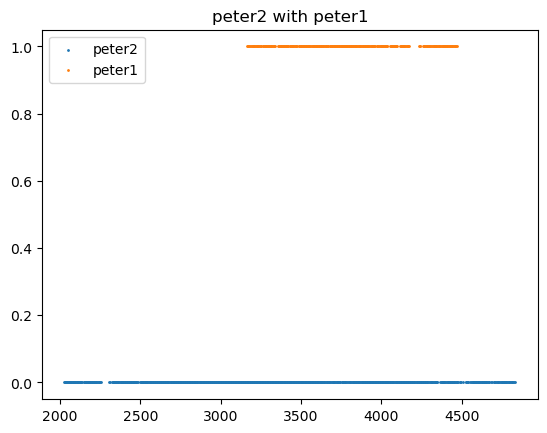

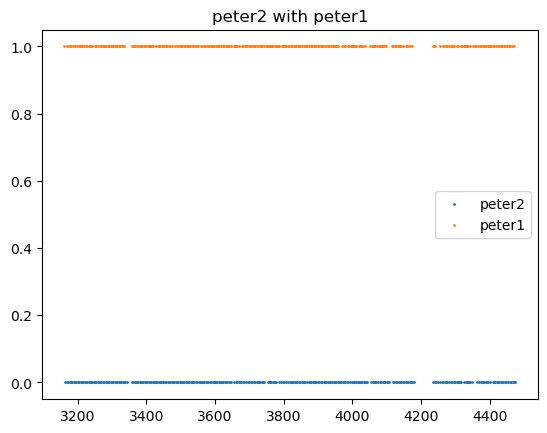

['peter1', 'peter2']


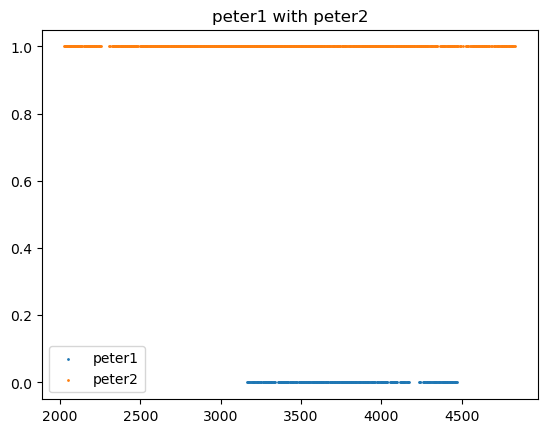

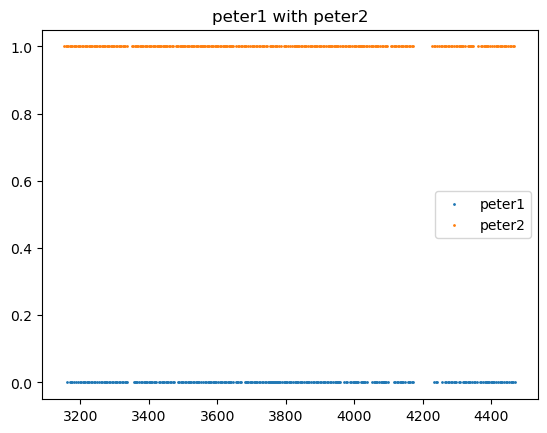

1
attempting to get mean location of cham2
attempting to get mean location of cham1
['cham2' 'cham1']


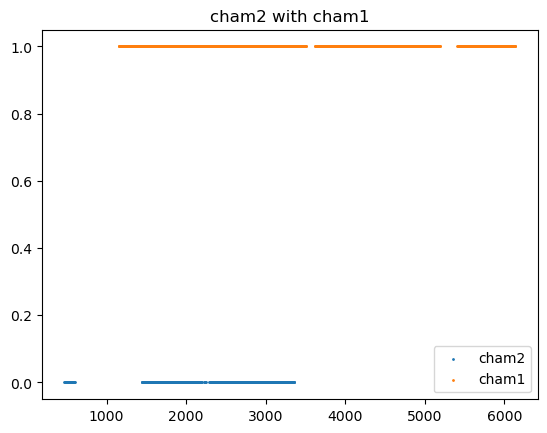

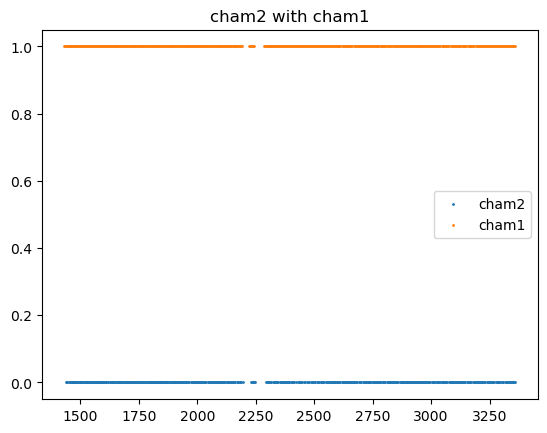

['cham1', 'cham2']


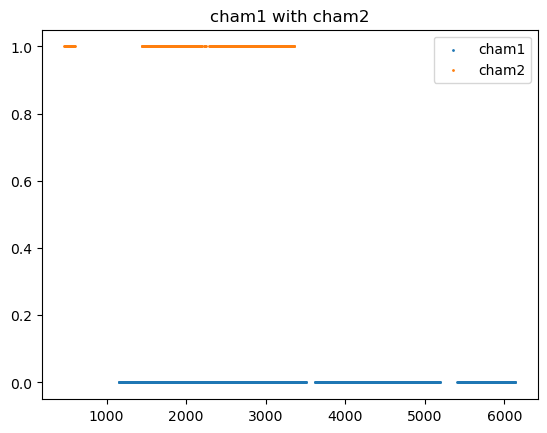

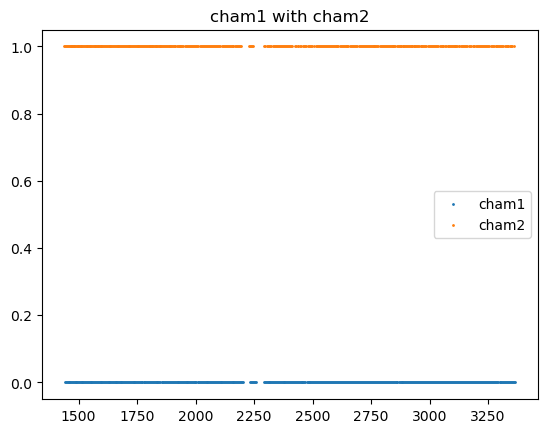

2
attempting to get mean location of BBF8
attempting to get mean location of GB1
['BBF8' 'GB1']


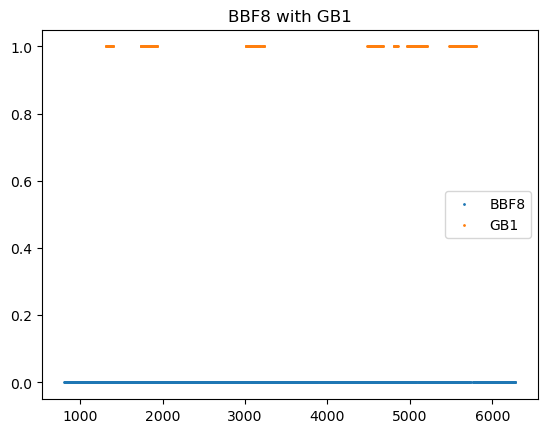

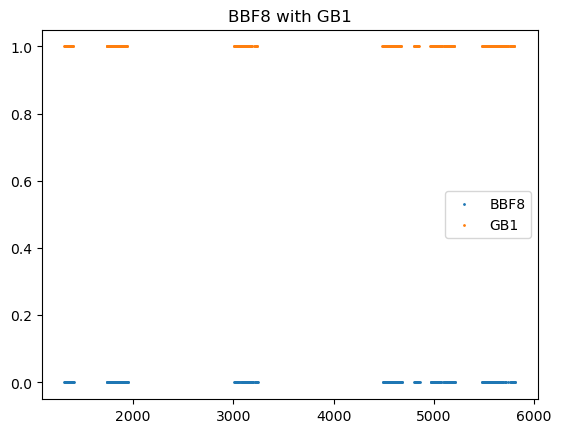

['GB1', 'BBF8']


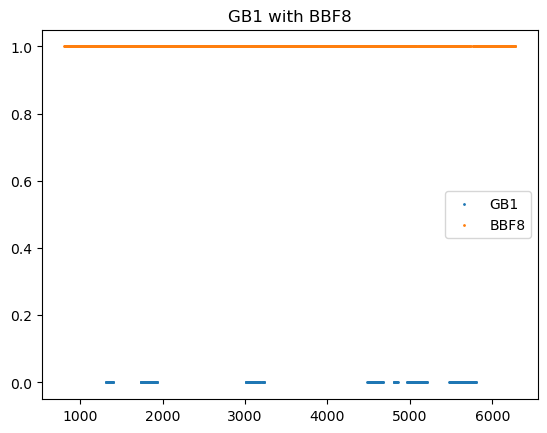

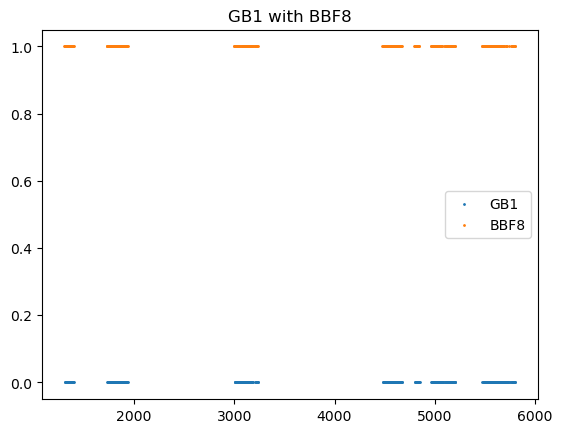

3
attempting to get mean location of BBF8
attempting to get mean location of BBF9
attempting to get mean location of BBF3
['BBF8' 'BBF9']


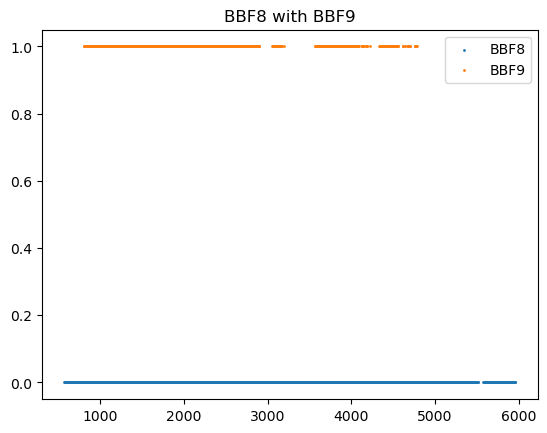

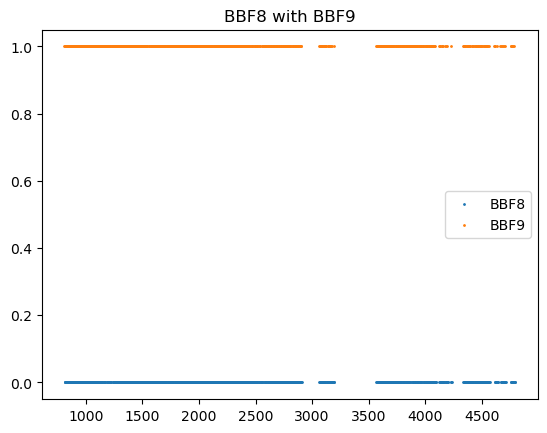

['BBF9', 'BBF8']


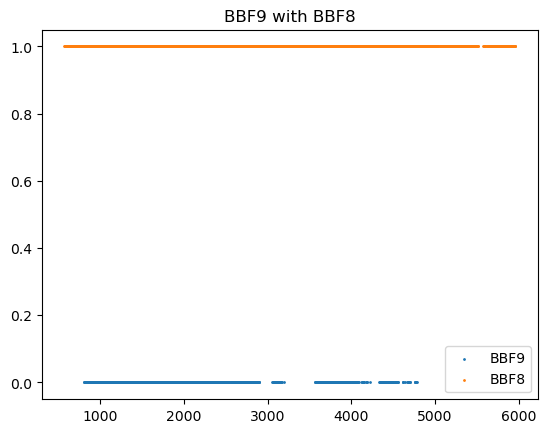

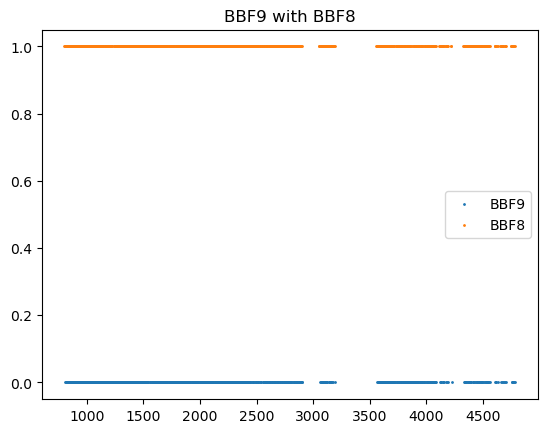

['BBF8', 'BBF3']


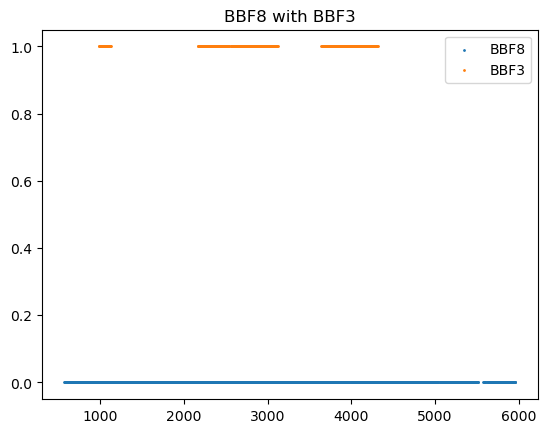

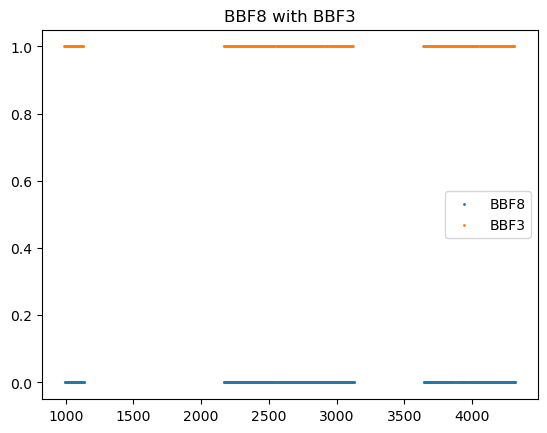

['BBF3', 'BBF8']


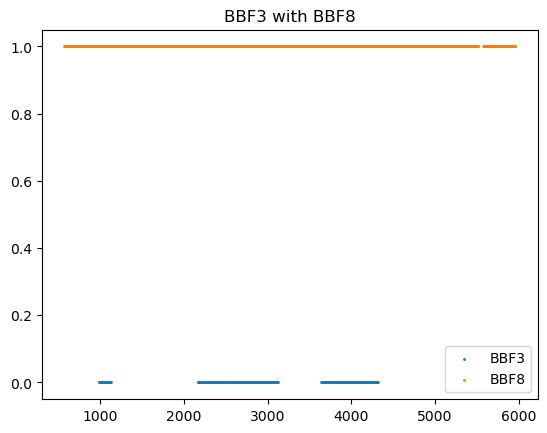

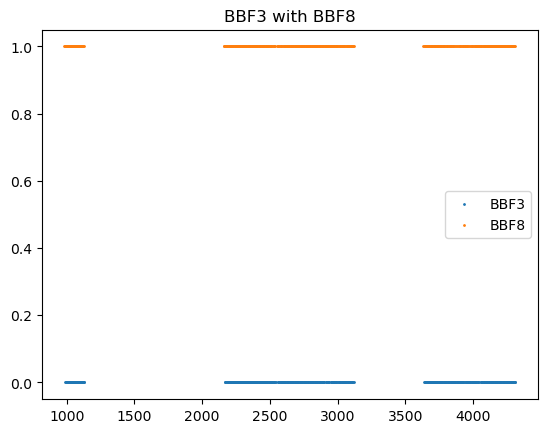

['BBF9', 'BBF3']


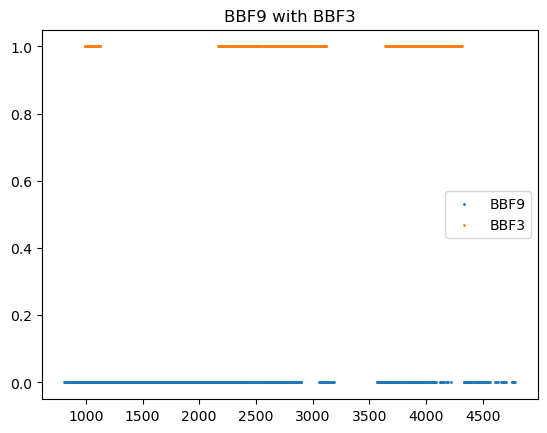

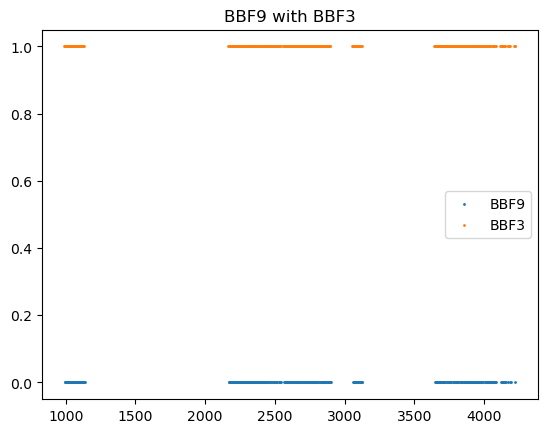

['BBF3', 'BBF9']


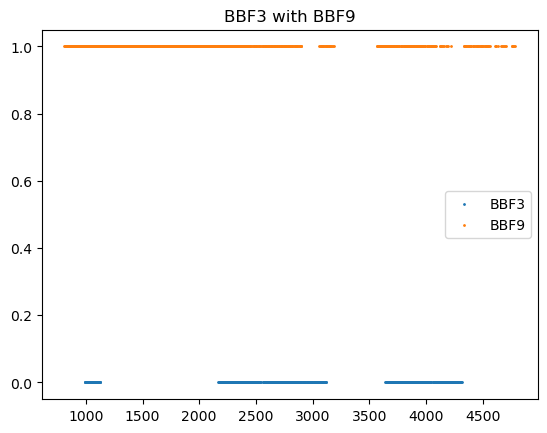

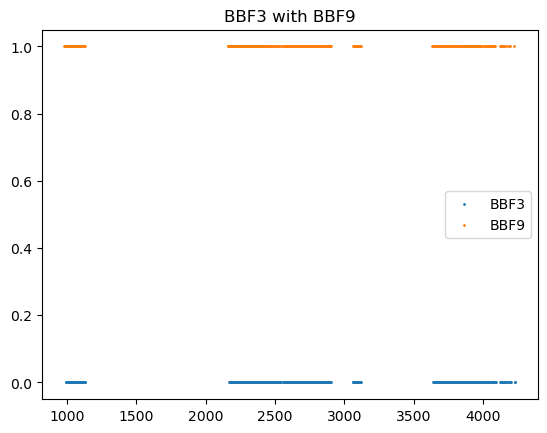

4
attempting to get mean location of chick2
attempting to get mean location of chick3
['chick2' 'chick3']


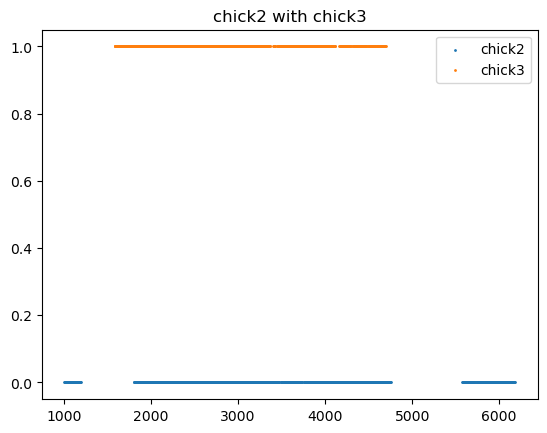

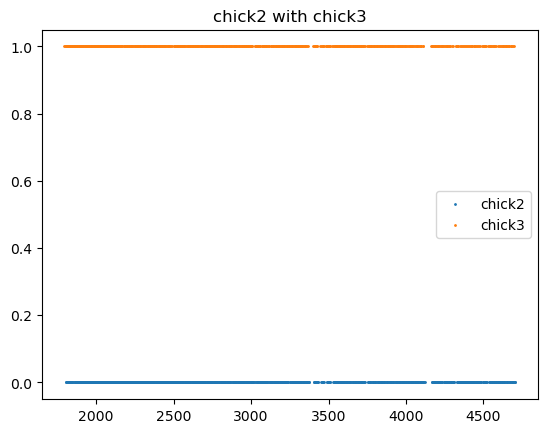

['chick3', 'chick2']


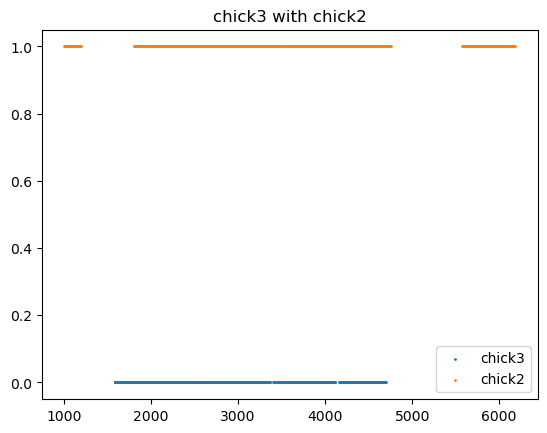

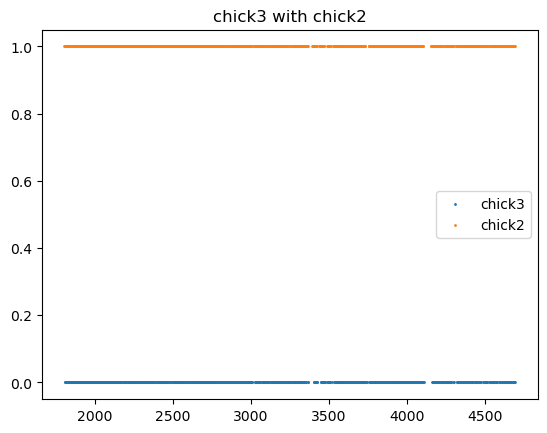

5
attempting to get mean location of BBF3
attempting to get mean location of BBF2
['BBF3' 'BBF2']


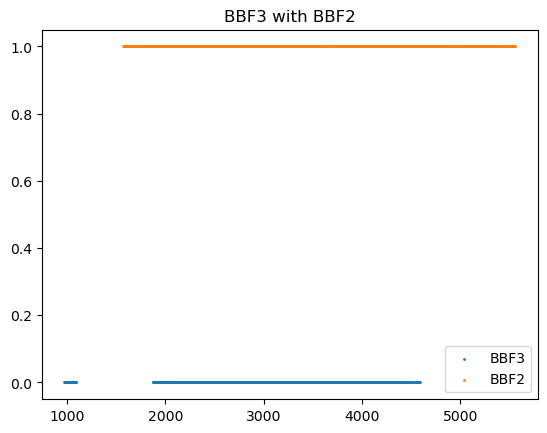

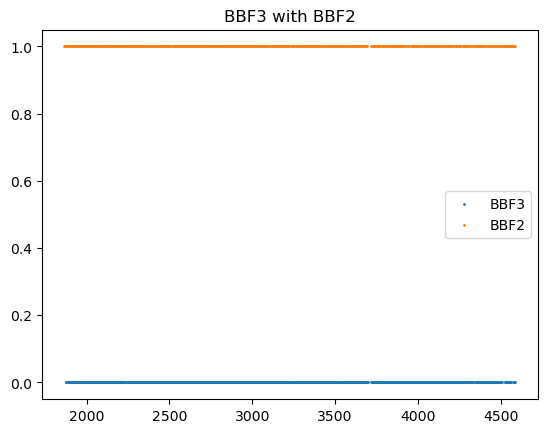

['BBF2', 'BBF3']


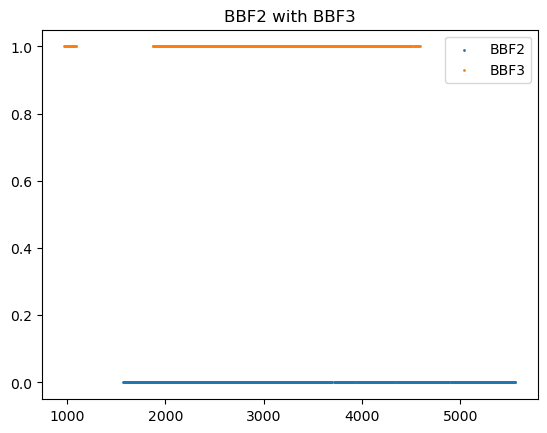

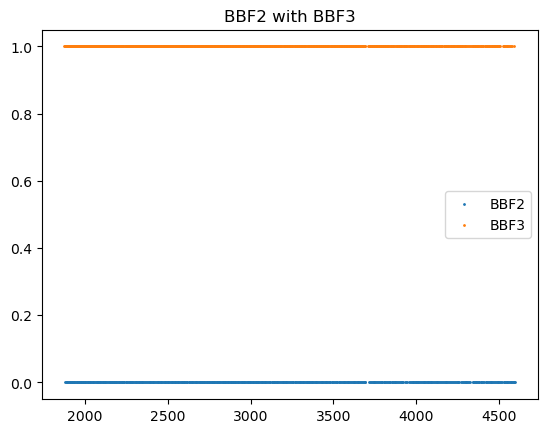

6
attempting to get mean location of frye3
attempting to get mean location of frye1
['frye3' 'frye1']


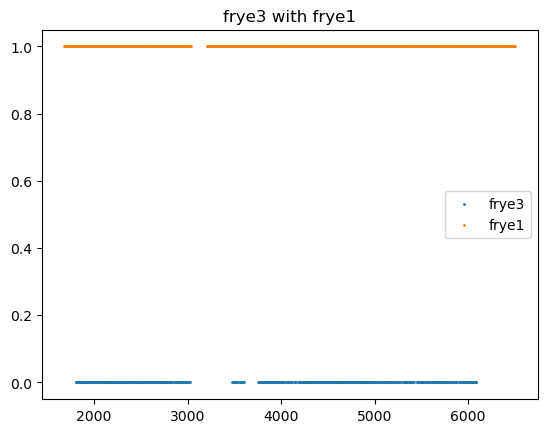

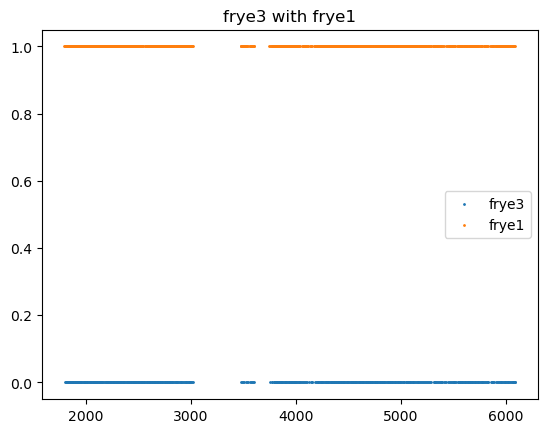

['frye1', 'frye3']


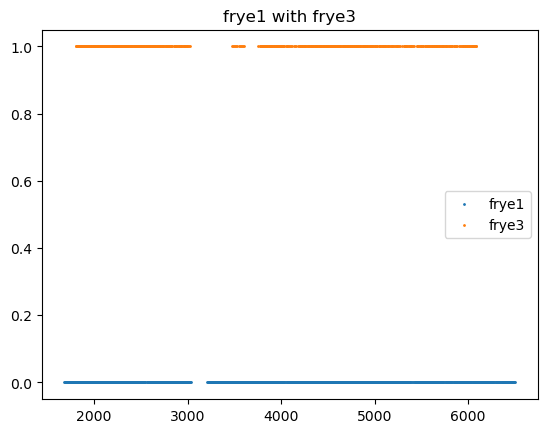

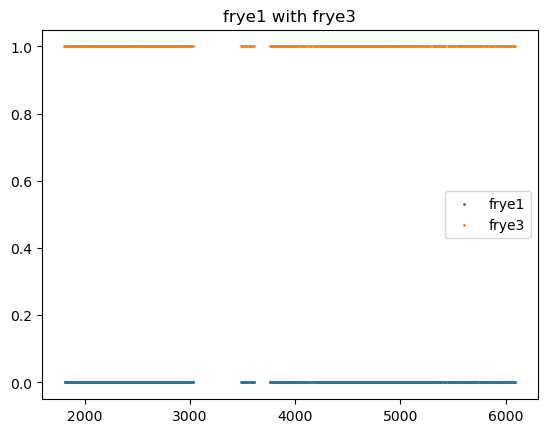

7
attempting to get mean location of frye3
attempting to get mean location of frye1
attempting to get mean location of frye4
['frye3' 'frye1']


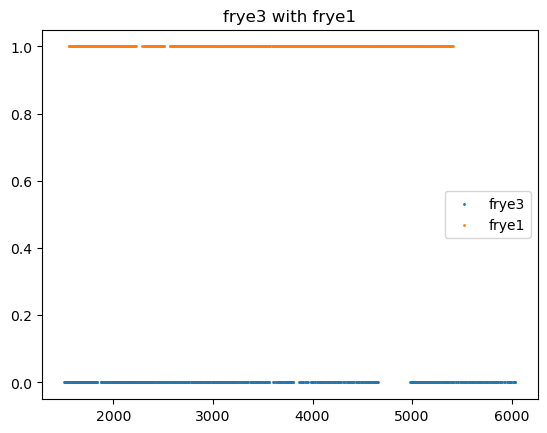

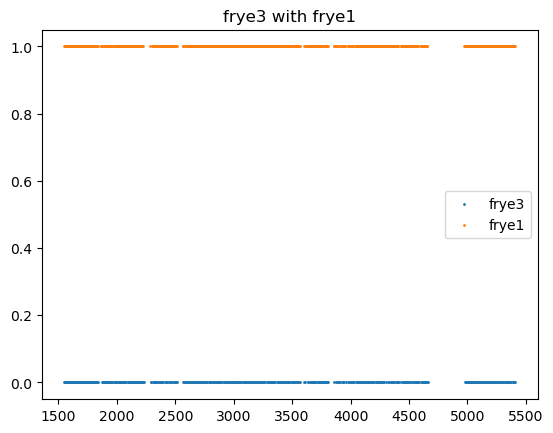

['frye1', 'frye3']


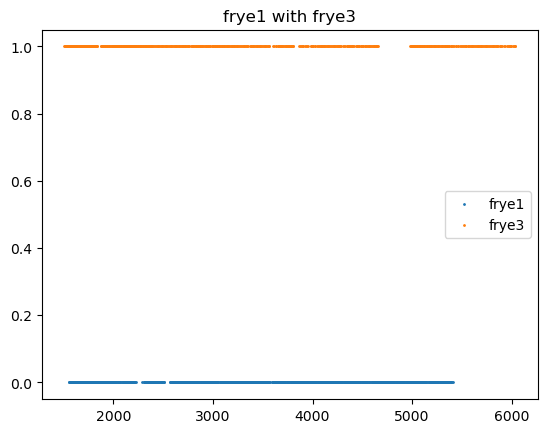

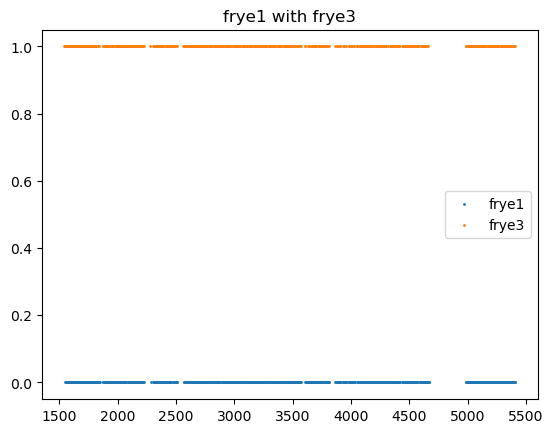

['frye3', 'frye4']


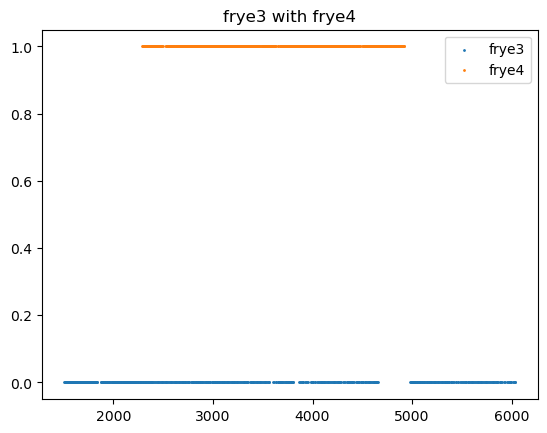

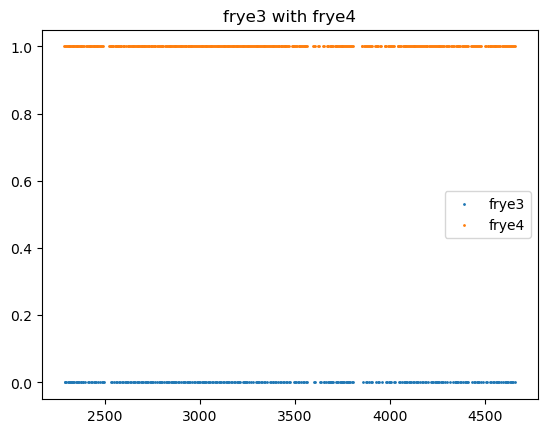

['frye4', 'frye3']


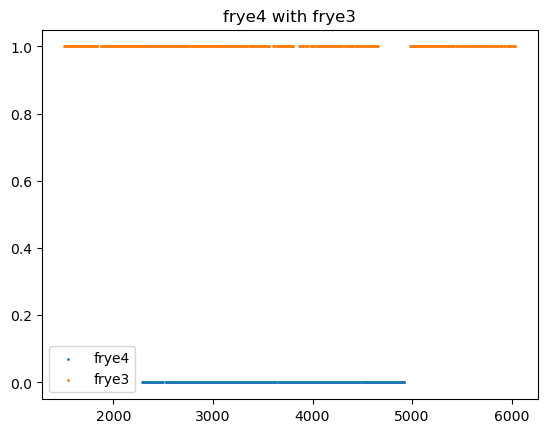

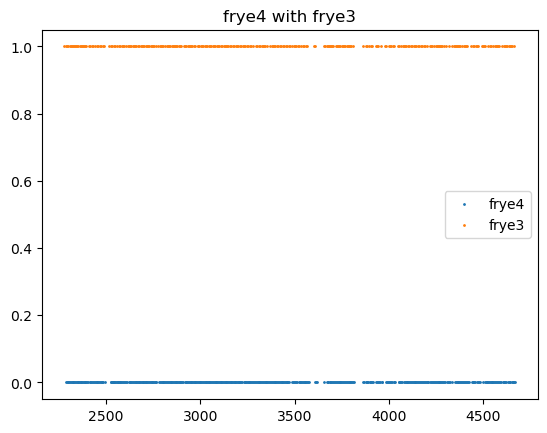

['frye1', 'frye4']


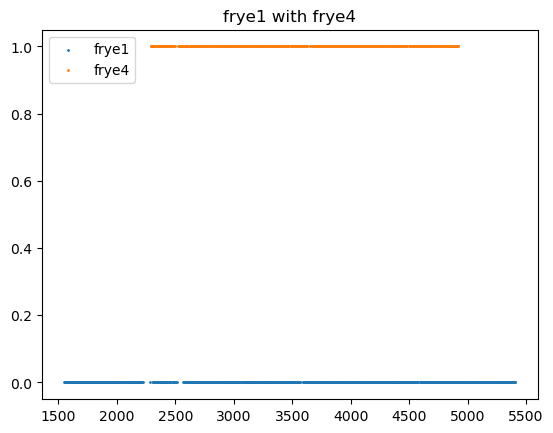

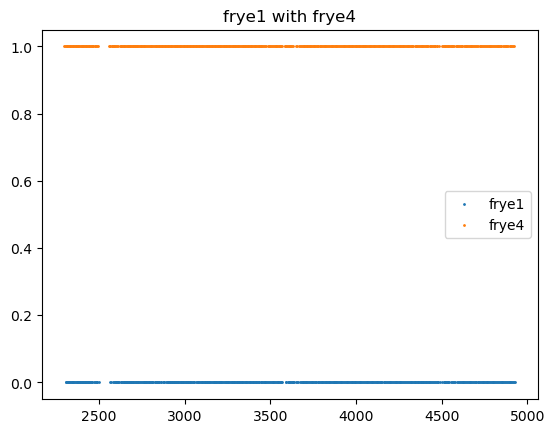

['frye4', 'frye1']


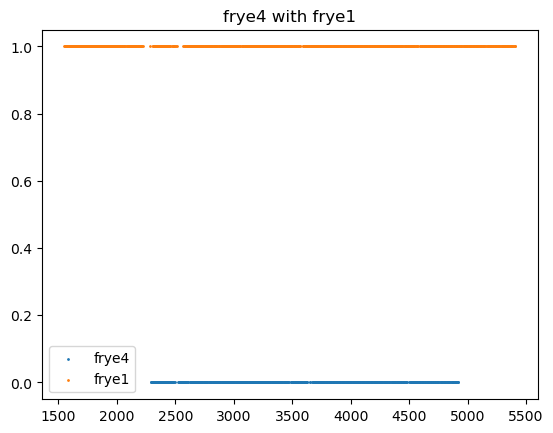

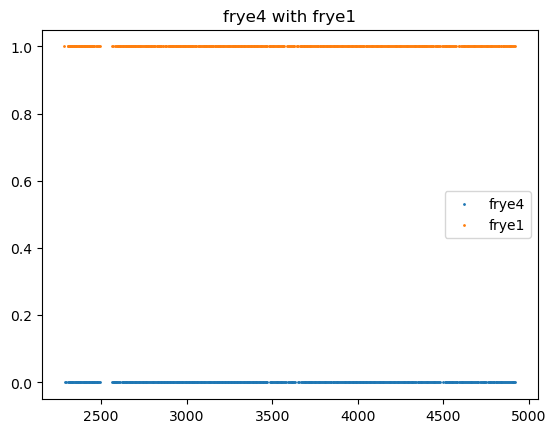

8
attempting to get mean location of power1
attempting to get mean location of power2
['power1' 'power2']


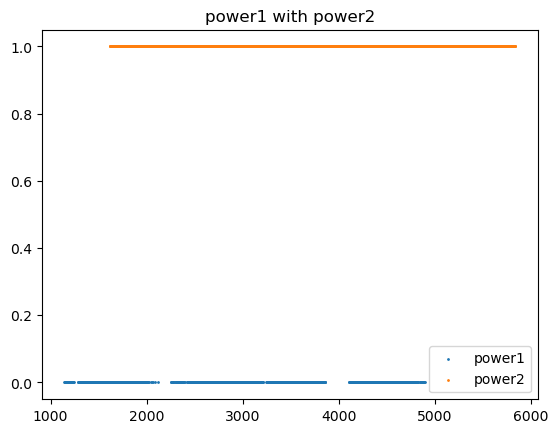

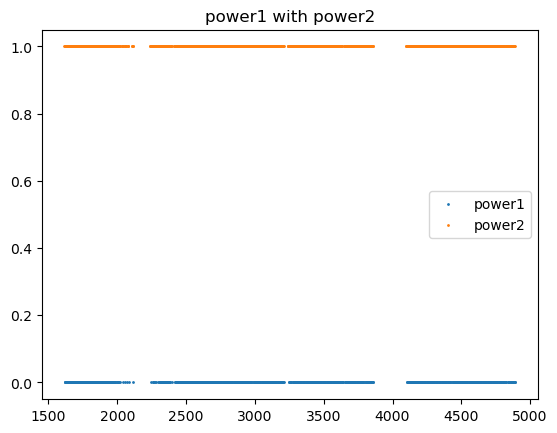

['power2', 'power1']


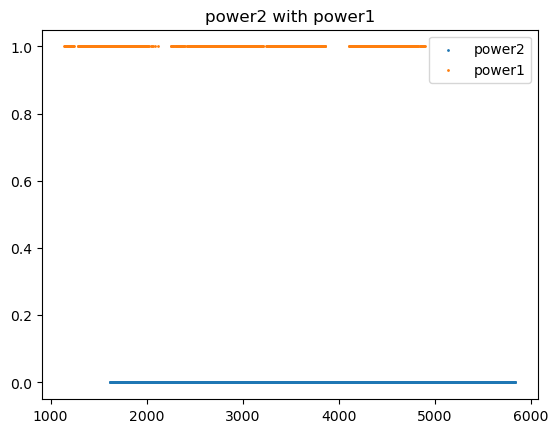

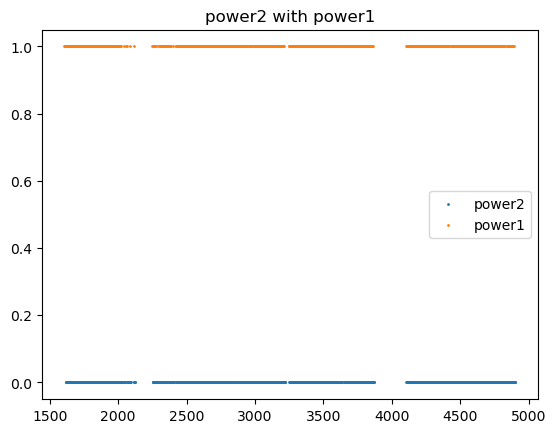

9
attempting to get mean location of frye31
attempting to get mean location of frye32
['frye31' 'frye32']


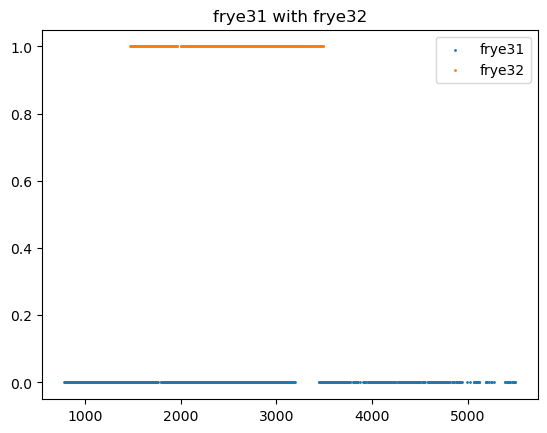

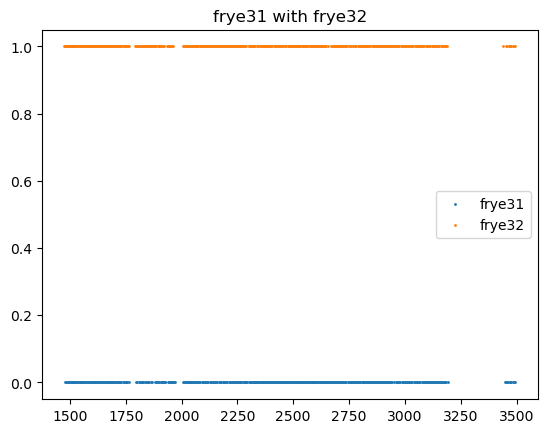

['frye32', 'frye31']


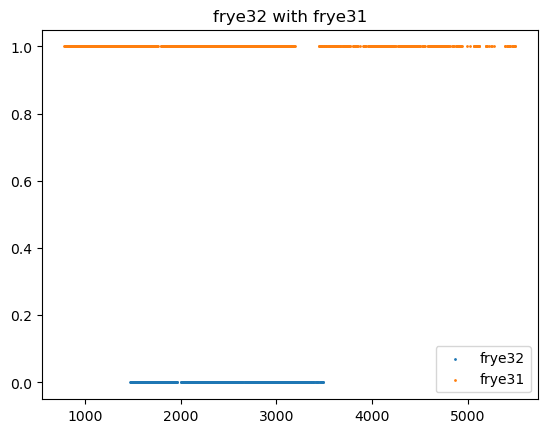

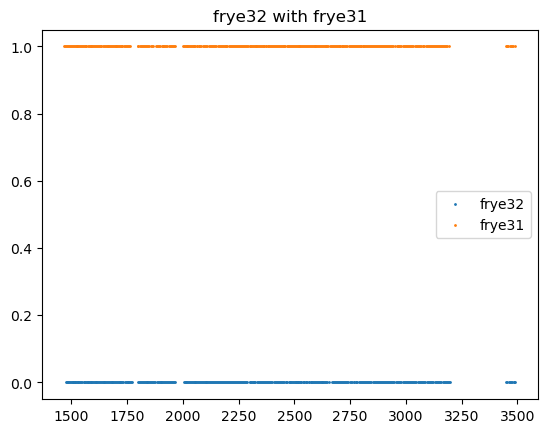

10
attempting to get mean location of frye31
attempting to get mean location of frye32
['frye31' 'frye32']


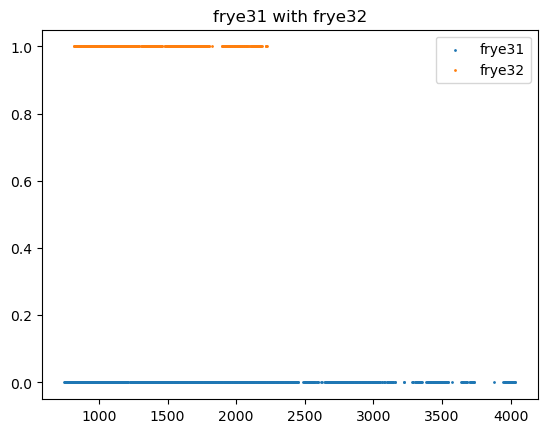

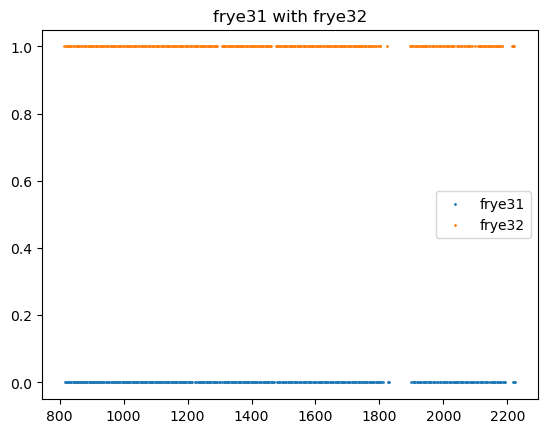

['frye32', 'frye31']


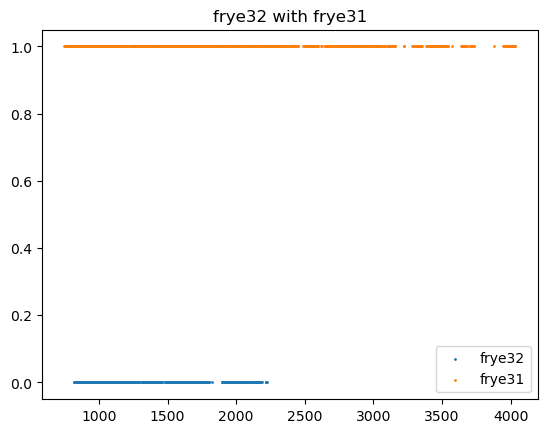

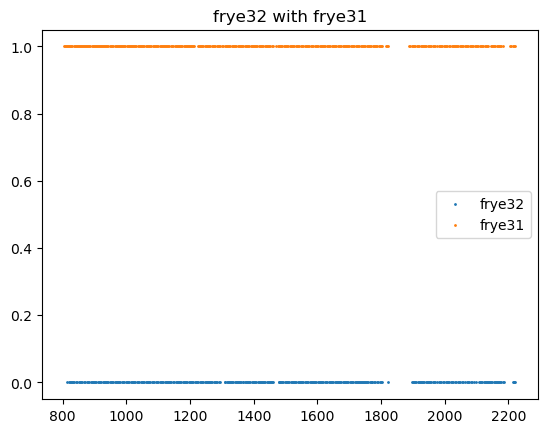

In [15]:
for i, big_df in enumerate(big_dfs):
    print(i)
    generate_SONG_files(big_df, dates[i])

In [10]:
dist = ((mean_loc[0] - loc2[0])**2 + (mean_loc[1] - loc2[1])**2)**.5

index  BirdID    RecA Time RecID   OGRec Time              OG Location  \
0         0  frye31   747.571117     D   810.854630  [-96.25, 12.5, 10.3125]   
1         1  frye31   750.309793     D   813.593323                      NaN   
2         2  frye31   752.596211     D   815.879755  [-191.25, 17.5, 0.9375]   
3         3  frye31   755.272074     D   818.555635                      NaN   
4         4  frye31   757.658993     D   820.942569  [-105.0, 17.5, 12.5625]   
...     ...     ...          ...   ...          ...                      ...   
1053   1053  frye31  4016.624317     B  4058.693484     [-53.75, -6.25, 0.0]   
1054   1054  frye31  4022.986559     B  4065.055713   [-55.0, -5.0, 15.9375]   
1055   1055  frye31  4026.190901     B  4068.260047                      NaN   
1056   1056  frye31  4029.720320     B  4071.789459    [-55.0, -2.5, 5.4375]   
1057   1057  frye31  4034.433952     B  4076.503081       [-52.5, 1.25, 0.0]   

                                      Good Location  \
0     [-89.36969451379252, 13.083923196322498, 0.0]   
1                                               NaN   
2                                             [nan]   
3                                               NaN   
4       [-91.50275647962587, 17.2591881921908, 0.0]   
...                                             ...   
1053                           [-53.75, -6.25, 0.0]   
1054                         [-55.0, -5.0, 15.9375]   
1055                                            NaN   
1056                          [-55.0, -2.5, 5.4375]   
1057                             [-52.5, 1.25, 0.0]   

                                            Av Location  Had OG  Leashed  ...  \
0          [-90.4362254967092, 15.171555694256648, 0.0]       1        1  ...   
1                                                   NaN       0        0  ...   
2         [-90.10703401524316, 14.364047218012953, 0.0]       1        0  ...   
3                                                   NaN       0        0  ...   
4          [-89.7778425337771, 13.556538741769259, 0.0]       1        1  ...   
...                                                 ...     ...      ...  ...   
1053                 [-54.166666666666664, -2.5, 6.875]       1        0  ...   
1054   [-54.583333333333336, -4.583333333333333, 7.125]       1        0  ...   
1055                                                NaN       0        0  ...   
1056  [-54.166666666666664, -2.0833333333333335, 7.125]       1        0  ...   
1057                          [-53.75, -0.625, 2.71875]       1        0  ...   

      dist to frye31  dist btw frye31 and frye32       tsl  Next  \
0                NaN                         NaN       NaN     G   
1                NaN                         NaN  2.738676     D   
2                NaN                         NaN  2.286418     I   
3                NaN                         NaN  2.675863     E   
4                NaN                         NaN  2.386920     A   
...              ...                         ...       ...   ...   
1053             NaN                         NaN  3.622299     A   
1054             NaN                         NaN  6.362243     G   
1055             NaN                         NaN  3.204341     E   
1056             NaN                         NaN  3.529419     D   
1057             NaN                         NaN  4.713632  None   

      Freq Transition  Potential Match Type  Freq Match  \
0                 nan                   nan         NaN   
1                 nan                   nan         NaN   
2                 nan                   nan         NaN   
3                 nan                   nan         NaN   
4                 nan                   nan         NaN   
...               ...                   ...         ...   
1053              nan                   nan         NaN   
1054              nan                   nan         NaN   
1055              nan                   nan         NaN   
1056

In [107]:
for i, big_df in enumerate(big_dfs):
    freq_columns = ['BirdID', 'RecA Time', 'RecA End']
    song_timing_df = big_df[freq_columns][(big_df['nsk'] == 1) & (big_df['psk'] == 1)].copy()
    song_timing_df = song_timing_df.rename(columns={'BirdID': "bird", "RecA Time": "start", "RecA End": "end"})
    song_timing_df = song_timing_df[["start", "end", "bird"]]
    print(song_timing_df)
    song_timing_df.to_csv(f"song-{dates[i]}.txt", sep='\t', index=False, header=False)

           start          end    bird
0    2027.445543  2029.229303  peter2
1    2030.353818  2031.835842  peter2
2    2032.948025  2034.626730  peter2
3    2036.540969  2038.149280  peter2
4    2039.392712  2040.992147  peter2
..           ...          ...     ...
950  4809.129284  4810.707030  peter2
951  4813.151464  4814.750898  peter2
952  4817.663845  4819.272156  peter2
953  4824.671236  4826.454995  peter2
954  4832.652748  4834.278716  peter2

[953 rows x 3 columns]
            start          end   bird
0      469.721383   471.243261  cham2
1      477.693644   479.232445  cham2
2      481.825210   483.355985  cham2
3      485.888270   487.438935  cham2
4      494.718923   496.249712  cham2
...           ...          ...    ...
1549  6118.198119  6119.919464  cham1
1550  6123.727290  6125.377722  cham1
1551  6128.272302  6129.986691  cham1
1552  6132.645120  6134.167794  cham1
1553  6137.524545  6139.149422  cham1

[1554 rows x 3 columns]
            start          end  bird
0 

In [155]:
start = 250
print(len(big_dfs))
big_df = big_dfs[3]
filtered = big_df[big_df['array up'] == 0]
filtered[['Gl Consistency', 'nsk', 'RecA Time', 'BirdID', 'RecA End', 'ID', 'Next', 'psk', 'OGRec Time', 'array up', 'Av Location', 'Valid Location']]

6


Gl Consistency  nsk    RecA Time BirdID     RecA End ID Next  psk  \
0               NaN    1   575.999338   BBF8   577.714889  B    D    1   
1               NaN    1   579.716445   BBF8   581.471747  D    H    1   
2               NaN    1   583.294161   BBF8   584.671924  H    G    1   
3               NaN    1   586.523397   BBF8   588.175628  G    A    1   
4               NaN    1   590.101113   BBF8   591.646265  A    E    1   
..              ...  ...          ...    ...          ... ..  ...  ...   
279             NaN    1  1130.446514   BBF9  1132.260643  A    D    1   
281             NaN    1  1133.423941   BBF9  1135.032399  D    B    1   
283             NaN    1  1137.245713   BBF9  1139.136045  B    G    1   
285             NaN    1  1140.543102   BBF9  1142.112950  G    C    1   
287             NaN    1  1143.627182   BBF9  1145.702184  C    A    1   

      OGRec Time  array up                                        Av Location  \
0     619.531579         0                       [-66.875, -14.375, 20.90625]   
1     623.246749         0  [-64.58333333333333, -14.583333333333334, 19.0...   
2     626.822600         0                                                NaN   
3     630.050155         0                 [-64.58333333333333, -15.0, 17.75]   
4     633.626006         0                 [-62.5, -15.416666666666666, 15.0]   
..           ...       ...                                                ...   
279  1181.243576         0      [24.628849801537072, -35.12561627785914, 0.0]   
281  1184.219465         0                                 [22.5, -35.0, 0.0]   
283  1188.039263         0    [32.39445768001264, -40.1805454310563, 0.28125]   
285  1191.334949         0                                                NaN   
287  1194.417437         0   [29.929638453341763, -35.53703028737087, 1.4375]   

    Valid Location  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
..             ...  
279            NaN  
281            NaN  
283            NaN  
285            NaN  
287            NaN  

[143 rows x 12 columns]

In [ ]:
# , 
dates = ['04-26-2024', '04-27-2024', '04-22-2024', '04-30-2024', '05-06-2024', '05-07-2024', '06-22-2023', '06-23-2023', '06-11-2023', '06-09-2023', '07-07-2023']
#start_times = ['0:27:50', '0:38:29', '0:25:59', '0:26:30', '0:24:12', '0:19:34', '0:23:21', '0:19:05']
#end_times = ['1:41:40', '1:37:23', '1:30:29', '1:31:35', '1:31:34', '1:31:24', '1:37:37', '1:35:19']
matches = []
birdnames = []
mean_freqs_arr = []
all_cons = []
all_times = []
big_dfs = []
for date in dates:
    # if date != '04-26-2024':
    #     continue
    if date == '06-22-2023':
        continue
    print("working on: ", date)
    df_name_list = []
    name_stub ='test_finaldf_' + '*' + date + '.pickle'
    for file in glob.glob(name_stub):
        df_name_list.append(file)
    df_name_list
    print(df_name_list)
    df_array = []
    for name in df_name_list:
        with open(name, "rb") as input_file:
            current_df = pickle.load(input_file)
        df_array.append(current_df)
    
    big_df = pd.concat(df_array, ignore_index=True)   
    big_df = big_df.sort_values('RecA Time', ignore_index=True)
    
    #adds data to various columns
    #does not include tsl for second bird
    birds = big_df["BirdID"].unique()
    big_df = add_mean_freq(big_df)
    big_df = add_high_or_low(big_df)
    #add values to big_df
    for bird in birds:
        print(bird)
        
        big_df = add_time_since_last_song(big_df, bird)
        big_df = add_transitions_to_bird(big_df, bird)
        syntax_window = 100
        big_df = add_con_and_lin_for_bird(big_df, bird, syntax_window)
        #big_df = add_future_con_and_lin_for_bird(big_df, bird, syntax_window)
    big_df = add_freq_match(big_df, birds[0], birds[1])
    big_df = add_freq_match(big_df, birds[1], birds[0])
    big_df = add_distance_to_bird(big_df, birds[1], birds[0])
    big_df = add_distance_to_bird(big_df, birds[0], birds[1])
    big_df = get_dist_btw_birds(big_df, birds[:2])
    big_df = add_distance_to_mean_bird(big_df, birds[0], birds[1])
    big_df = add_distance_to_mean_bird(big_df, birds[1], birds[0])
    big_df = add_rolling_freq_matches(big_df)
    big_dfs.append(big_df)

    bird1_df = big_df[big_df["BirdID"] == birds[0]]
    bird2_df = big_df[big_df["BirdID"] == birds[1]]
    all_lows, all_highs, low_matches, high_matches, low_nonmatches, high_nonmatches = check_freq_matching(bird1_df)
    match_dict = build_match_dict(all_lows, all_highs, low_matches, high_matches, low_nonmatches, high_nonmatches)
    matches.append(match_dict)
    all_lows, all_highs, low_matches, high_matches, low_nonmatches, high_nonmatches = check_freq_matching(bird2_df)
    match_dict = build_match_dict(all_lows, all_highs, low_matches, high_matches, low_nonmatches, high_nonmatches)
    matches.append(match_dict)
    birdnames.append(birds[0])
    birdnames.append(birds[1])
    mean_freqs = big_df["Mean Freq (Hz)"].to_numpy()
    mean_freqs_arr.append(mean_freqs)
    

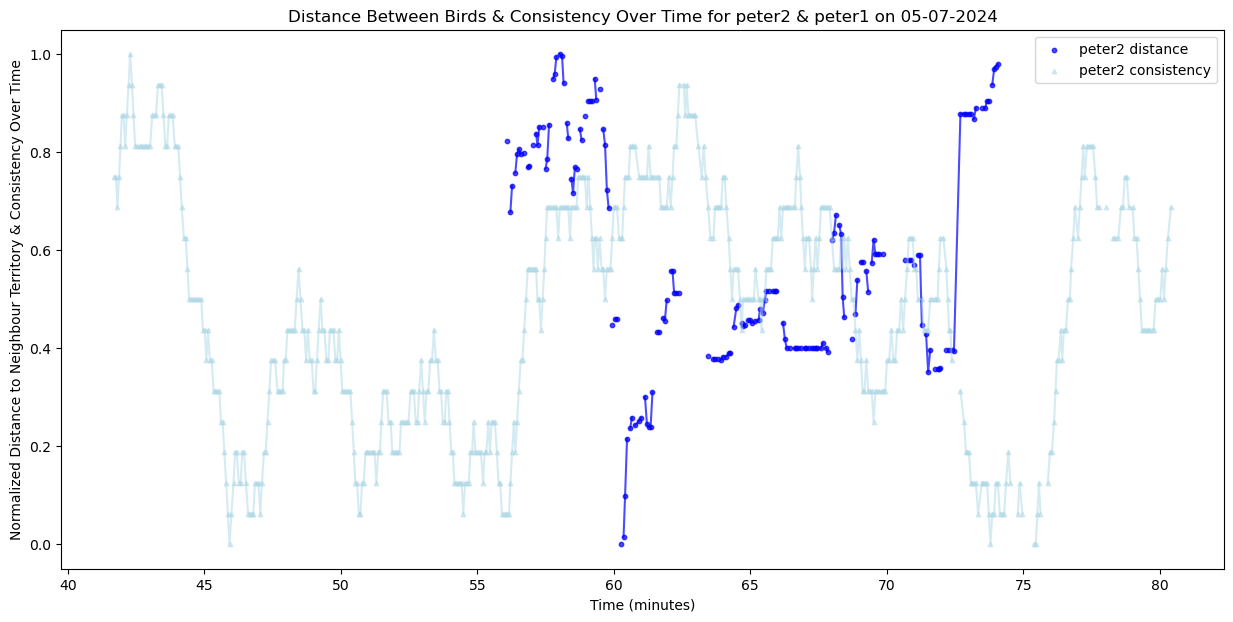

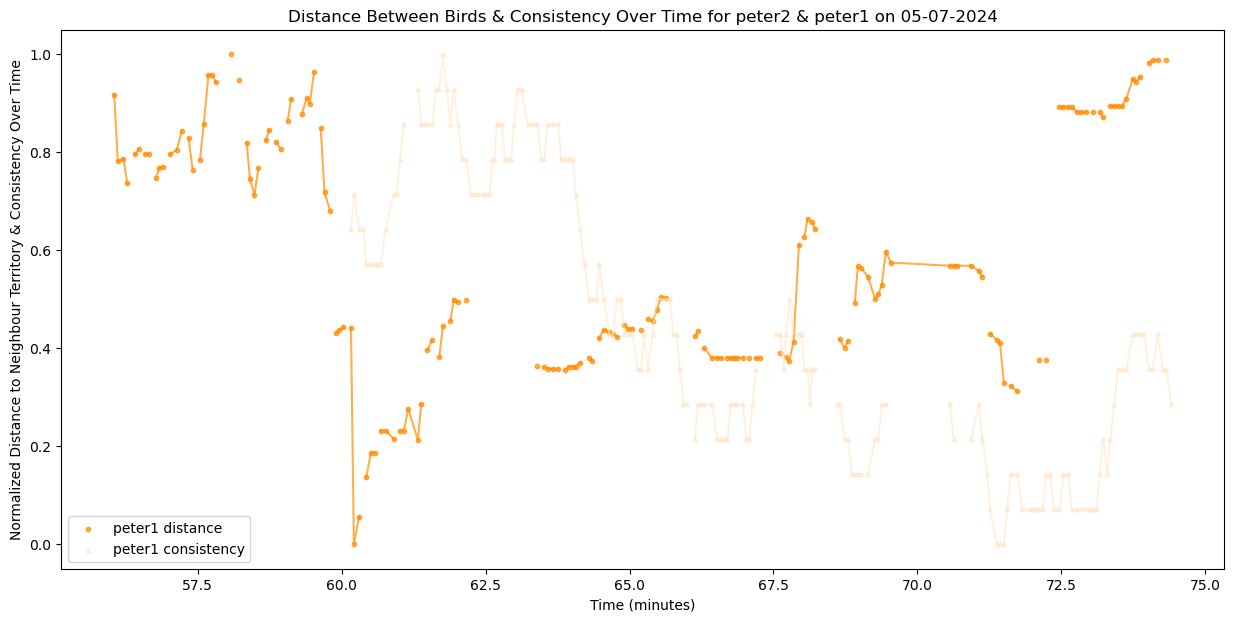

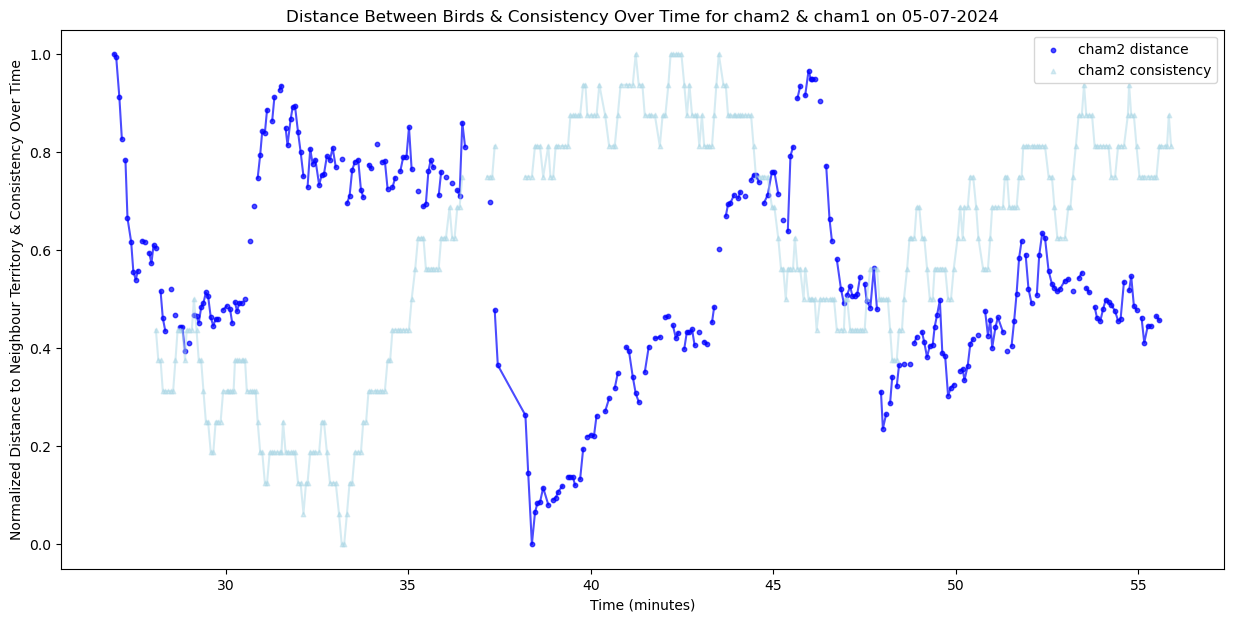

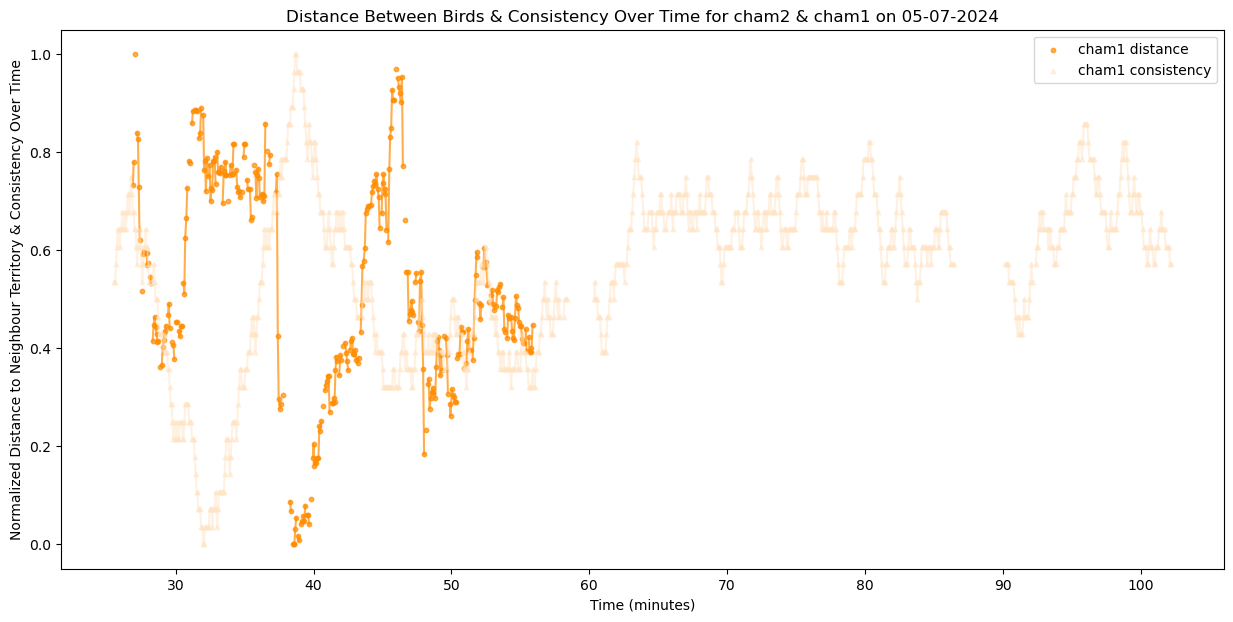

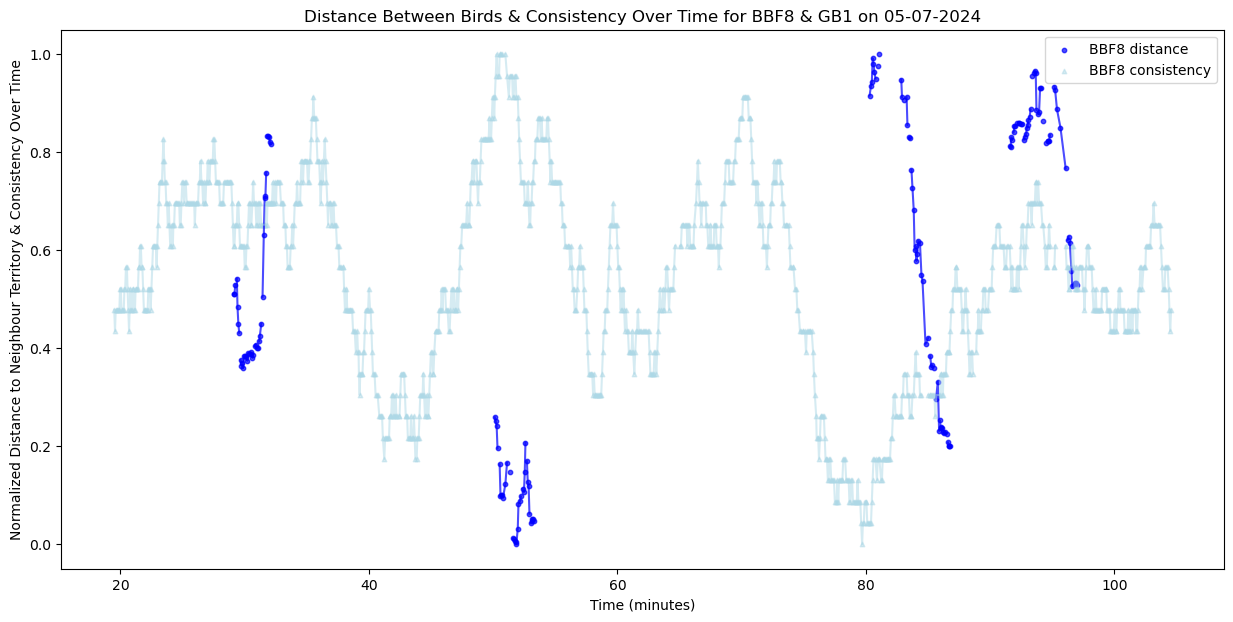

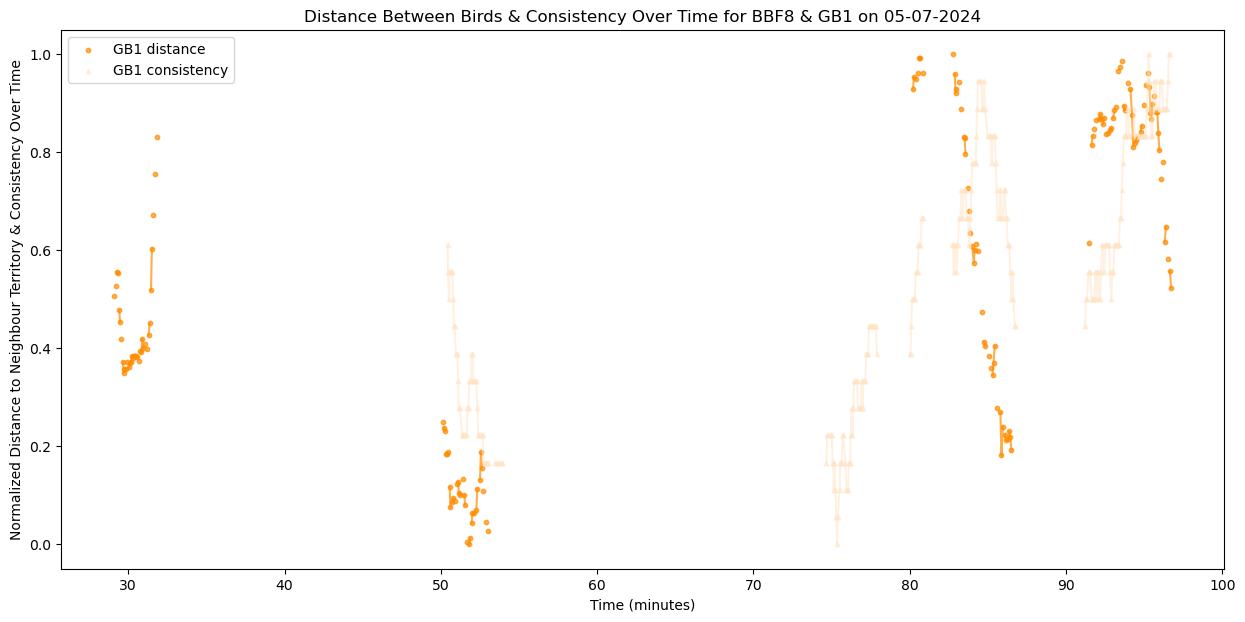

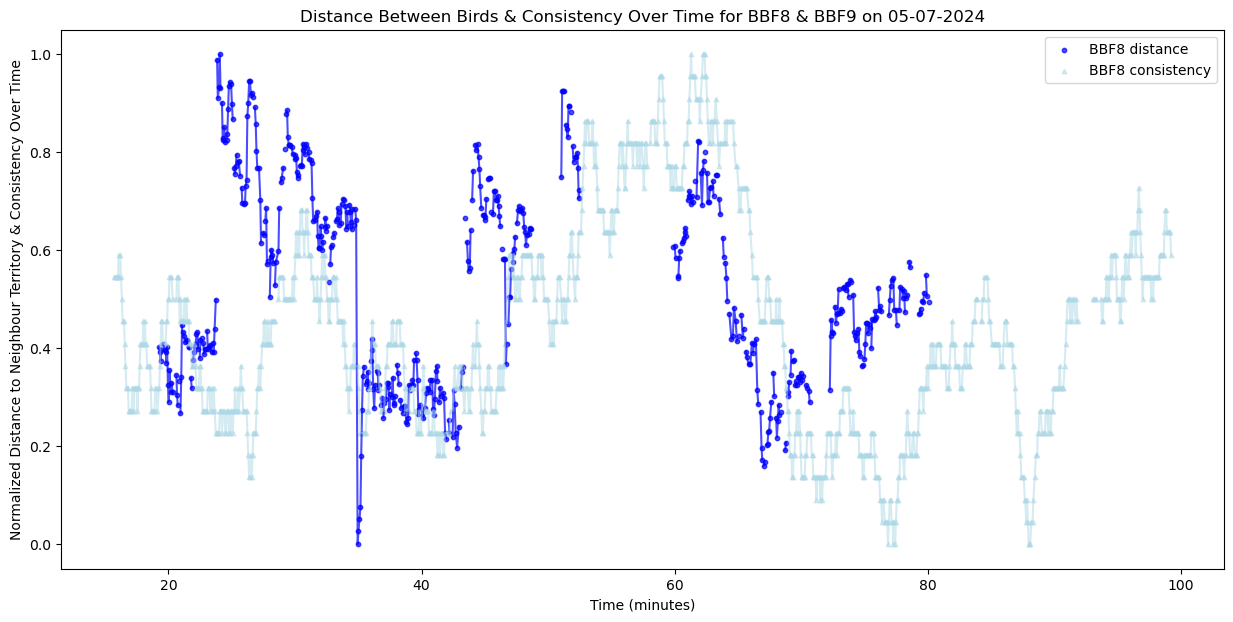

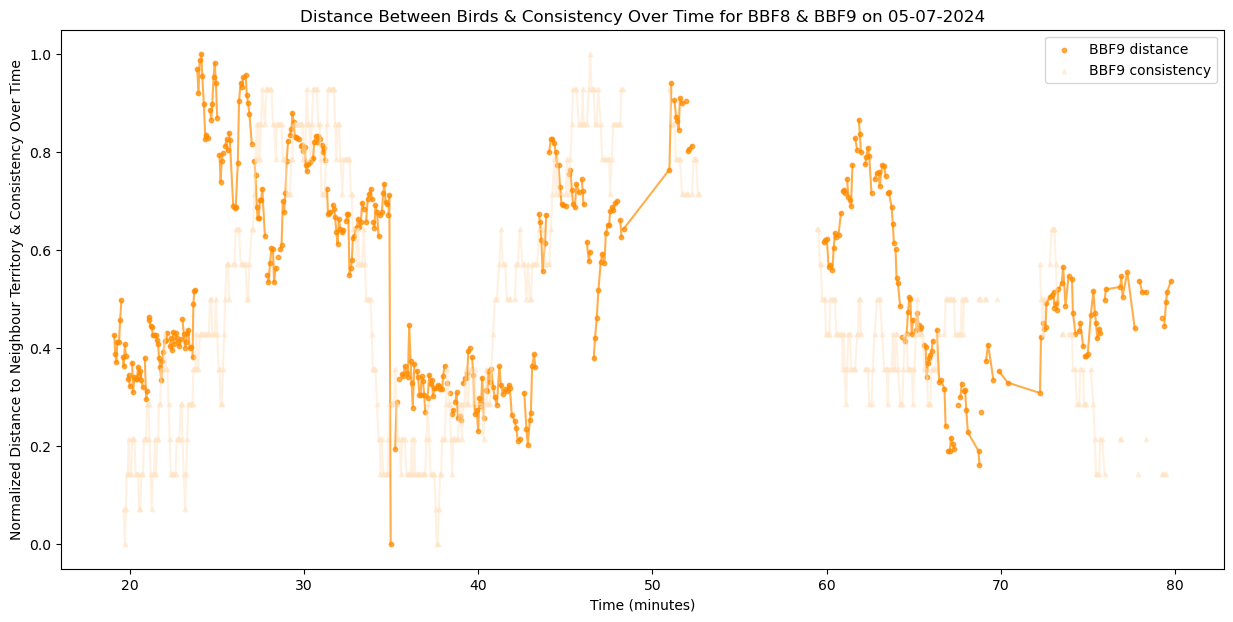

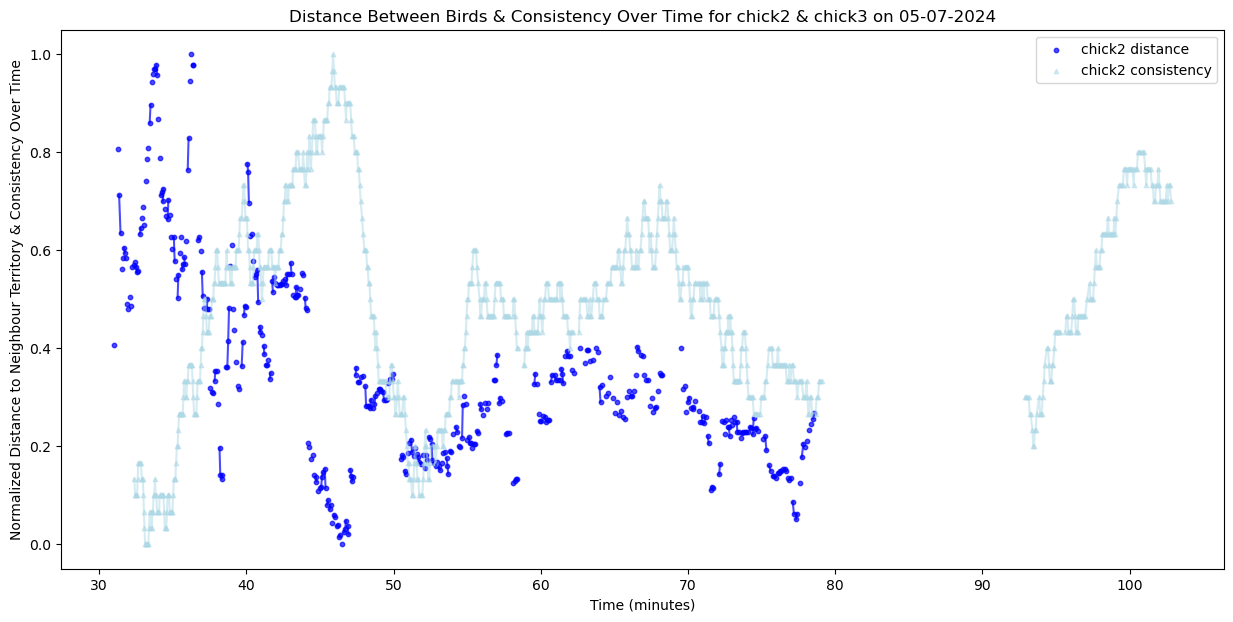

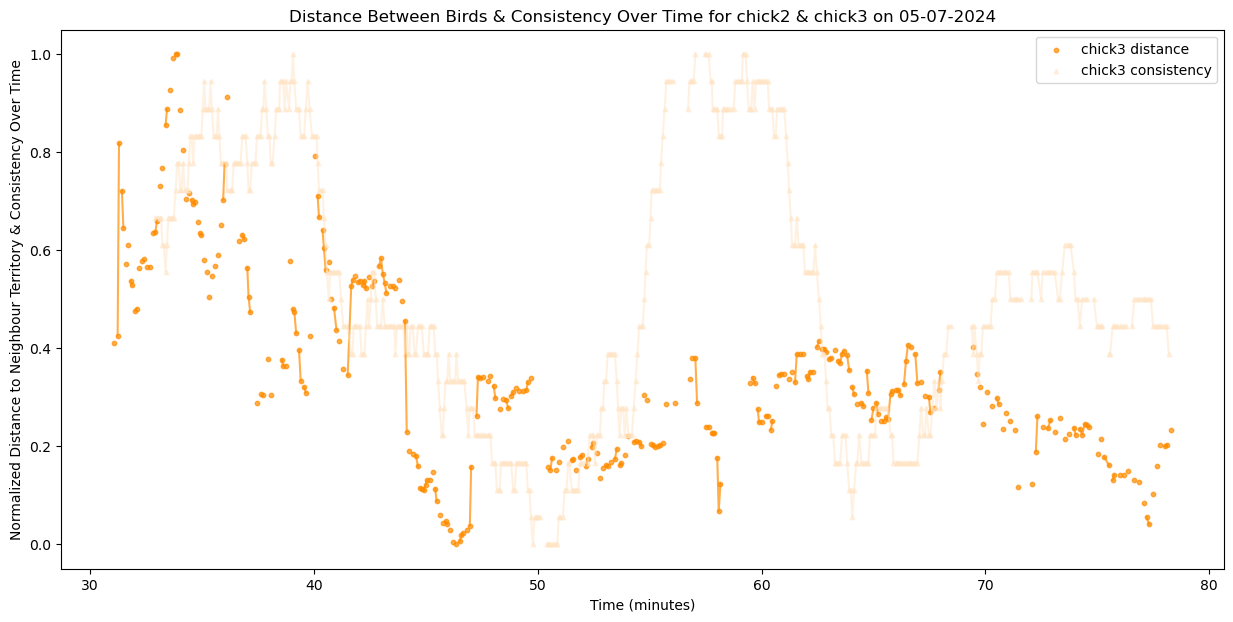

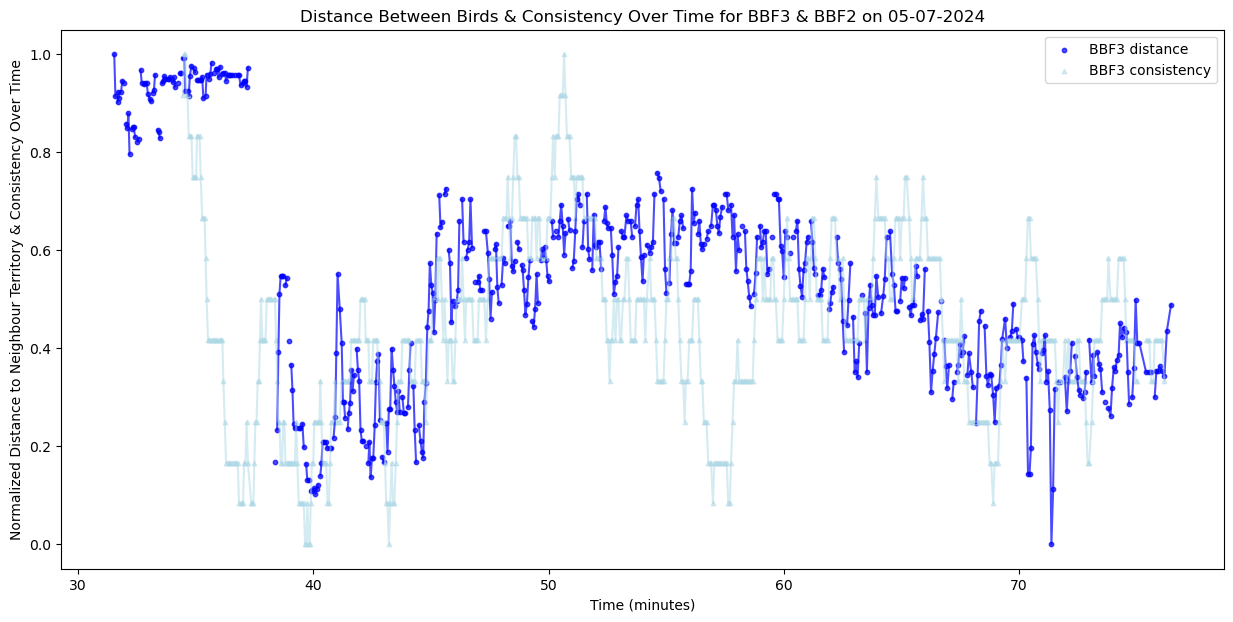

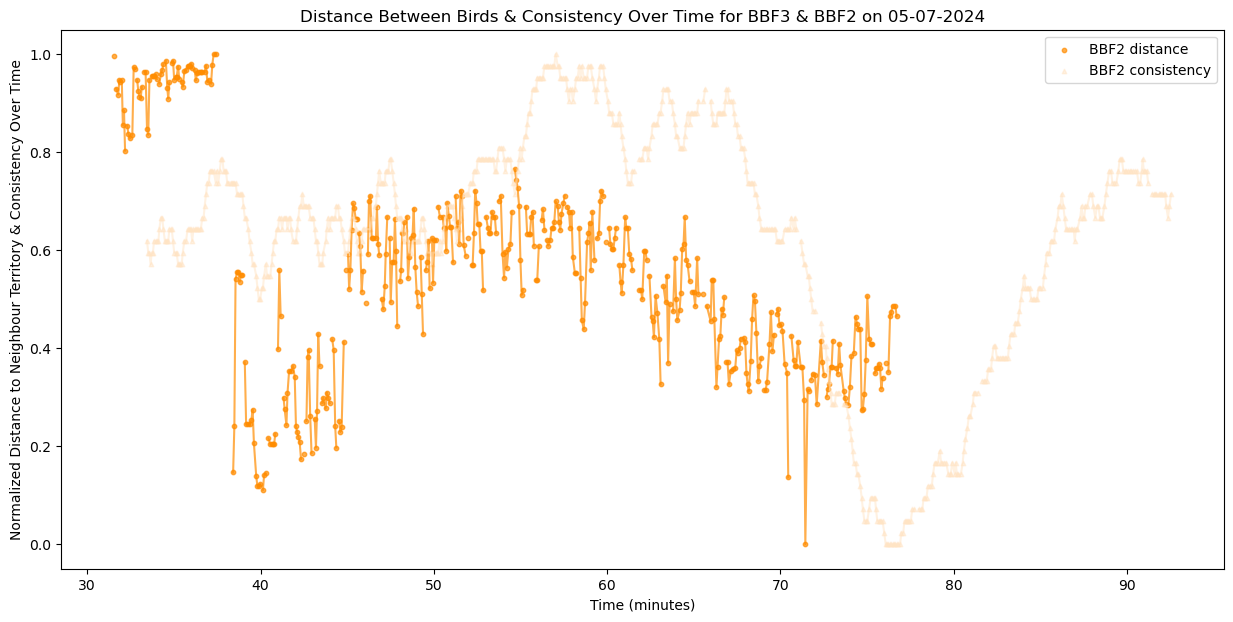

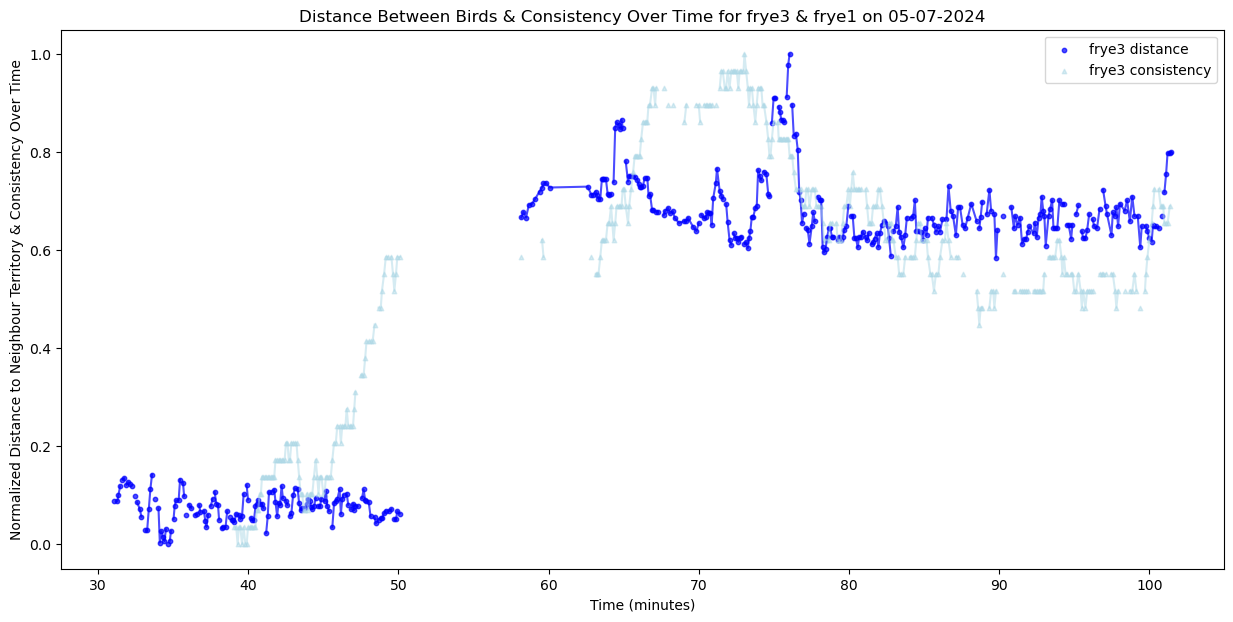

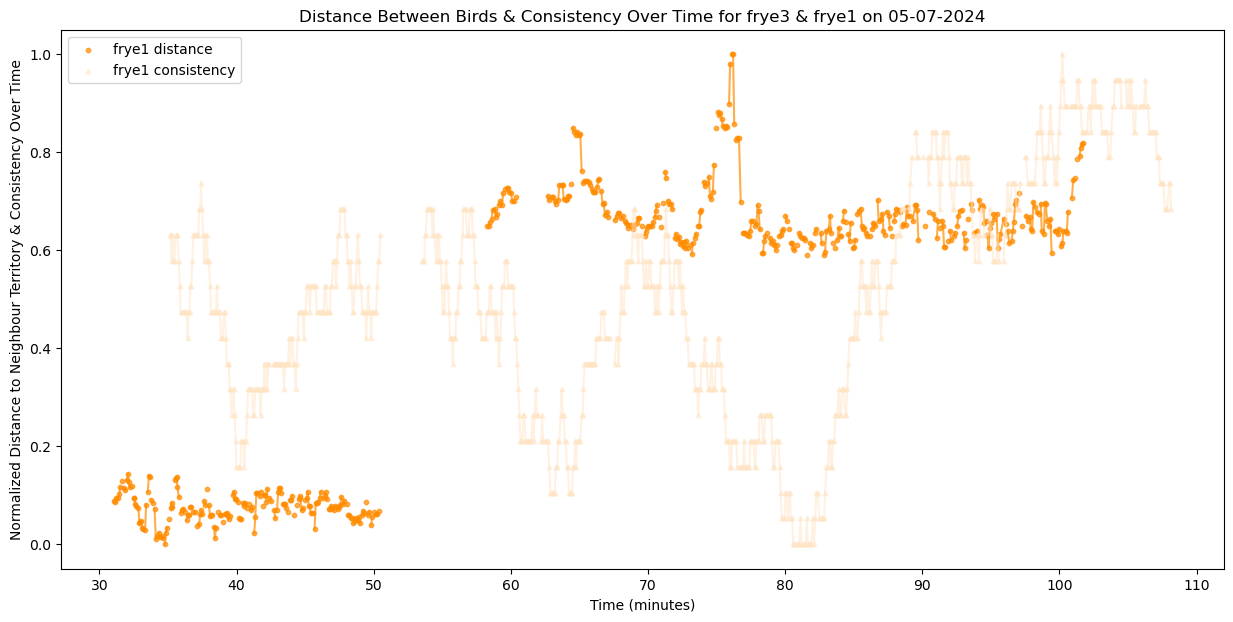

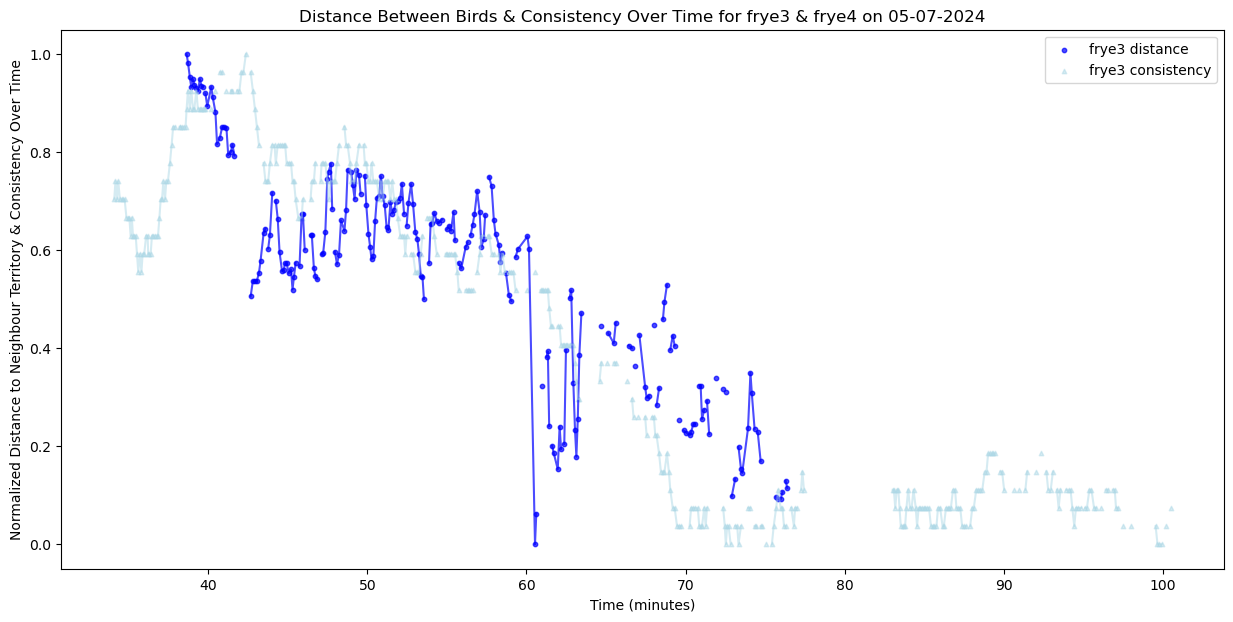

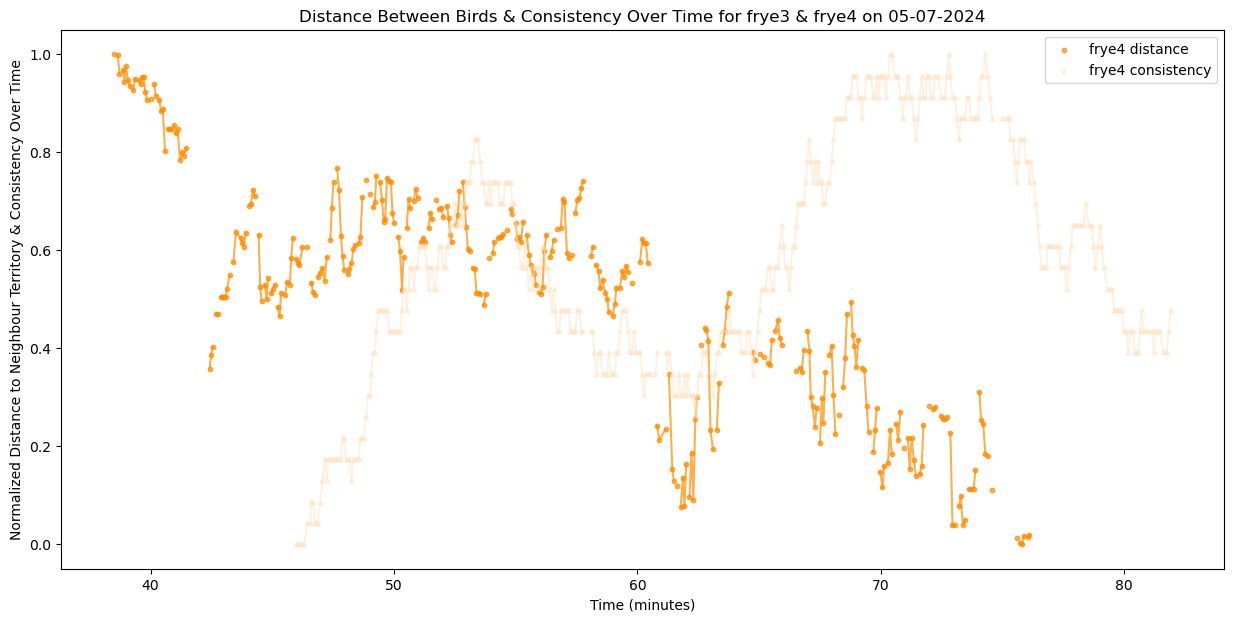

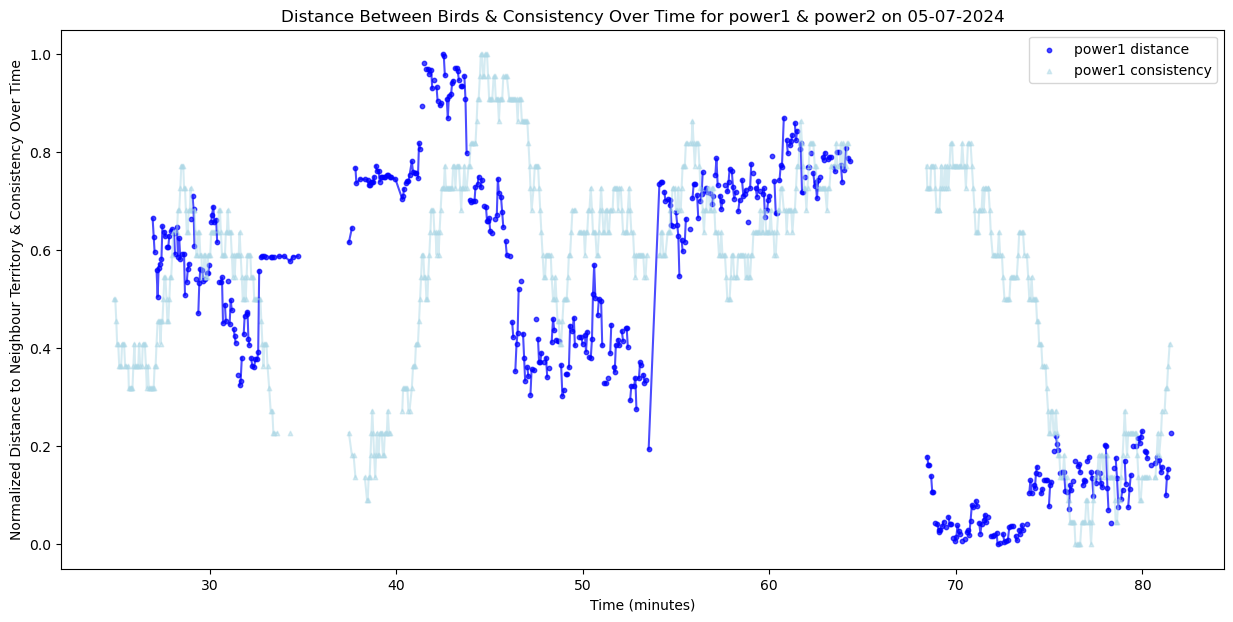

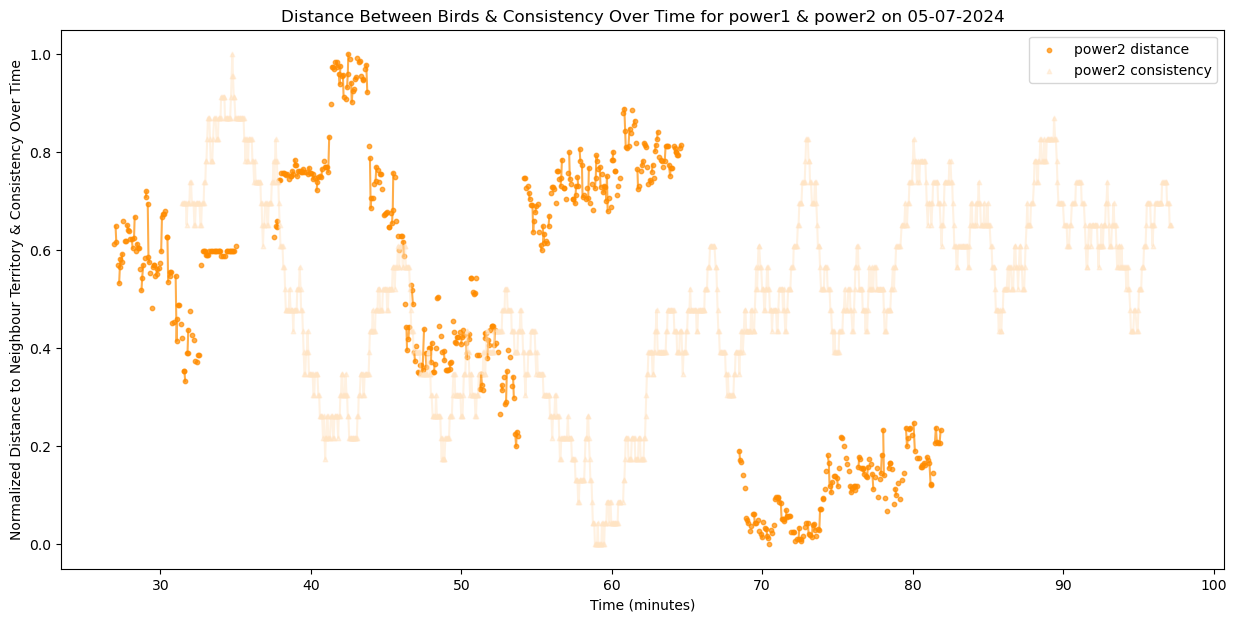

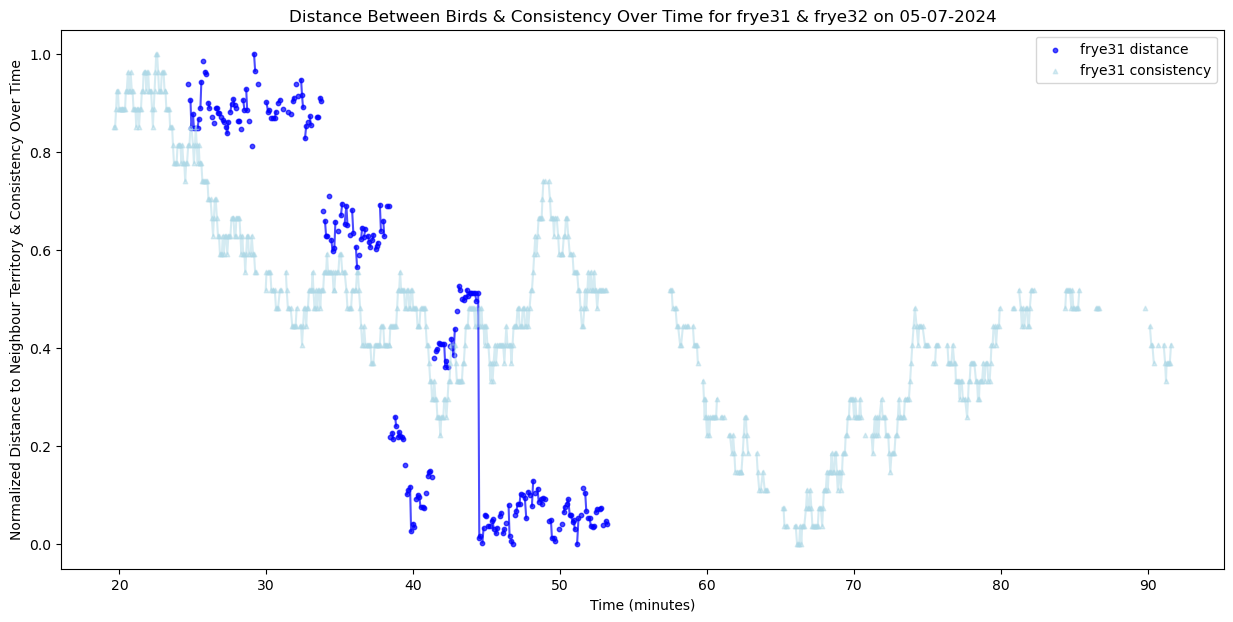

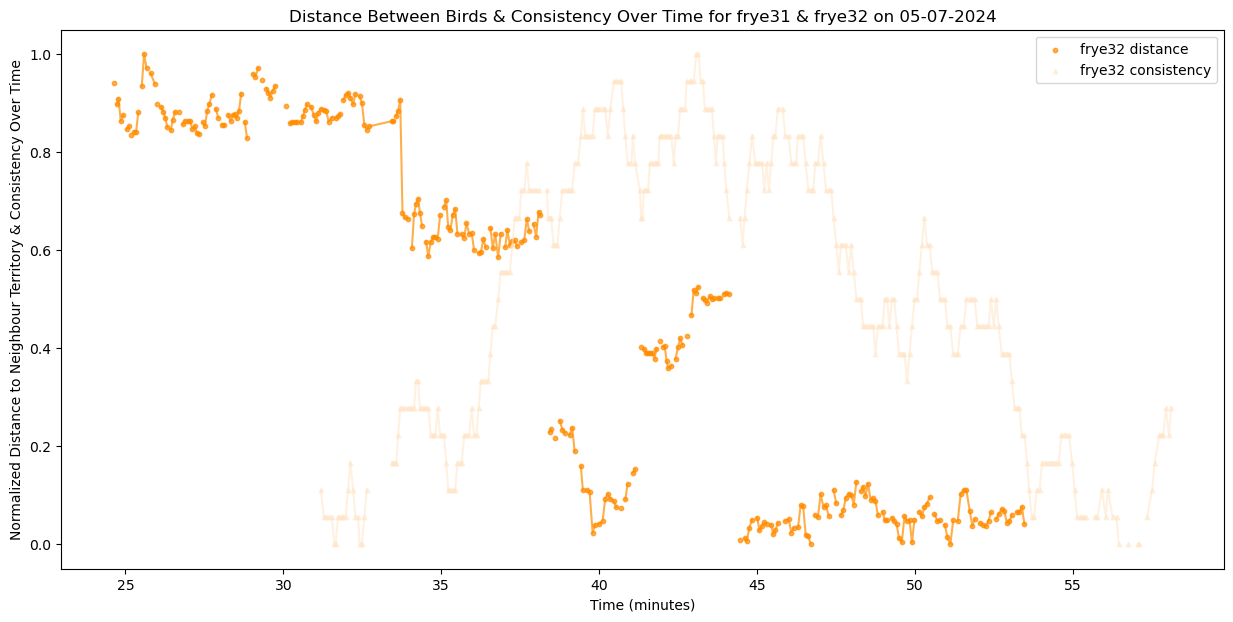

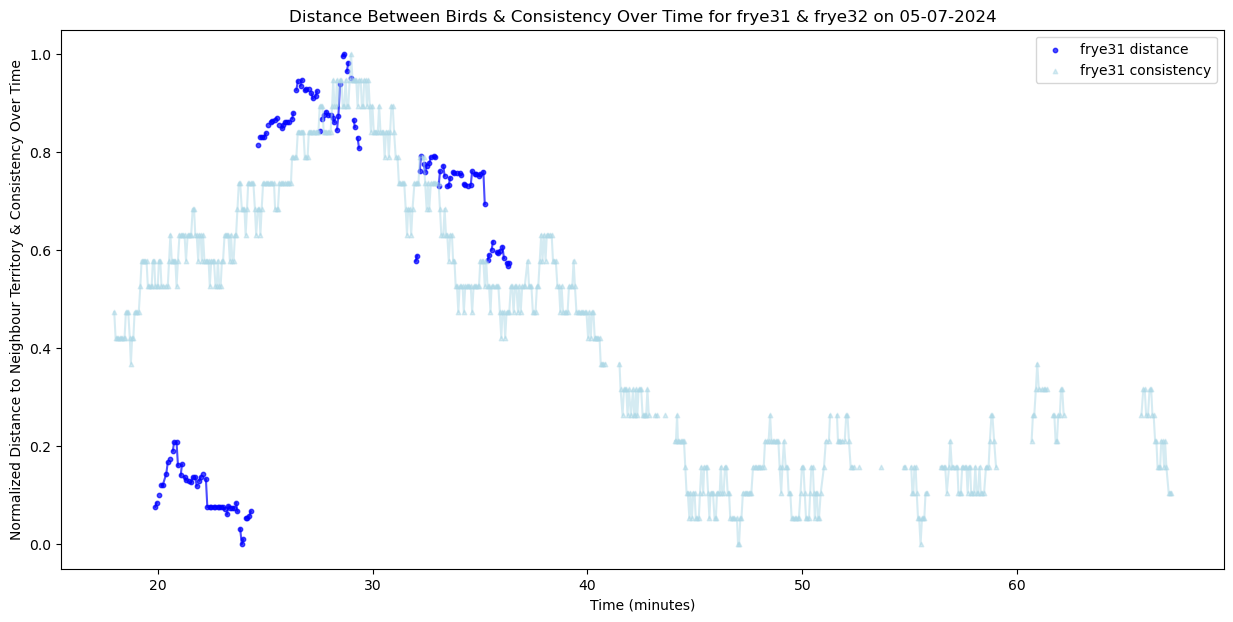

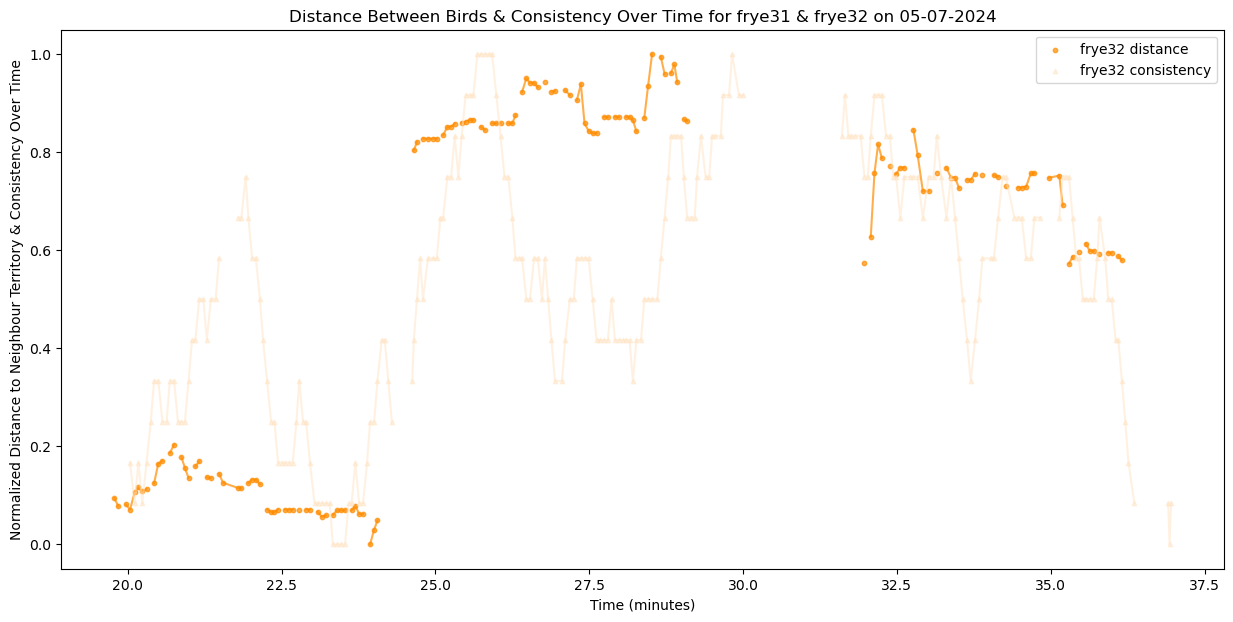

In [120]:
#   compare_freq_diffs(big_df)

for big_df in big_dfs:
    birds = big_df['BirdID'].unique()
    if 'frye1' in birds and 'frye3' in birds and 'frye4' in birds:
        birds = ['frye3', 'frye4']
    #plot_cur_consistency_vs_global_consistency(big_df)
    #timing_str = 'F '
    #plot_consistency_vs_global_consistency(big_df, timing_str)
    #plot_noncom_vs_distance(big_df)
    plot_dot_consistency_vs_distance(big_df, birds[0], birds[1])
    #plot_dot_consistency_vs_territory_distance(big_df)
    #cons_array, times_arr = plot_dot_consistency_vs_territory_distance_vs_matching(big_df)
    #all_cons.append(cons_array)
    #all_times.append(times_arr)
    

In [128]:
matches

[{'% low songs out of all songs': 0.8498498498498499,
  '% high songs out of all songs': 0.15015015015015015,
  '# of low songs': 566,
  '# of high songs': 100,
  '# of low low': 185,
  '# of high high': 6,
  '# of low high': 39,
  '# of high low': 54,
  '% of LM out of possible LM': 0.8258928571428571,
  '% of HM out of possible HM': 0.1},
 {'% low songs out of all songs': 0.7612456747404844,
  '% high songs out of all songs': 0.23875432525951557,
  '# of low songs': 220,
  '# of high songs': 69,
  '# of low low': 176,
  '# of high high': 6,
  '# of low high': 58,
  '# of high low': 30,
  '% of LM out of possible LM': 0.7521367521367521,
  '% of HM out of possible HM': 0.16666666666666666},
 {'% low songs out of all songs': 0.811965811965812,
  '% high songs out of all songs': 0.18803418803418803,
  '# of low songs': 380,
  '# of high songs': 88,
  '# of low low': 255,
  '# of high high': 7,
  '# of low high': 68,
  '# of high low': 78,
  '% of LM out of possible LM': 0.78947368421052

In [422]:
big_df

BirdID    RecA Time RecID   OGRec Time              OG Location  \
0     frye3  1145.371709    H6   650.270288       [-7.5, -47.5, 0.0]   
1     frye3  1150.491060    H6   655.386996  [130.0, -1.25, 29.0625]   
2     frye3  1159.063597    H6   663.955108                    [nan]   
3     frye3  1164.290754    H6   669.179566    [8.75, -45.0, 6.5625]   
4     frye3  1168.659254    H6   673.545811                    [nan]   
...     ...          ...   ...          ...                      ...   
1606  frye1  6480.113524    H1  2476.361089    [27.5, 51.25, 0.9375]   
1607  frye1  6484.527575    H1  2480.772854                      NaN   
1608  frye1  6488.128510    H1  2484.371925   [26.25, 48.75, 0.9375]   
1609  frye1  6493.634457    H1  2489.875021      [26.25, 51.25, 0.0]   
1610  frye1  6504.203166    H1  2500.438257      [27.5, 50.0, 1.125]   

               Good Location  \
0         [-7.5, -47.5, 0.0]   
1                      [nan]   
2                      [nan]   
3                      [nan]   
4                      [nan]   
...                      ...   
1606   [27.5, 51.25, 0.9375]   
1607                     NaN   
1608  [26.25, 48.75, 0.9375]   
1609     [26.25, 51.25, 0.0]   
1610     [27.5, 50.0, 1.125]   

                                           Av Location  Had OG  Leashed  \
0        [-3.285774070642069, -45.69700779450558, 0.0]       1        0   
1      [-2.4907841229505743, -45.269505919739714, 0.0]       1        0   
2      [-2.4907841229505743, -45.269505919739714, 0.0]       0        0   
3      [-2.4907841229505743, -45.269505919739714, 0.0]       1        0   
4      [-2.4907841229505743, -45.269505919739714, 0.0]       0        0   
...                                                ...     ...      ...   
1606  [27.083333333333332, 50.833333333333336, 1.6875]       1        0   
1607                                               NaN       0        0   
1608   [26.666666666666668, 50.416666666666664, 0.625]       1        0   
1609                [26.666666666666668, 50.0, 0.6875]       1        0   
1610                          [26.875, 50.625, 0.5625]       1        0   

      Bifabs  ...  Gl Consistency Freq Transition  Potential Match Type  \
0          0  ...             NaN             nan                   nan   
1          1  ...             NaN             nan                   nan   
2          1  ...             NaN             nan                   nan   
3          1  ...             NaN             nan                   nan   
4          1  ...             NaN             nan                   nan   
...      ...  ...             ...             ...                   ...   
1606       0  ...             0.4             nan                   nan   
1607       0  ...             0.4             nan                   nan   
1608       0  ...             0.4             nan                   nan   
1609       0  ...             NaN             nan                   nan   
1610       0  ...             NaN             nan                   nan   

      Freq Match  dist to frye3  dist to frye1  dist btw frye3 and frye1  \
0            NaN            NaN            NaN                       NaN   
1            NaN            NaN            NaN                       NaN   
2            NaN            NaN            NaN                       NaN   
3            NaN            NaN            NaN                       NaN   
4            NaN            NaN            NaN                       NaN   
...          ...            ...            ...                       ...   
1606         NaN            NaN            NaN                       NaN   
1607         NaN            NaN            NaN                       NaN   
1608         NaN            NaN            NaN                       NaN   
1609         NaN            NaN            NaN                       NaN   
1610         NaN            NaN            NaN                       NaN   

      frye3 dist to frye1 center frye1 d

################# 07-07-2023 #################
Pearson r:  -0.42532632856626973 p value:  7.399759004588153e-09


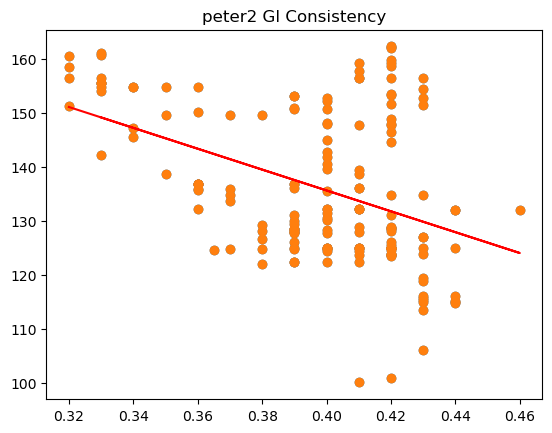

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     37.10
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           7.40e-09
Time:                        16:00:55   Log-Likelihood:                -673.68
No. Observations:                 170   AIC:                             1351.
Df Residuals:                     168   BIC:                             1358.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        213.0984     12.673     16.815      0.0

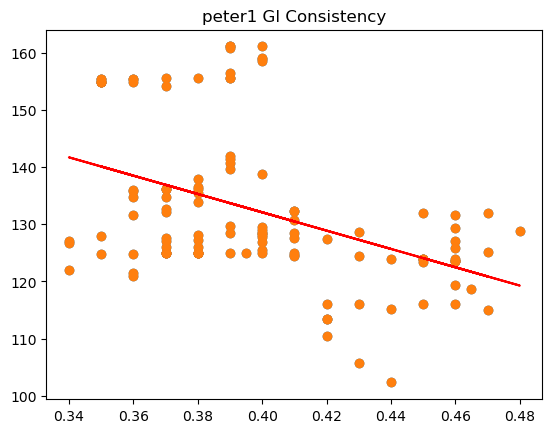

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     26.87
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           9.23e-07
Time:                        16:00:55   Log-Likelihood:                -465.05
No. Observations:                 119   AIC:                             934.1
Df Residuals:                     117   BIC:                             939.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        196.1889     12.373     15.856      0.0

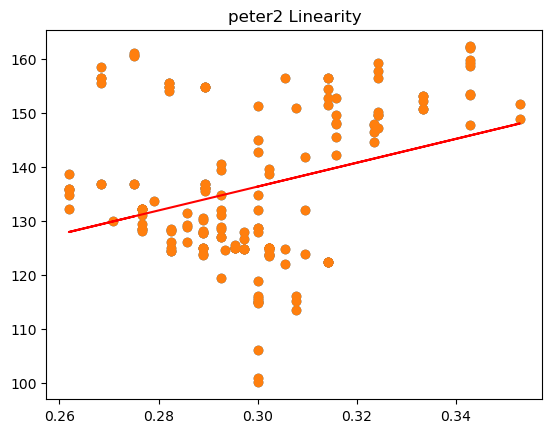

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     19.11
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           2.16e-05
Time:                        16:00:55   Log-Likelihood:                -681.48
No. Observations:                 170   AIC:                             1367.
Df Residuals:                     168   BIC:                             1373.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.9693     15.170      4.612      0.0

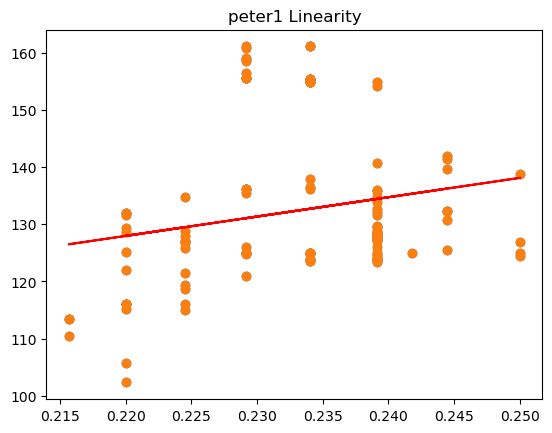

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     5.084
Date:                Wed, 26 Jun 2024   Prob (F-statistic):             0.0260
Time:                        16:00:56   Log-Likelihood:                -474.82
No. Observations:                 119   AIC:                             953.6
Df Residuals:                     117   BIC:                             959.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.5054     34.973      1.530      0.1

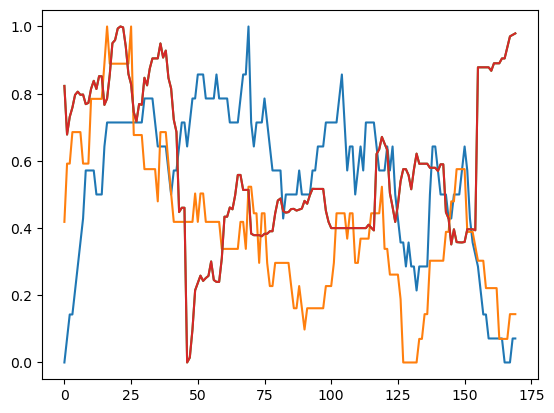

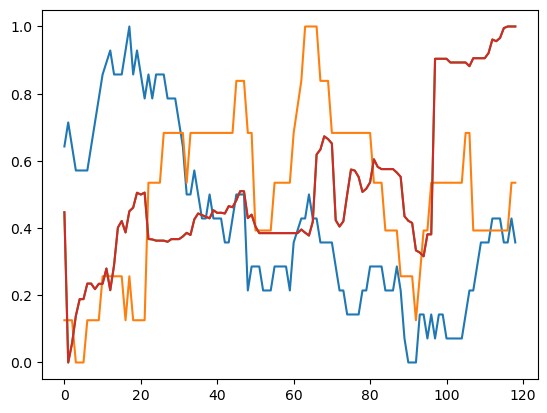

################# 06-11-2023 #################
Pearson r:  -0.4991234115490351 p value:  6.407614665181757e-19


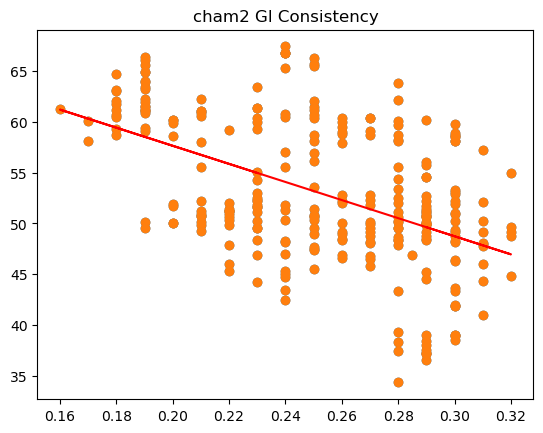

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     91.57
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           6.41e-19
Time:                        16:00:56   Log-Likelihood:                -897.99
No. Observations:                 278   AIC:                             1800.
Df Residuals:                     276   BIC:                             1807.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.4274      2.386     31.610      0.0

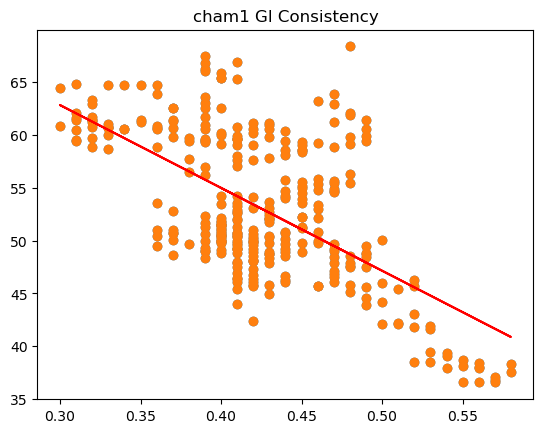

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     212.2
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           2.06e-37
Time:                        16:00:56   Log-Likelihood:                -1028.2
No. Observations:                 330   AIC:                             2060.
Df Residuals:                     328   BIC:                             2068.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.3005      2.303     37.472      0.0

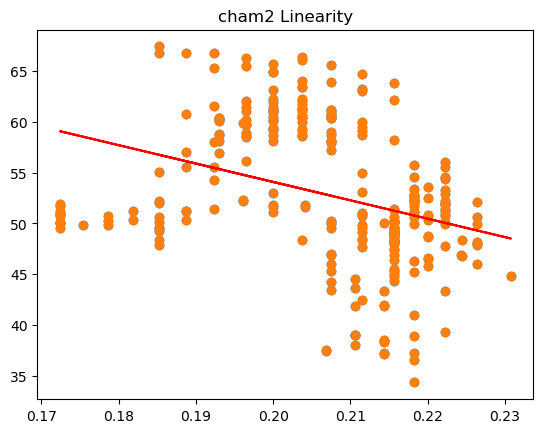

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     35.22
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           8.79e-09
Time:                        16:00:56   Log-Likelihood:                -921.12
No. Observations:                 278   AIC:                             1846.
Df Residuals:                     276   BIC:                             1853.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         90.2401      6.310     14.302      0.0

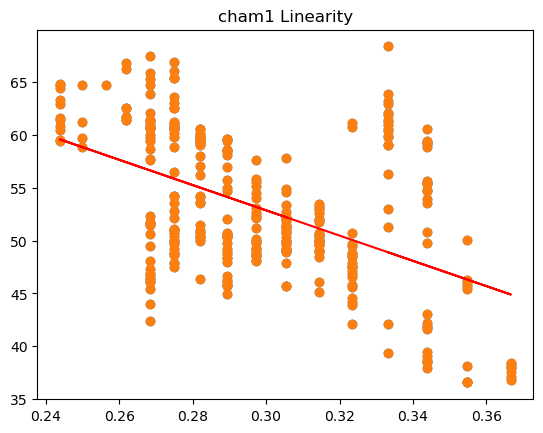

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     110.5
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           1.84e-22
Time:                        16:00:56   Log-Likelihood:                -1062.6
No. Observations:                 330   AIC:                             2129.
Df Residuals:                     328   BIC:                             2137.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.6979      3.409     26.020      0.0

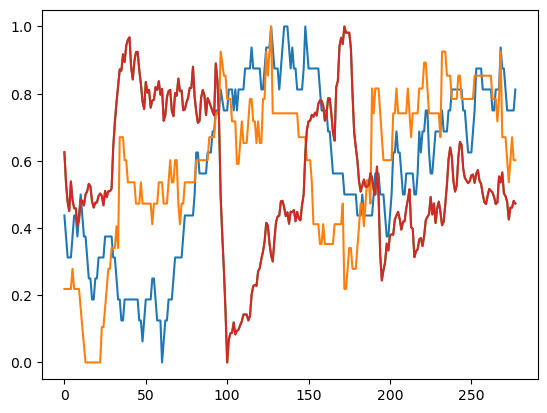

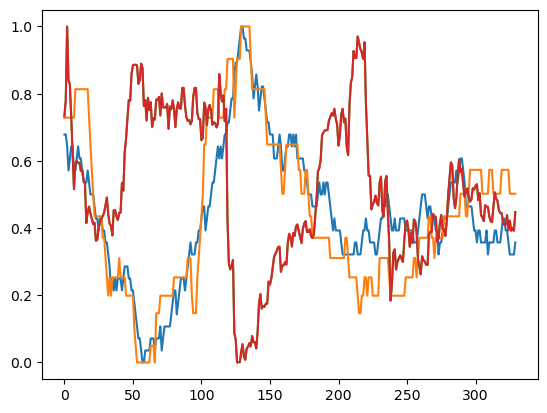

################# 06-22-2023 #################
Pearson r:  -0.41400997104507786 p value:  2.2023583499917795e-08


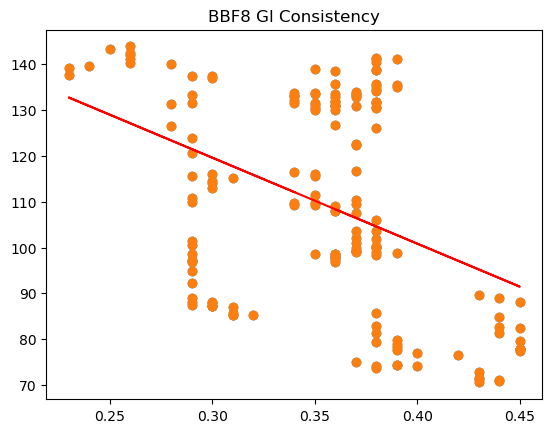

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     34.55
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           2.20e-08
Time:                        16:00:57   Log-Likelihood:                -751.27
No. Observations:                 169   AIC:                             1507.
Df Residuals:                     167   BIC:                             1513.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        175.9121     11.394     15.439      0.0

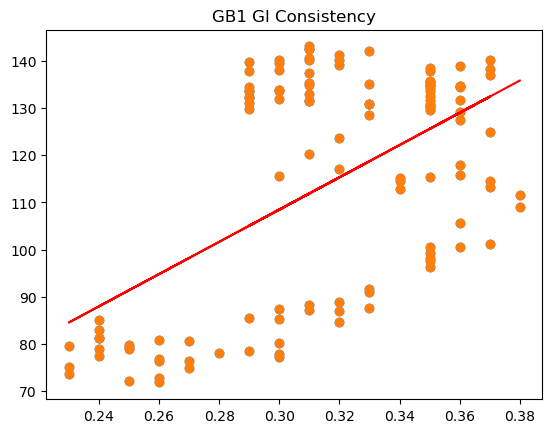

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     51.84
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           6.07e-11
Time:                        16:00:57   Log-Likelihood:                -531.66
No. Observations:                 120   AIC:                             1067.
Df Residuals:                     118   BIC:                             1073.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9614     15.079      0.395      0.6

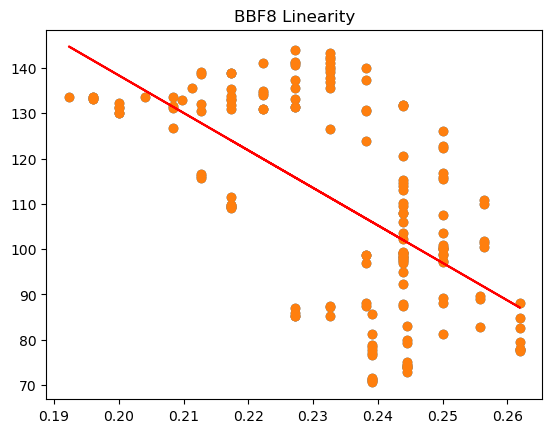

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     95.86
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           3.59e-18
Time:                        16:00:57   Log-Likelihood:                -728.82
No. Observations:                 169   AIC:                             1462.
Df Residuals:                     167   BIC:                             1468.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        304.0788     19.912     15.271      0.0

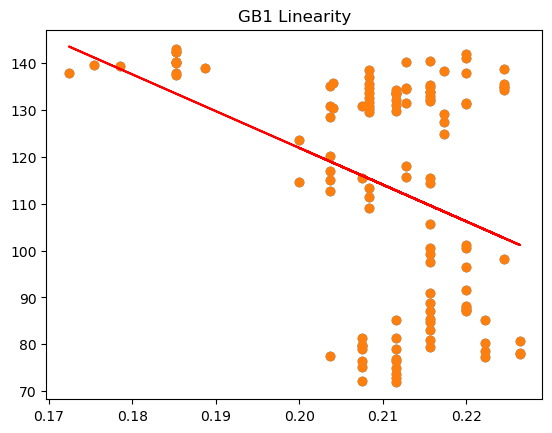

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     17.04
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           6.87e-05
Time:                        16:00:57   Log-Likelihood:                -545.42
No. Observations:                 120   AIC:                             1095.
Df Residuals:                     118   BIC:                             1100.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        278.9285     40.090      6.958      0.0

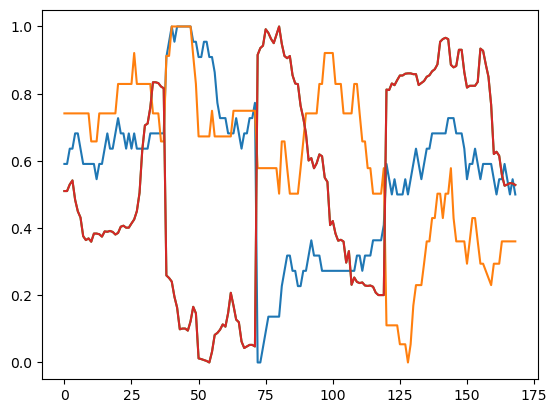

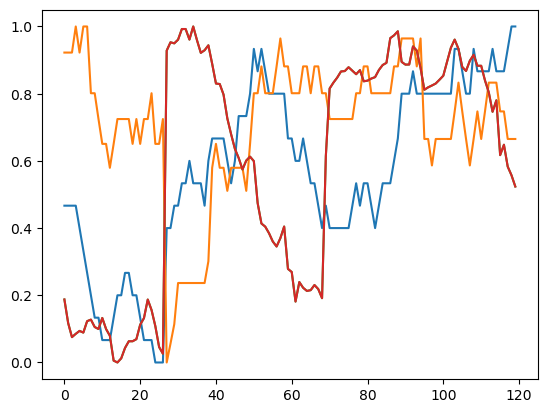

################# 06-23-2023 #################
Pearson r:  0.27851987582938964 p value:  3.779131943134276e-11


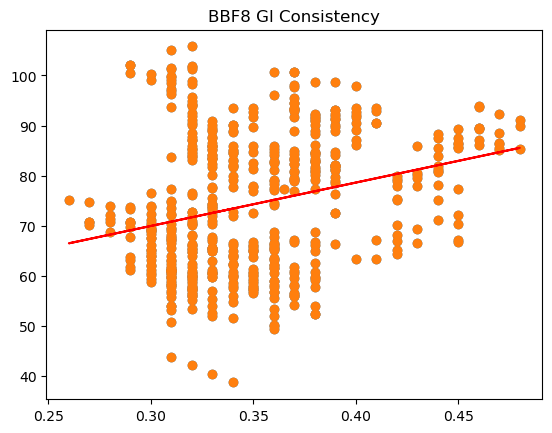

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     45.58
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           3.78e-11
Time:                        16:00:57   Log-Likelihood:                -2169.6
No. Observations:                 544   AIC:                             4343.
Df Residuals:                     542   BIC:                             4352.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.9714      4.537      9.693      0.0

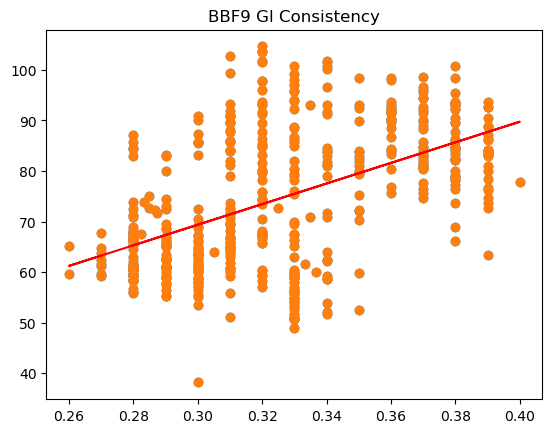

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     175.4
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           2.58e-34
Time:                        16:00:58   Log-Likelihood:                -1856.7
No. Observations:                 479   AIC:                             3717.
Df Residuals:                     477   BIC:                             3726.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1910      5.058      1.619      0.1

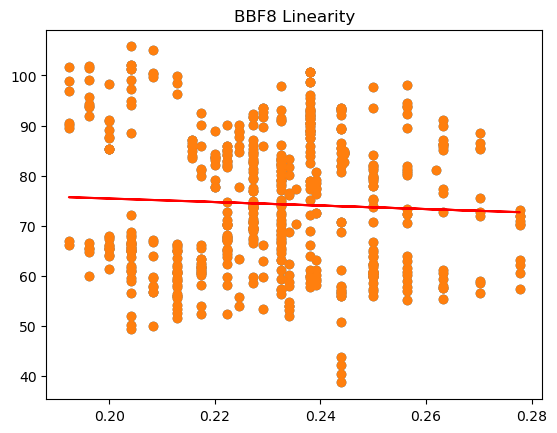

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.325
Date:                Wed, 26 Jun 2024   Prob (F-statistic):              0.250
Time:                        16:00:58   Log-Likelihood:                -2190.9
No. Observations:                 544   AIC:                             4386.
Df Residuals:                     542   BIC:                             4394.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.4366      7.038     11.714      0.0

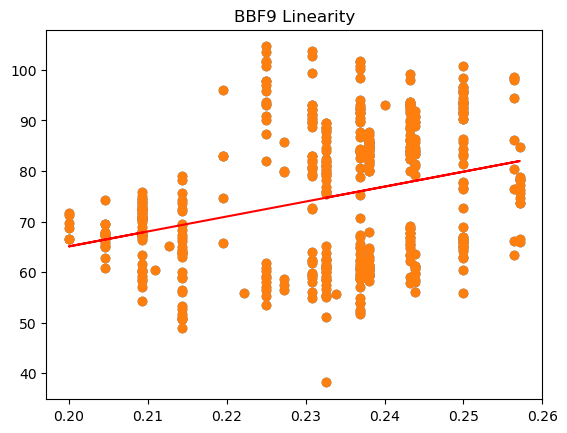

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     49.52
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           6.87e-12
Time:                        16:00:58   Log-Likelihood:                -1908.0
No. Observations:                 479   AIC:                             3820.
Df Residuals:                     477   BIC:                             3828.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9167      9.807      0.603      0.5

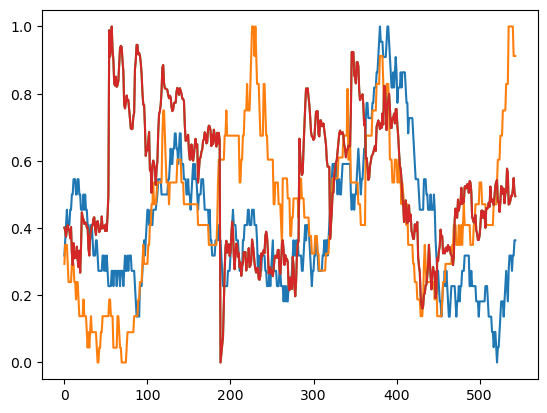

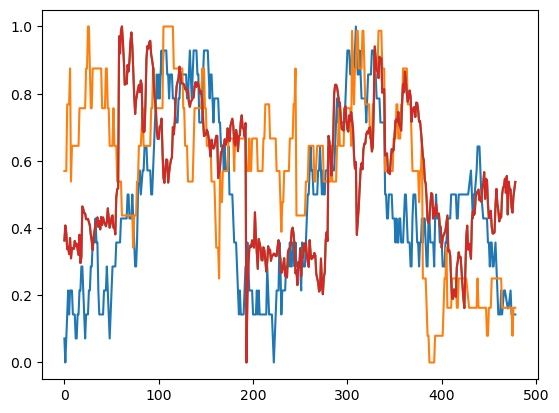

################# 06-09-2023 #################
Pearson r:  -0.31724887055638085 p value:  2.542471635934967e-11


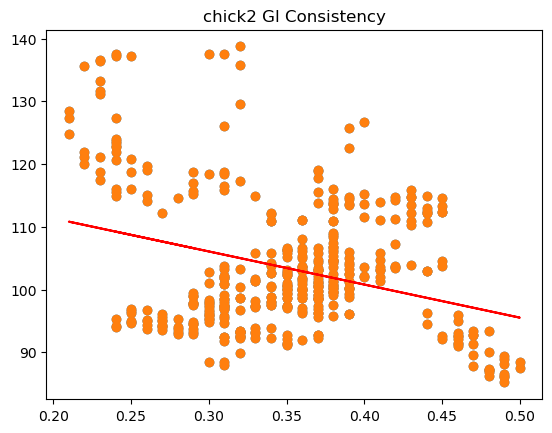

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     47.00
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           2.54e-11
Time:                        16:00:58   Log-Likelihood:                -1577.7
No. Observations:                 422   AIC:                             3159.
Df Residuals:                     420   BIC:                             3168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        121.8936      2.735     44.576      0.0

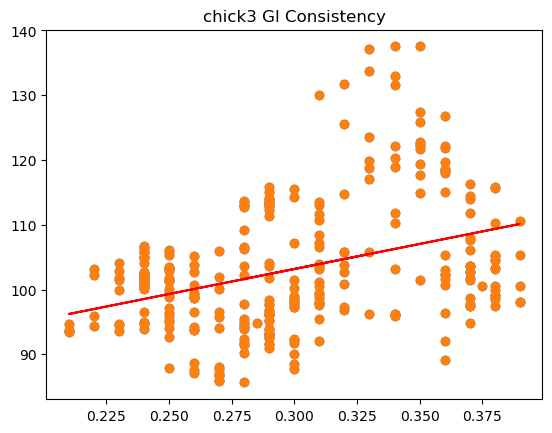

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     47.41
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           3.24e-11
Time:                        16:00:58   Log-Likelihood:                -1131.9
No. Observations:                 310   AIC:                             2268.
Df Residuals:                     308   BIC:                             2275.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.9955      3.394     23.570      0.0

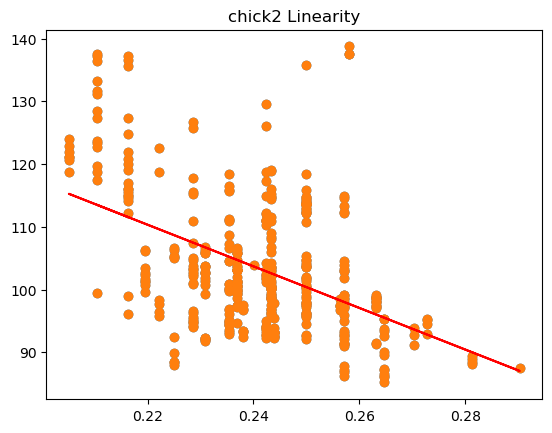

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     120.5
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           8.22e-25
Time:                        16:00:58   Log-Likelihood:                -1546.9
No. Observations:                 422   AIC:                             3098.
Df Residuals:                     420   BIC:                             3106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        183.2513      7.285     25.155      0.0

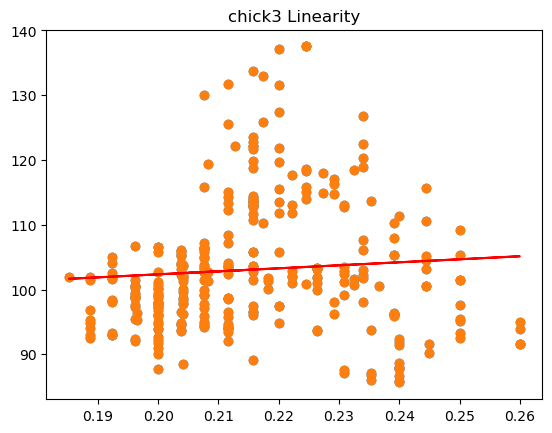

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.833
Date:                Wed, 26 Jun 2024   Prob (F-statistic):              0.177
Time:                        16:00:59   Log-Likelihood:                -1153.2
No. Observations:                 310   AIC:                             2310.
Df Residuals:                     308   BIC:                             2318.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         93.0436      7.434     12.516      0.0

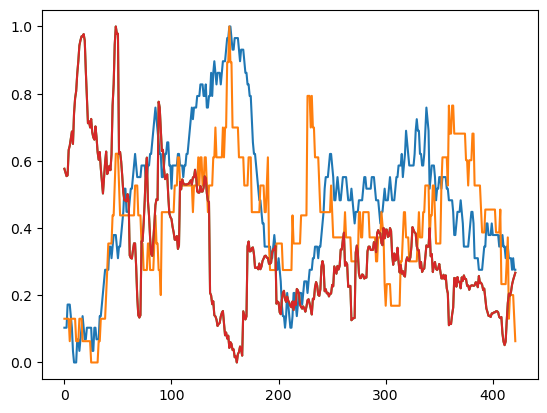

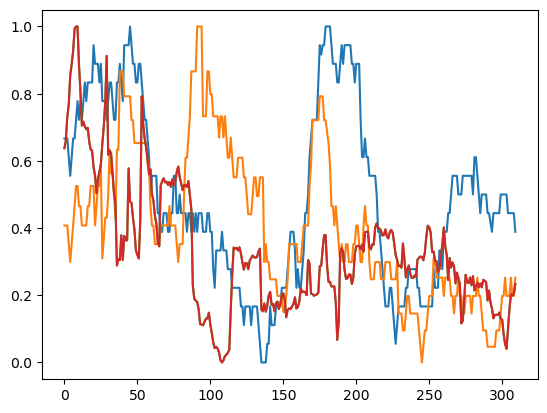

################# 04-22-2024 #################
Pearson r:  0.3261500606034043 p value:  1.2609448846013647e-14


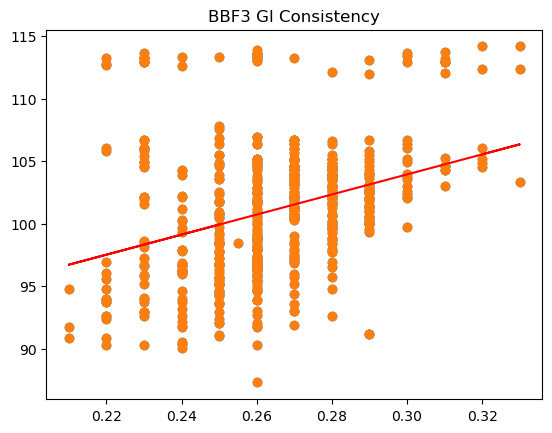

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     62.97
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           1.26e-14
Time:                        16:00:59   Log-Likelihood:                -1623.4
No. Observations:                 531   AIC:                             3251.
Df Residuals:                     529   BIC:                             3259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.8684      2.676     29.846      0.0

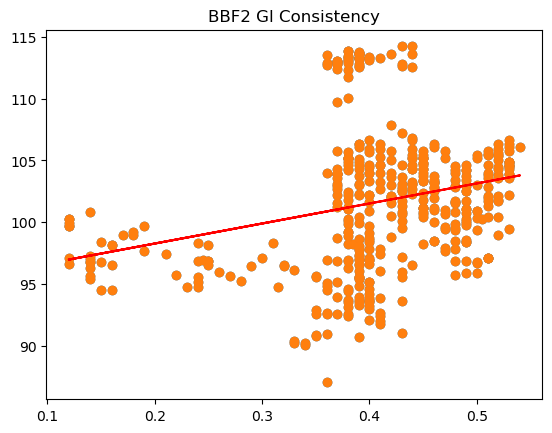

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     32.10
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           2.64e-08
Time:                        16:00:59   Log-Likelihood:                -1379.8
No. Observations:                 444   AIC:                             2764.
Df Residuals:                     442   BIC:                             2772.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0466      1.183     80.356      0.0

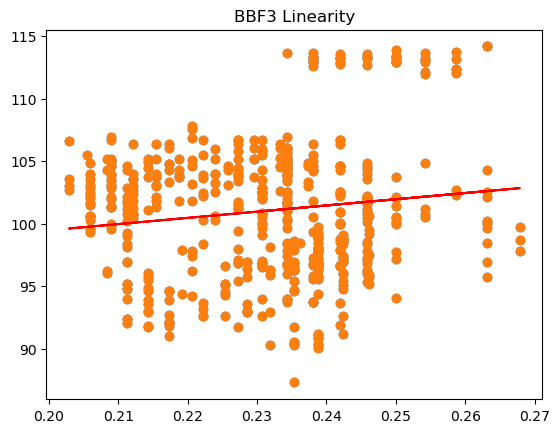

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     9.179
Date:                Wed, 26 Jun 2024   Prob (F-statistic):            0.00257
Time:                        16:00:59   Log-Likelihood:                -1648.7
No. Observations:                 531   AIC:                             3301.
Df Residuals:                     529   BIC:                             3310.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.5250      3.804     23.532      0.0

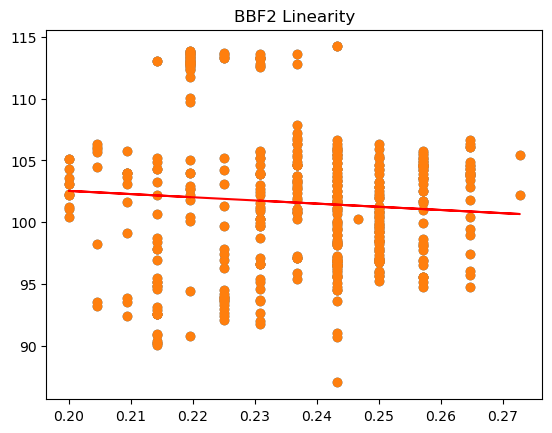

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.549
Date:                Wed, 26 Jun 2024   Prob (F-statistic):              0.111
Time:                        16:00:59   Log-Likelihood:                -1394.1
No. Observations:                 444   AIC:                             2792.
Df Residuals:                     442   BIC:                             2800.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.6850      3.828     28.128      0.0

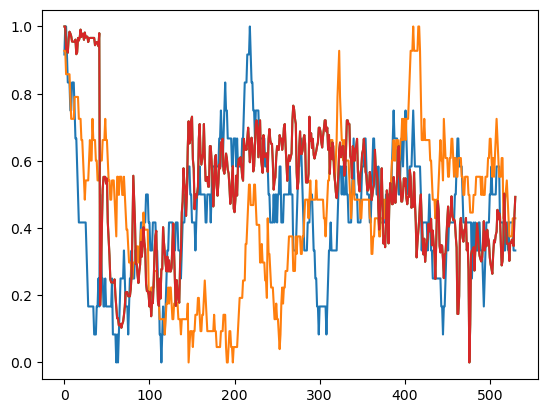

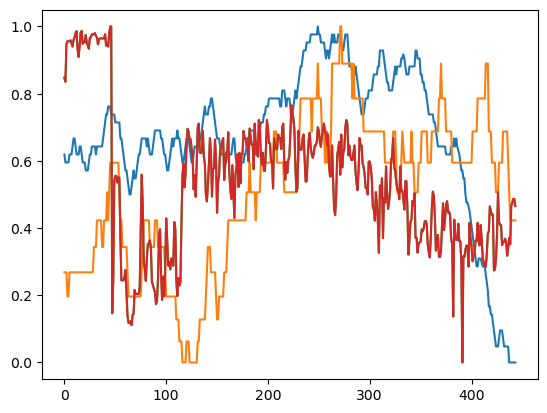

################# 04-26-2024 #################
Pearson r:  0.7973583377256748 p value:  4.873700978458317e-84


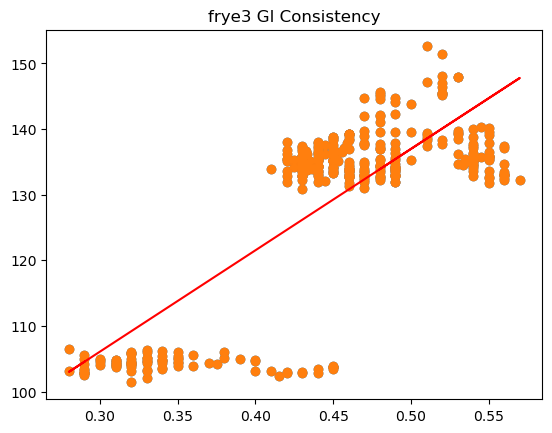

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     652.9
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           4.87e-84
Time:                        16:01:00   Log-Likelihood:                -1331.2
No. Observations:                 376   AIC:                             2666.
Df Residuals:                     374   BIC:                             2674.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7422      2.735     21.841      0.0

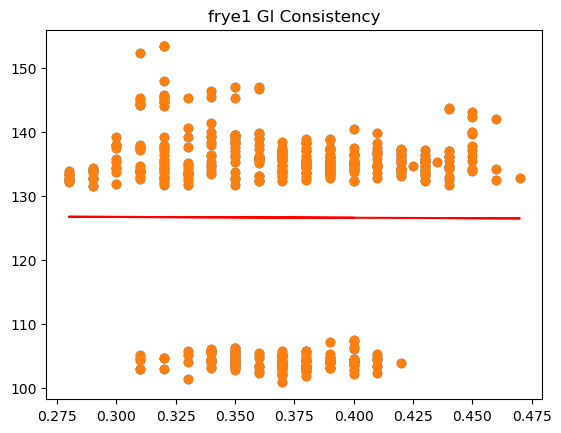

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.006130
Date:                Wed, 26 Jun 2024   Prob (F-statistic):              0.938
Time:                        16:01:00   Log-Likelihood:                -2029.8
No. Observations:                 492   AIC:                             4064.
Df Residuals:                     490   BIC:                             4072.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        127.1185      6.093     20.862      0.0

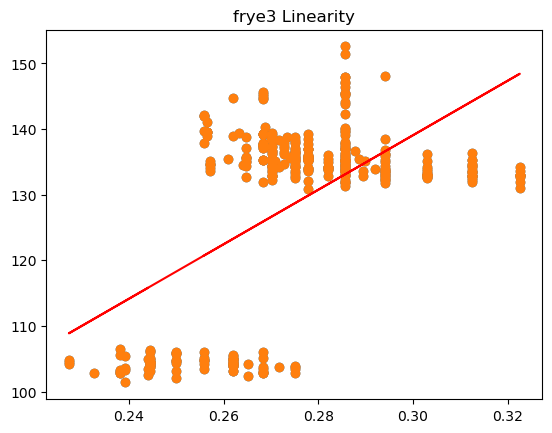

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     185.8
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           1.26e-34
Time:                        16:01:00   Log-Likelihood:                -1445.3
No. Observations:                 376   AIC:                             2895.
Df Residuals:                     374   BIC:                             2902.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.5315      8.401      1.730      0.0

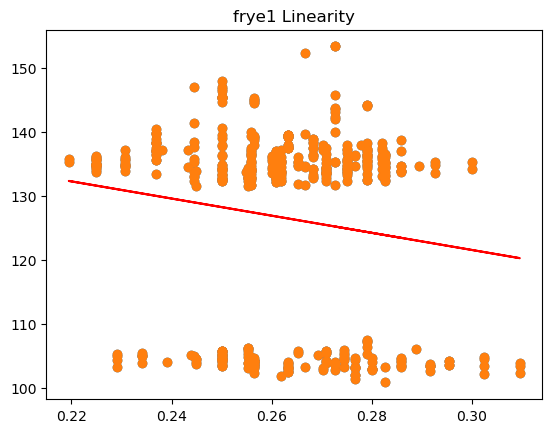

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     11.92
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           0.000605
Time:                        16:01:01   Log-Likelihood:                -2023.9
No. Observations:                 492   AIC:                             4052.
Df Residuals:                     490   BIC:                             4060.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        161.7873     10.203     15.857      0.0

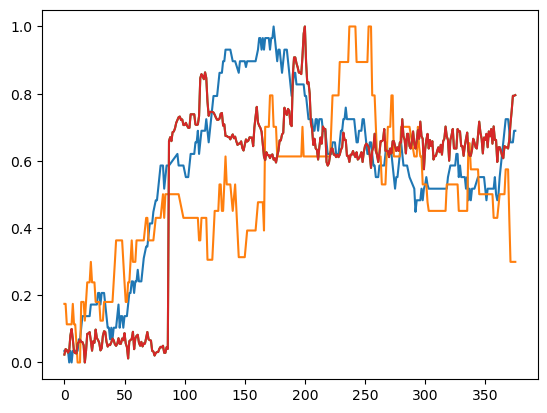

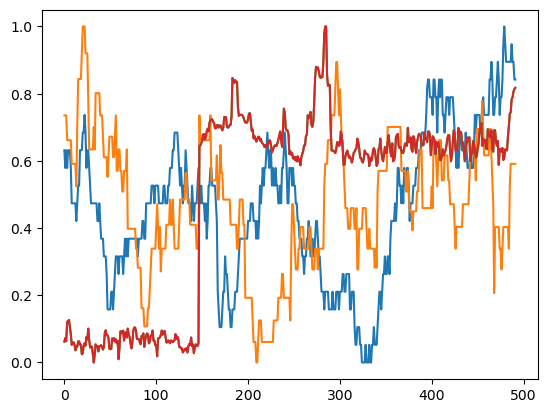

################# 04-27-2024 #################


KeyError: "['dist to frye1'] not in index"

In [101]:
all_rs = []




all_center_con_pearsons = []
all_center_lin_pearsons = []
for i, big_df in enumerate(big_dfs):
    print('#################', dates[i], '#################')
    
    cons_arr, cons_dists_arr, con_pearsons = measure_con_vs_dist(big_df, con_string = 'Gl Consistency', dist_measure='bird')
    lins_arr, lins_dists_arr, lin_pearsons = measure_con_vs_dist(big_df, con_string = 'Linearity', dist_measure='bird')
    for i, cons in enumerate(cons_arr):
        norm_cons = (cons - np.min(cons))/(np.max(cons) - np.min(cons))
        plt.plot(norm_cons)
        norm_con_dist = (cons_dists_arr[i] - np.min(cons_dists_arr[i]))/(np.max(cons_dists_arr[i]) - np.min(cons_dists_arr[i]))
        lins = lins_arr[i]
        norm_lins = (lins - np.min(lins)) / (np.max(lins) - np.min(lins))
        plt.plot(norm_lins)
        plt.plot(norm_con_dist)
        norm_lin_dist = (lins_dists_arr[i] - np.min(lins_dists_arr[i]))/(np.max(lins_dists_arr[i]) - np.min(lins_dists_arr[i]))
        plt.plot(norm_lin_dist)
        plt.show()
        plt.close()
    all_center_con_pearsons += con_pearsons
    all_center_lin_pearsons += lin_pearsons
                                                                 
                                                                 
plt.plot(all_rs)
plt.show()
plt.close()

# x = cons_arr.flatten()
# y = np.array(dists_arr).flatten()
# corr_coef, p_value = pearsonr(x, y)
# print("Pearson r: ", corr_coef, 'p value: ', p_value)
# xl = sm.add_constant(x)
# plt.hist(x)
# plt.show()
# plt.close()
# plt.hist(y)
# plt.show()
# plt.close()
# model = sm.OLS(y,xl)
# results = model.fit()
# plt.scatter(x, y, alpha=0.1)
# plt.plot(x, x * results.params[1] + results.params[0], 'r')
# plt.show()
# plt.close()
# print(results.summary())

In [103]:
pearson_dict = {'names': birdnames, 'bird consistency r': all_bird_con_pearsons, 'center consistency r': all_center_con_pearsons}
pearson_df = pd.DataFrame.from_dict(pearson_dict)
#fig, ax = plt.subplots(figsize=(15,7))
ax = pearson_df.plot.bar(figsize=(15,7))
for i in range(len(pearson_df)):
    if i % 2 == 0 and i > 0:
        plt.axvline(x = i - .5, color = 'green', linestyle='--', alpha=0.5, label = 'cs pairs')
plt.xticks(range(len(pearson_df)),birdnames)
#plt.yscale('symlog')
plt.xlabel('Bird')

plt.show()

NameError: name 'all_bird_con_pearsons' is not defined

In [102]:
print(len(birdnames), len(all_bird_con_pearsons), len(freq_to_dist_pearsons), len(con_to_freq_pearsons))

NameError: name 'all_bird_con_pearsons' is not defined

In [100]:
pearson_dict = {'names': birdnames, 'cons to dist r': all_center_con_pearsons, 'freq matching to dist r': freq_to_dist_pearsons, 'con to freq matching r': con_to_freq_pearsons}
pearson_df = pd.DataFrame.from_dict(pearson_dict)
#fig, ax = plt.subplots(figsize=(15,7))
ax = pearson_df.plot.bar(figsize=(15,7))
for i in range(len(pearson_df)):
    if i % 2 == 0 and i > 0:
        plt.axvline(x = i - .5, color = 'green', linestyle='--', alpha=0.5, label = 'cs pairs')
plt.xticks(range(len(pearson_df)),birdnames)
#plt.yscale('symlog')
plt.xlabel('Bird')
plt.title('Correlations between Consistency, Freq Matching, and Distance')
plt.show()

NameError: name 'all_center_con_pearsons' is not defined

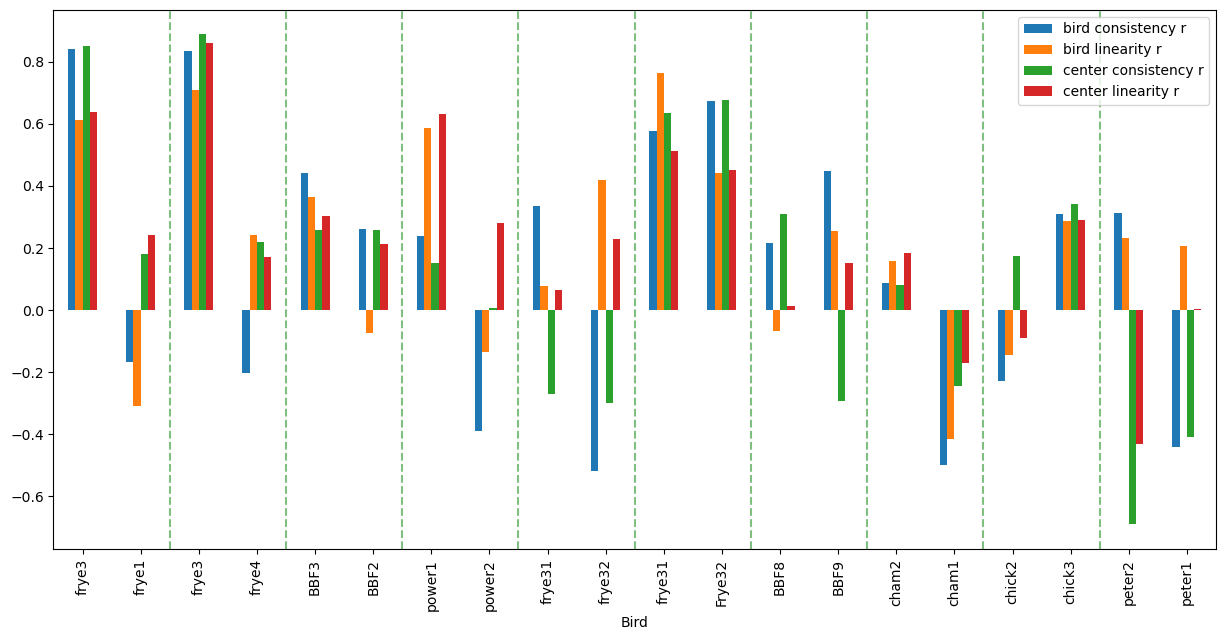

In [290]:
pearson_dict = {'names': birdnames, 'bird consistency r': all_bird_con_pearsons, 'bird linearity r': all_bird_lin_pearsons, 'center consistency r': all_center_con_pearsons, 'center linearity r': all_center_lin_pearsons}
pearson_df = pd.DataFrame.from_dict(pearson_dict)
#fig, ax = plt.subplots(figsize=(15,7))
ax = pearson_df.plot.bar(figsize=(15,7))
for i in range(len(pearson_df)):
    if i % 2 == 0 and i > 0:
        plt.axvline(x = i - .5, color = 'green', linestyle='--', alpha=0.5, label = 'cs pairs')
plt.xticks(range(len(pearson_df)),birdnames)
#plt.yscale('symlog')
plt.xlabel('Bird')

plt.show()

In [273]:



birds = big_df['BirdID'].unique()
for bird in birds:
    all_dfs = []
    bird_df = big_df[big_df['BirdID'] == bird].copy()
    old_locs, new_locs = interpolate_locations(bird_df)
    #print(new_locs)
    bird_df['Int X'] = new_locs[:, 0]
    bird_df['Int Y'] = new_locs[:, 1]
    all_dfs.append(bird_df)
big_df = pd.concat(all_dfs)
big_df = big_df.sort_values('RecA Time')
#big_df[['Int X', 'Int Y']]

(289, 2)


In [387]:
#column_names = list(big_df.columns.values)
big_df[['BirdID', 'RecA Time', 'ID', 'High', 'Potential Match Type', 'Freq Match', 'Exp Proportion']].iloc[300:350]

BirdID    RecA Time ID  High Potential Match Type  Freq Match  \
300  peter1  3219.225714  B   0.0                  low         1.0   
301  peter2  3220.191139  D   0.0                  low         1.0   
302  peter1  3223.163041  I   1.0                  low         0.0   
303  peter2  3223.975980  B   0.0                 high         0.0   
304  peter1  3226.353786  D   0.0                  low         1.0   
305  peter2  3228.480636  I   1.0                  low         0.0   
306  peter2  3231.684979  C   0.0                  low         1.0   
307  peter1  3231.793164  F   0.0                  nan         NaN   
308  peter1  3235.015017  A   0.0                  low         1.0   
309  peter2  3235.121521  F   0.0                  nan         NaN   
310  peter1  3238.494618  G   0.0                  low         1.0   
311  peter2  3238.836702  A   0.0                  low         1.0   
312  peter1  3241.969776  C   0.0                  low         1.0   
313  peter2  3242.667982  H   0.0                  low         1.0   
314  peter2  3246.267063  E   0.0                  low         1.0   
315  peter1  3249.515578  E   0.0                  low         1.0   
316  peter2  3249.633945  B   0.0                  nan         NaN   
317  peter1  3253.248484  I   1.0                  low         0.0   
318  peter2  3253.883183  D   0.0                 high         0.0   
319  peter2  3257.969882  A   0.0                 high         0.0   
320  peter1  3260.341005  H   1.0                  low         0.0   
321  peter2  3262.103020  J   1.0                 high         1.0   
322  peter1  3263.656181  D   0.0                 high         0.0   
323  peter2  3265.469902  B   0.0                  low         1.0   
324  peter2  3269.092203  F   0.0                  low         1.0   
325  peter1  3269.353306  F   0.0                  nan         NaN   
326  peter1  3272.552939  K   1.0                  low         0.0   
327  peter2  3273.178902  C   0.0                 high         0.0   
328  peter1  3275.619255  E   0.0                  low         1.0   
329  peter2  3277.428140  I   1.0                  low         0.0   
330  peter1  3278.978870  C   0.0                 high         0.0   
331  peter2  3281.189760  D   0.0                  low         1.0   
332  peter1  3282.933973  G   0.0                  low         1.0   
333  peter2  3284.881721  A   0.0                  low         1.0   
334  peter1  3287.146823  A   0.0                  low         1.0   
335  peter2  3288.596901  H   0.0                  low         1.0   
336  peter2  3291.731585  E   0.0                  low         1.0   
337  peter1  3292.204022  F   0.0                  low         1.0   
338  peter2  3295.818283  B   0.0                  low         1.0   
339  peter1  3296.399097  B   0.0                  low         1.0   
340  peter2  3299.603124  C   0.0                  low         1.0   
341  peter1  3300.052012  H   1.0                  low         0.0   
342  peter1  3303.296085  D   0.0                  low         1.0   
343  peter2  3303.620162  F   0.0                  low         1.0   
344  peter2  3307.753301  A   0.0                  low         1.0   
345  peter1  3307.944441  I   1.0                  nan         NaN   
346  peter1  3311.837329  A   0.0                  low         1.0   
347  peter2  3312.861674  J   1.0                  low         0.0   
348  peter1  3315.428028  G   0.0                 high         0.0   
349  peter2  3315.949918  D   0.0                  low         1.0   

     Exp Proportion  
300        0.816475  
301        0.816475  
302        0.183525  
303        0.816475  
304        0.816475  
305        0.183525  
306        0.816475  
307        0.816475  
308        0.816475  
309        0.816475  
310        0.816475  
311        0.816475  
312        0.816475  
313        0.816475  
314        0.816475  
315        0.816475  
316        0.816475  
317        0.183525  
318        0.816

In [142]:
def get_expected_freq_match(bird_df):
    highs = bird_df['High'].to_numpy()
    print(f"nanmean of highs {np.nanmean(highs)}")
    high_uniques, high_counts = np.unique(highs, return_counts=True)
    print(high_uniques, high_counts)
    low_prop = high_counts[0] / (high_counts[0] + high_counts[1])
    print(f"low prop: {low_prop}")
    
    high_prop = high_counts[1] / (high_counts[0] + high_counts[1])
    print(f"high prop: {high_prop}")
    pot_matches = bird_df['Potential Match Type'].to_numpy()
    pot_uniques, pot_counts = np.unique(pot_matches, return_counts = True)
    print(pot_uniques, pot_counts)
    expected_matches = (pot_counts[0] * high_prop + pot_counts[1] * low_prop) / (pot_counts[0] + pot_counts[1])
    print(expected_matches)
    print('-----------------')
    return expected_matches

def alt_get_expected_freq_match(bird_df):
    filtered_df = bird_df[bird_df[['Freq Match']].notnull().all(1)]
    exp_props = filtered_df['Exp Proportion'].to_numpy()
    exp_uniques, exp_counts = np.unique(exp_props, return_counts = True)
    print(exp_uniques, exp_counts)
    print(f"len of exp_props: {len(exp_props)}")
    return np.nanmean(exp_props)

birds = big_df['BirdID'].unique()
print(birds)
bird_df = big_df[big_df['BirdID'] == birds[0]]
exp_matches = get_expected_freq_match(bird_df)
alt_exp_matches = alt_get_expected_freq_match(bird_df)
print(exp_matches, alt_exp_matches)

['peter2' 'peter1']
nanmean of highs 0.15015015015015015
[0. 1.] [566 100]
low prop: 0.8498498498498499
high prop: 0.15015015015015015
['high' 'low' 'nan'] [ 60 224 382]
0.7020259696316035
-----------------
[0.15015015 0.84984985] [ 45 239]
len of exp_props: 284
0.7020259696316035 0.7389819396861651


nanmean of highs 0.14622641509433962
[0. 1.] [543  93]
low prop: 0.8537735849056604
high prop: 0.14622641509433962
['high' 'low' 'nan'] [140 385 111]
0.6650943396226414
-----------------
[0.14622642 0.85377358] [ 81 444]
len of exp_props: 525
0.6650943396226414 0.7446091644204851
nanmean of highs 0.29435897435897435
[0. 1.] [688 287]
low prop: 0.7056410256410256
high prop: 0.29435897435897435
['high' 'low' 'nan'] [ 89 633 253]
0.6549428226436537
-----------------
[0.29435897 0.70564103] [219 503]
len of exp_props: 722
0.6549428226436537 0.5808892677036721


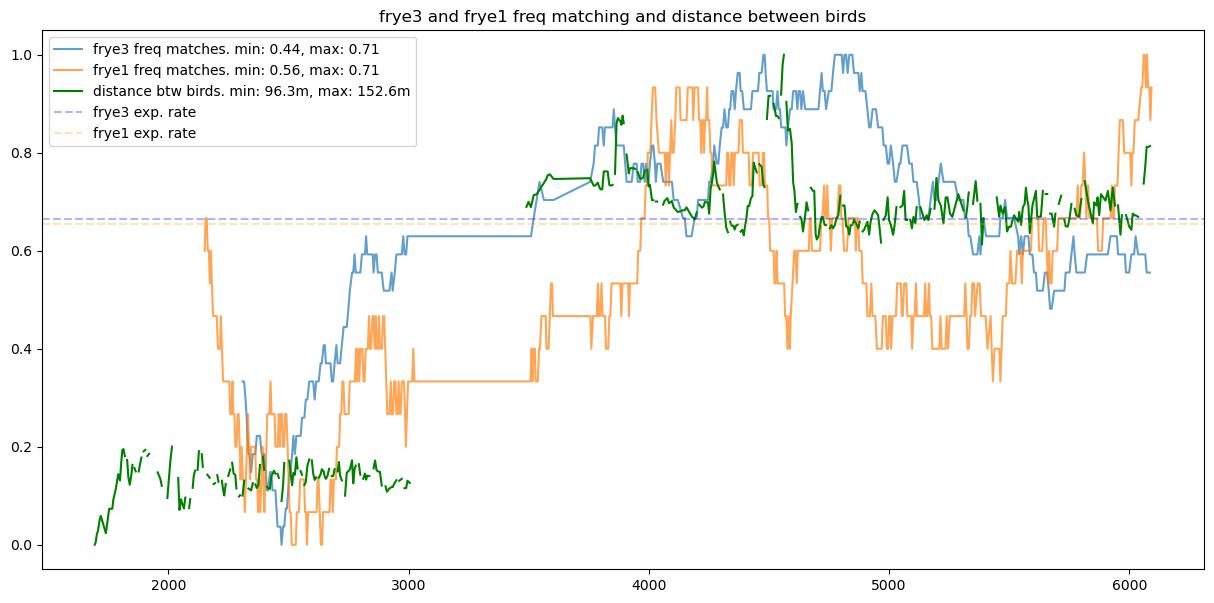

In [409]:
def normalize(arr):
    return (arr - np.nanmin(arr))/(np.nanmax(arr) - np.nanmin(arr))
for big_df in big_dfs:
    all_rs = []
    birds = big_df['BirdID'].unique()
    both_freq_match = []
    both_dists = []
    birds = big_df['BirdID'].unique()

    bird1_df = big_df[big_df['BirdID'] == birds[0]]
    bird1_exp_matches = get_expected_freq_match(bird1_df)
    bird1_alt_exp_matches = alt_get_expected_freq_match(bird1_df)
    print(bird1_exp_matches, bird1_alt_exp_matches)
    bird2_df = big_df[big_df['BirdID'] == birds[1]]
    bird2_exp_matches = get_expected_freq_match(bird2_df)
    bird2_alt_exp_matches = alt_get_expected_freq_match(bird2_df)
    print(bird2_exp_matches, bird2_alt_exp_matches)
    
    bird1_freqs = big_df[big_df['BirdID'] == birds[0]]['Rolling Freq Matches']
    bird2_freqs = big_df[big_df['BirdID'] == birds[1]]['Rolling Freq Matches']
    bird1_times = big_df[big_df['BirdID'] == birds[0]]['RecA Time']
    bird2_times = big_df[big_df['BirdID'] == birds[1]]['RecA Time']
    bird2_dists = big_df[big_df['BirdID'] == birds[1]]['dist to ' + birds[0]]
    bird1_dists = big_df[big_df['BirdID'] == birds[0]]['dist to ' + birds[1]]
    bird2_max = np.nanmax(bird2_freqs)
    bird2_min = np.nanmin(bird2_freqs)
    bird1_max = np.nanmax(bird1_freqs)
    bird1_min = np.nanmin(bird1_freqs)
    dist_max = round(np.nanmax(bird1_dists), 1)
    dist_min = round(np.nanmin(bird1_dists), 1)
    bird2_dists = normalize(bird2_dists)
    bird1_dists = normalize(bird1_dists)
    bird1_freqs = normalize(bird1_freqs)
    bird2_freqs = normalize(bird2_freqs)
    fig, ax = plt.subplots(figsize=(15,7))
    plt.plot(bird1_times, bird1_freqs, alpha=0.7, label=f'{birds[0]} freq matches. min: {bird1_min}, max: {bird1_max}')
    plt.plot(bird2_times, bird2_freqs, alpha=0.7, label=f'{birds[1]} freq matches. min: {bird2_min}, max: {bird2_max}')
    plt.plot(bird1_times, bird1_dists, color = 'green', label=f'distance btw birds. min: {dist_min}m, max: {dist_max}m')
    plt.axhline(y=bird1_exp_matches, alpha=0.3, linestyle='--', color='blue', label=f"{birds[0]} exp. rate")
    plt.axhline(y=bird2_exp_matches, alpha=0.3, linestyle='--',color='orange', label=f"{birds[1]} exp. rate")
    #plt.plot(bird2_times, bird2_dists, color = 'green')
    plt.title(f'{birds[0]} and {birds[1]} freq matching and distance between birds')
    plt.legend()
    plt.savefig(f'freq_matching_and_dist_btw_{birds[0]}_{birds[1]}.png')
    plt.show()
    plt.close()

In [ ]:
old_locs, new_locs = interpolate_locations(big_df, 'frye1')

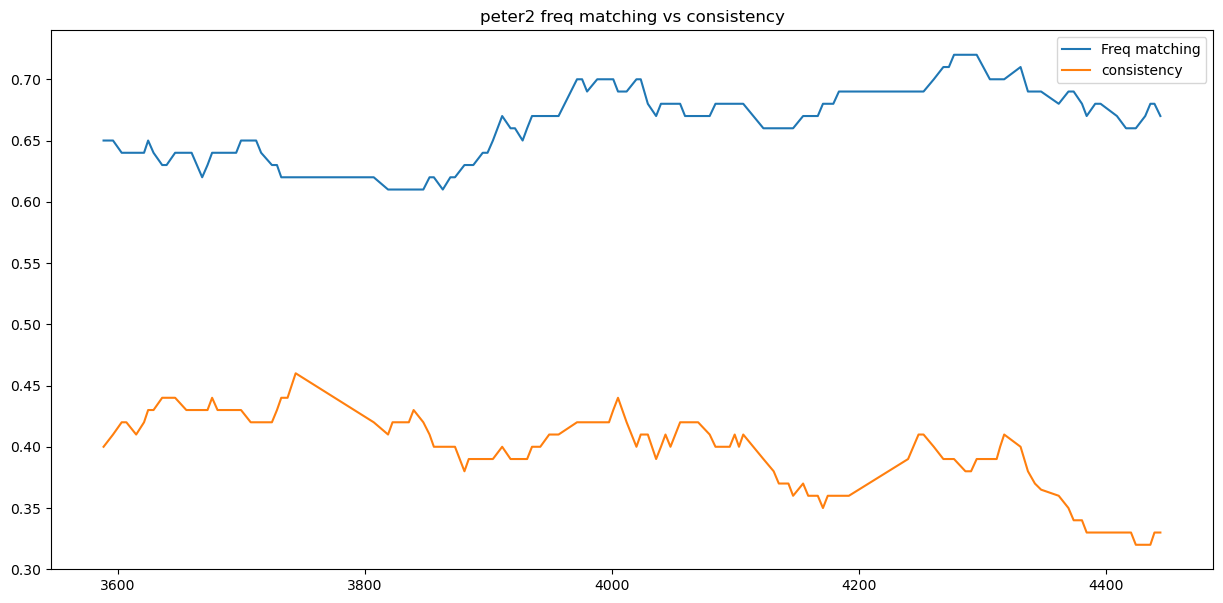

Pearson r:  -0.355305499941448 p value:  3.863395381834927e-05


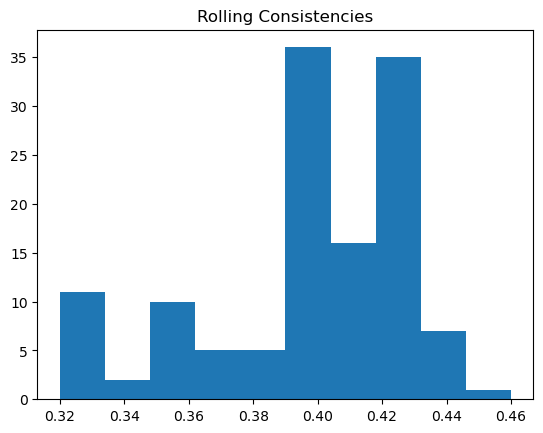

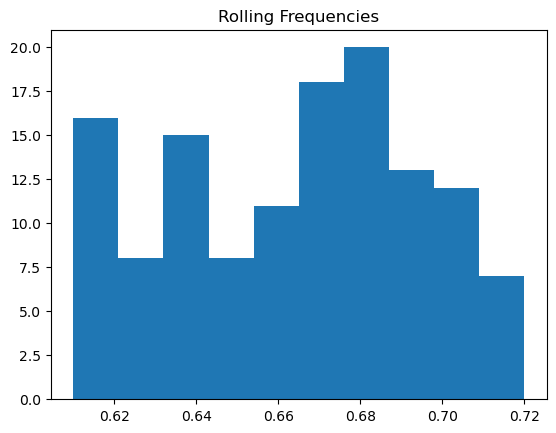

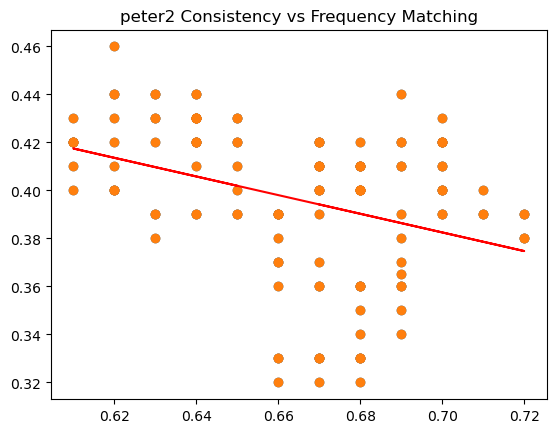

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     18.20
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           3.86e-05
Time:                        18:16:49   Log-Likelihood:                 269.42
No. Observations:                 128   AIC:                            -534.8
Df Residuals:                     126   BIC:                            -529.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6546      0.061     10.813      0.0

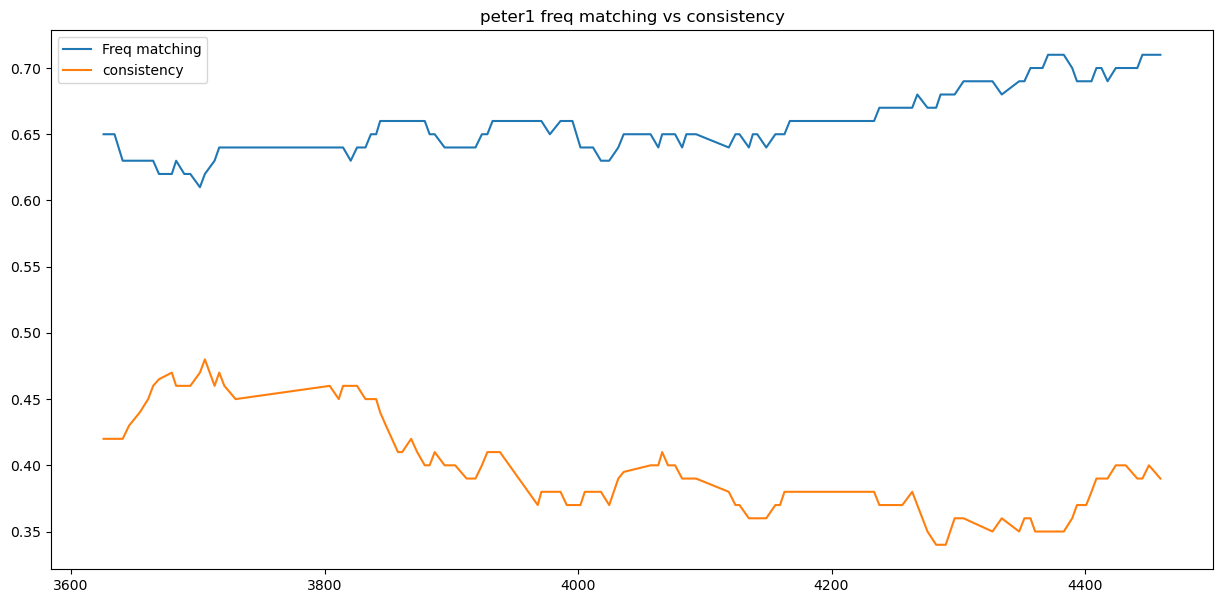

Pearson r:  -0.6030251762579737 p value:  7.887926777844952e-13


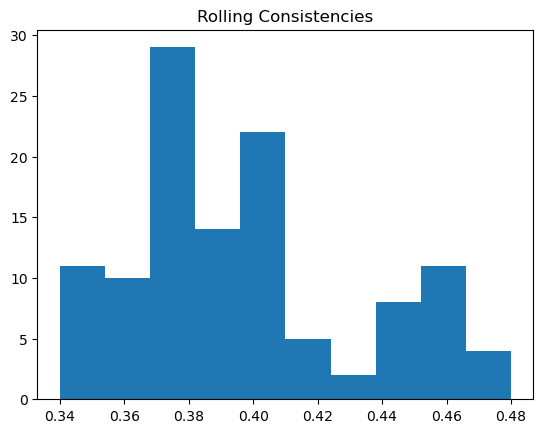

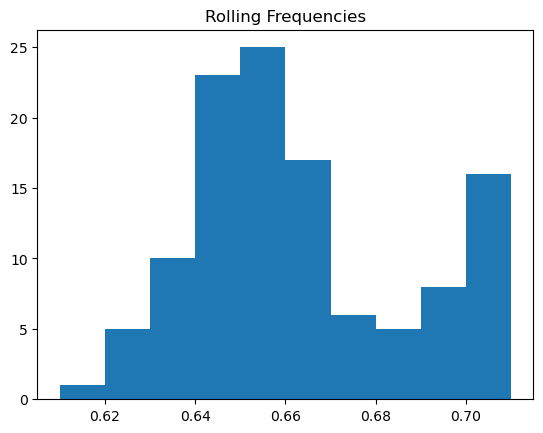

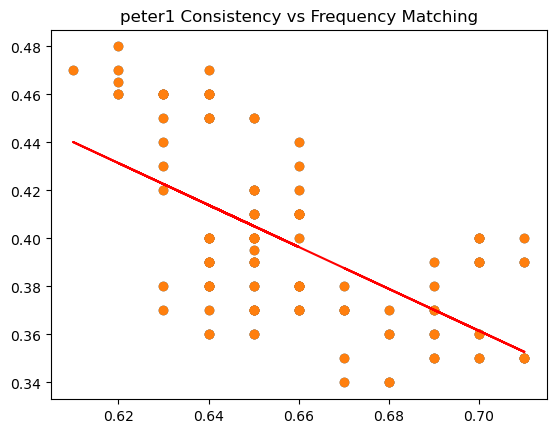

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     65.14
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           7.89e-13
Time:                        18:16:49   Log-Likelihood:                 247.08
No. Observations:                 116   AIC:                            -490.2
Df Residuals:                     114   BIC:                            -484.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9732      0.071     13.638      0.0

NameError: name 'freq_pearsons' is not defined

In [127]:
def get_new_df(big_df, columns, remove_nulls = False):
    new_df = big_df[columns]
    if remove_nulls:
        new_df = new_df[new_df.notnull().all(1)]
    return new_df.copy()


con_to_freq_pearsons = []
for big_df in big_dfs:
    all_rs = []
    birds = big_df['BirdID'].unique()
    both_freq_match = []
    both_dists = []
    for b, bird in enumerate(birds):
        if b > 1:
            break
        if bird == birds[0]:
            bird1 = birds[0]
            bird2 = birds[1]
        else:
            bird1 = birds[1]
            bird2 = birds[0]
    
        bird_df = big_df[big_df['BirdID'] == bird1]
        columns = ['BirdID', 'RecA Time', 'Gl Consistency', 'Rolling Freq Matches', 'dist to ' + bird2]
        bird_df = get_new_df(bird_df, columns)
        bird_df['Gl Consistency'] = bird_df['Gl Consistency'].interpolate(method='linear')
        bird_df = get_new_df(bird_df, columns, True)
        cons = bird_df['Gl Consistency'].to_numpy()
        rolling_freqs = bird_df['Rolling Freq Matches'].to_numpy()
        both_freq_match.append(rolling_freqs)
        times = bird_df['RecA Time'].to_numpy()
        all_times = big_df['RecA Time'].to_numpy()
        fig, ax = plt.subplots(figsize=(15,7))
        plt.plot(times, rolling_freqs, label="Freq matching")
        plt.plot(times, cons, label="consistency")
        #for time in all_times:
            # if big_df[big_df['RecA Time'] == time].iloc[0]['Freq Match'] == 1:
            #     plt.axvline(x = time, ymin = 0.5, ymax = 1, color = 'purple', alpha=0.5, linestyle='solid')
            # if big_df[big_df['RecA Time'] == time].iloc[0]['Freq Match'] == 0:
            #     plt.axvline(x = time, ymin = 0.5, ymax = 1, color = 'gold', alpha=0.5, linestyle='solid')  
            # if big_df[big_df['RecA Time'] == time].iloc[0]['NonCom'] == 1:
            #     plt.axvline(x = time, ymin = 0, ymax = 0.5, color = 'green', alpha=0.5, linestyle='solid')
            # if big_df[big_df['RecA Time'] == time].iloc[0]['NonCom'] == 0:
            #     plt.axvline(x = time, ymin = 0, ymax = 0.5, color = 'brown', alpha=0.5, linestyle='solid')
            # if big_df[big_df['RecA Time'] == time].iloc[0]['NonCom'] == 1 and big_df[big_df['RecA Time'] == time].iloc[0]['Freq Match'] == 1:
            #     plt.axvline(x = time, ymin = 0, ymax = 1, color = 'purple', alpha=0.6, linestyle='solid')
            # if big_df[big_df['RecA Time'] == time].iloc[0]['NonCom'] == 1 and big_df[big_df['RecA Time'] == time].iloc[0]['Freq Match'] == 0:
            #     plt.axvline(x = time, ymin = 0, ymax = 1, color = 'green', alpha=0.6, linestyle='solid')
            # if big_df[big_df['RecA Time'] == time].iloc[0]['NonCom'] == 1:
            #     plt.axvline(x = time, ymin = 0, ymax = 1, color = 'black', alpha=0.3, linestyle='solid')
        
        #plt.xlim([1500, 3000])
        plt.legend()
        plt.title(f"{bird1} freq matching vs consistency")
        plt.show()
        plt.close()
        x = rolling_freqs
        # x = (cons - np.min(cons))/(np.max(cons) - np.min(cons))
        y = cons
        # cons_arr.append(y)
        # freqs_arr.append(x)
        corr_coef, p_value = pearsonr(x, y)
        con_to_freq_pearsons.append(corr_coef)
        print("Pearson r: ", corr_coef, 'p value: ', p_value)
        plt.hist(cons)
        plt.title("Rolling Consistencies")
        plt.show()
        plt.close()
        plt.hist(rolling_freqs)
        plt.title("Rolling Frequencies")
        plt.show()
        plt.close()
        xl = sm.add_constant(x)
        plt.scatter(x, y)
        model = sm.OLS(y,xl)
        results = model.fit()
        plt.scatter(x, y)
        plt.plot(x, x * results.params[1] + results.params[0], 'r')
        plt.title(f"{bird1} Consistency vs Frequency Matching")
        plt.show()
        plt.close()
        print(results.summary())
        all_rs.append(results.rsquared)
    break
print(freq_pearsons)
plt.plot(freq_pearsons)
plt.show()
plt.close()

In [126]:
freq_to_dist_pearsons = []
for big_df in big_dfs:
    all_rs = []
    birds = big_df['BirdID'].unique()
    for b, bird in enumerate(birds):
        if b > 1:
            break
        if bird == birds[0]:
            bird1 = birds[0]
            bird2 = birds[1]
        else:
            bird1 = birds[1]
            bird2 = birds[0]
    
        bird_df = big_df[big_df['BirdID'] == bird1]
        columns = ['BirdID', 'RecA Time', 'dist to ' + bird2, 'Rolling Freq Matches']
        bird_df = get_new_df(bird_df, columns, True)
        dists = bird_df['dist to ' + bird2].to_numpy()
        rolling_freqs = bird_df['Rolling Freq Matches'].to_numpy()
        
        x = dists
        # x = (cons - np.min(cons))/(np.max(cons) - np.min(cons))
        y = rolling_freqs
        # cons_arr.append(y)
        # freqs_arr.append(x)
        corr_coef, p_value = pearsonr(x, y)
        freq_to_dist_pearsons.append(corr_coef)
        print("Pearson r: ", corr_coef, 'p value: ', p_value)
        plt.hist(dists)
        plt.title(f"Distance between {bird1} and {bird2}")
        plt.show()
        plt.close()
        plt.hist(rolling_freqs)
        plt.title("Rolling Frequencies")
        plt.show()
        plt.close()
        xl = sm.add_constant(x)
        plt.scatter(x, y)
        model = sm.OLS(y,xl)
        results = model.fit()
        plt.scatter(x, y)
        plt.plot(x, x * results.params[1] + results.params[0], 'r')
        plt.title(f"{bird1} Consistency vs Frequency Matching")
        plt.show()
        plt.close()
        print(results.summary())
        all_rs.append(results.rsquared)
print(freq_pearsons)
plt.plot(freq_pearsons)
plt.show()
plt.close()

NameError: name 'get_new_df' is not defined

In [287]:
all_rs

[0.17797681298250378, 0.4444372209524621]

In [274]:
print(len(big_dfs))
for big_df in big_dfs:
    plot_rolling_freqs_vs_dist(big_df)
    plot_rolling_freqs_vs_con(big_df)

IndexError: index 1 is out of bounds for axis 0 with size 1

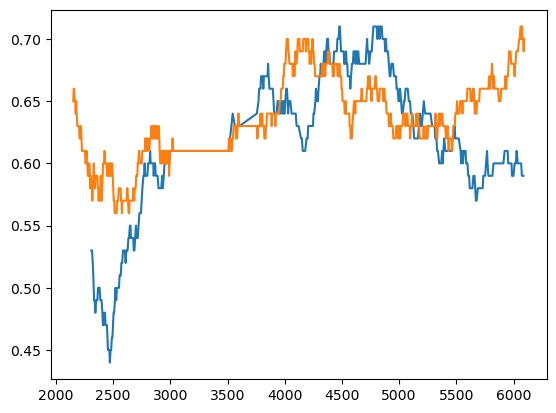

In [237]:

plot_rolling_freqs(big_df)

In [222]:
all_birds = pd.concat(bird_dfs)
all_birds = all_birds.sort_values('RecA Time')
all_birds

BirdID    RecA Time ID Freq Transition Potential Match Type  Freq Match  \
0    peter2  2027.445543  A             nan                  nan         NaN   
1    peter2  2030.353818  H             nan                  nan         NaN   
2    peter2  2032.948025  C             nan                  nan         NaN   
3    peter2  2036.540969  F             nan                  nan         NaN   
4    peter2  2039.392712  B             nan                  nan         NaN   
..      ...          ... ..             ...                  ...         ...   
954  peter2  4809.129284  D             nan                  nan         NaN   
955  peter2  4813.151464  B             nan                  nan         NaN   
956  peter2  4817.663845  F             nan                  nan         NaN   
957  peter2  4824.671236  A             nan                  nan         NaN   
958  peter2  4832.652748  E             nan                  nan         NaN   

     Rolling Freq Matches  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
..                    ...  
954                   NaN  
955                   NaN  
956                   NaN  
957                   NaN  
958                   NaN  

[959 rows x 7 columns]

In [97]:
column_names = list(big_df.columns.values)
column_names

['BirdID',
 'RecA Time',
 'RecID',
 'OGRec Time',
 'OG Location',
 'Good Location',
 'Av Location',
 'Had OG',
 'Leashed',
 'Bifabs',
 'Jumped',
 'ID',
 'Low Freq (Hz)',
 'High Freq (Hz)',
 'Mean Freq (Hz)',
 'High',
 'tsl',
 'Next',
 'Freq Match',
 'dist to peter2',
 'dist to peter1',
 'dist btw peter2 and peter1',
 'peter2 dist to peter1 center',
 'peter1 dist to peter2 center']

In [98]:
big_df.iloc[400:450][['BirdID', 'RecA Time', 'Valid Location', 'Low Freq (Hz)', 'High Freq (Hz)', 'Mean Freq (Hz)', 'ID', 'Next', 'Freq Match', 'dist to peter2', 'dist to peter1', 'dist btw peter2 and peter1']]

BirdID    RecA Time                                        Av Location  \
400  peter2  3422.366621     [-39.98627040353346, -84.102691969432, 0.0625]   
401  peter2  3426.074733                                                NaN   
402  peter1  3428.199403      [65.41666666666667, 22.916666666666668, 11.0]   
403  peter2  3429.100385   [-40.81960373686679, -86.18602530276534, 4.0625]   
404  peter2  3432.258289  [-40.165224861938505, -84.70475926214864, 4.0625]   
405  peter1  3433.621004     [65.41666666666667, 25.416666666666668, 4.875]   
406  peter2  3436.066349   [-40.53963849231524, -85.15680526754345, 4.0625]   
407  peter1  3437.664985                                                NaN   
408  peter2  3439.804749                                                NaN   
409  peter1  3440.420225    [64.58333333333333, 24.166666666666668, 6.6875]   
410  peter2  3443.427050  [-41.01491314589939, -86.71291396823828, 2.03125]   
411  peter1  3444.730843   [60.833333333333336, 20.416666666666668, 12.875]   
412  peter2  3447.235111                                                NaN   
413  peter1  3448.979245                                                NaN   
414  peter2  3449.951836  [-41.01491314589939, -86.71291396823828, 2.03125]   
415  peter1  3452.365524                [61.666666666666664, 21.25, 15.375]   
416  peter2  3453.597357  [-41.01491314589939, -86.71291396823828, 2.03125]   
417  peter1  3456.427281                 [65.0, 24.166666666666668, 13.625]   
418  peter2  3457.614396  [-41.01491314589939, -86.71291396823828, 2.03125]   
419  peter1  3461.164516                            [71.25, 26.25, 11.4375]   
420  peter2  3461.747535                                                NaN   
421  peter1  3465.217385                              [70.0, 27.5, 11.0625]   
422  peter2  3466.368290  [-41.01491314589939, -86.71291396823828, 2.03125]   
423  peter1  3469.199151   [69.16666666666667, 27.083333333333332, 16.4375]   
424  peter2  3469.920932      [-41.49018779948354, -88.26902266893312, 0.0]   
425  peter1  3473.287572                                                NaN   
426  peter2  3473.798651      [-42.50126417053221, -90.27980673974047, 0.0]   
427  peter2  3477.792471                                                NaN   
428  peter2  3481.461211       [-42.70913375862263, -90.5953014136191, 0.0]   
429  peter1  3484.752925  [67.70833333333334, 27.708333333333332, 17.28125]   
430  peter2  3486.174847      [-42.91700334671304, -90.91079608749773, 0.0]   
431  peter1  3488.956888                                                NaN   
432  peter2  3489.588169      [-41.96645403954474, -86.96524535277473, 0.0]   
433  peter1  3492.547588  [67.70833333333334, 27.708333333333332, 17.28125]   
434  peter2  3493.233690                                                NaN   
435  peter2  3496.647012  [-40.538711001829405, -81.20446128196738, 0.3125]   
436  peter1  3497.729217                                                NaN   
437  peter2  3499.828135  [-39.511012506006985, -79.54044214059446, 0.3125]   
438  peter1  3501.071056                [66.25, 28.333333333333332, 18.125]   
439  peter2  3503.750093                                                NaN   
440  peter1  3504.519550   [64.16666666666667, 24.166666666666668, 23.3125]   
441  peter2  3506.701219   [-39.511012506006985, -79.33210880726114, 1.375]   
442  peter1  3509.070140   [62.916666666666664, 22.916666666666668, 25.875]   
443  peter2  3510.369960   [-39.511012506006985, -79.33210880726114, 1.375]   
444  peter1  3513.265215                  [64.16666666666667, 26.25, 20.25]   
445  peter2  3514.363779   [-39.511012506006985, -79.33210880726114, 1.375]   
446  peter1  3517.282533                                                NaN   
447  peter2  3518.171839   [-39.511012506006985, -79.1237754739278, 2.4375]   
448  peter1  3521.033225                [66.66666666666667, 28.75, 20.5625]   
449  peter2  3521.910240                               

In [21]:
def interpolate(x_start, x_end, x, y_start, y_end):
    dx = x_end - x_start
    dy = y_end - y_start
    slope = dy/dx
    rel_x = x - x_start
    y = rel_x * slope
    return y_start + y

y = interpolate(20, 30, 29, 10, -10)
y

-8.0

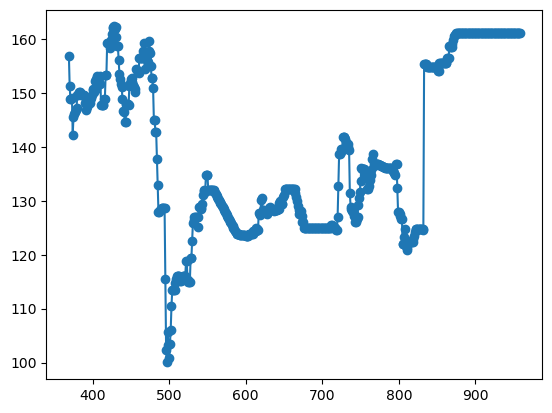

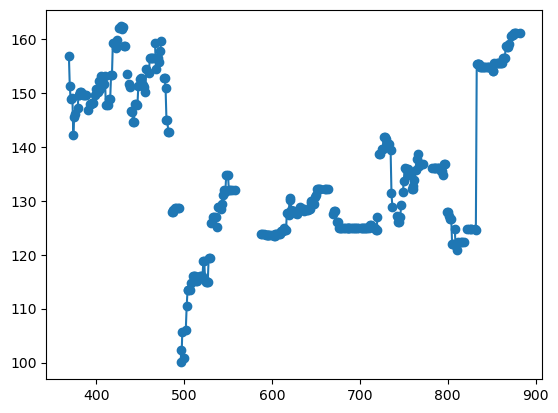

In [99]:
big_df['interpolated distance'] = big_df['dist btw peter2 and peter1'].interpolate()
dists = big_df['interpolated distance'].to_numpy()
plt.plot(dists)
plt.scatter(range(len(dists)), dists)
plt.show()
plt.close()

dists = big_df['dist btw peter2 and peter1'].to_numpy()
plt.plot(dists)
plt.scatter(range(len(dists)), dists)
plt.show()
plt.close()

In [129]:
highs = big_df[big_df["BirdID"] == 'peter2']["High"].to_numpy()
print(np.mean(highs))
big_df[big_df['BirdID'] == 'peter2'].iloc[410:420][["BirdID", 'High', 'Freq Match',]]

0.15970149253731344


BirdID  High Freq Match
529  peter2   0.0    low-low
532  peter2   0.0        nan
534  peter2   0.0    low-low
536  peter2   0.0   high-low
538  peter2   0.0    low-low
540  peter2   0.0    low-low
542  peter2   0.0   high-low
544  peter2   0.0    low-low
546  peter2   1.0   low-high
548  peter2   0.0    low-low

In [13]:
match_df = pd.DataFrame.from_dict(matches)
for i, row in match_df.iterrows():
    match_df.loc[i, 'Name'] = birdnames[i]

cols = match_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
match_df = match_df[cols]
match_df

Name  % low songs out of all songs  % high songs out of all songs  \
0   peter2                      0.849850                       0.150150   
1   peter1                      0.761246                       0.238754   
2    cham2                      0.811966                       0.188034   
3    cham1                      0.832413                       0.167587   
4     BBF8                      0.807927                       0.192073   
5      GB1                      0.634656                       0.365344   
6     BBF8                      0.782946                       0.217054   
7     BBF9                      0.833091                       0.166909   
8   chick2                      0.590820                       0.409180   
9   chick3                      0.588674                       0.411326   
10    BBF3                      0.802326                       0.197674   
11    BBF2                      0.863184                       0.136816   
12   frye3                      0.853312                       0.146688   
13   frye1                      0.705641                       0.294359   
14   frye3                      0.838550                       0.161450   
15   frye4                      0.804388                       0.195612   
16  power1                      0.708286                       0.291714   
17  power2                      0.618879                       0.381121   
18  frye31                      0.654420                       0.345580   
19  frye32                      0.799539                       0.200461   
20  frye31                      0.657895                       0.342105   
21  frye32                      0.747024                       0.252976   

    # of low songs  # of high songs  # of low low  # of high high  \
0              566              100           183               6   
1              220               69           176               6   
2              380               88           255               7   
3              904              182           277              13   
4             1060              252           135              15   
5              304              175           168              27   
6             1010              280           488              26   
7              574              115           426              20   
8              605              419           250             109   
9              395              276           202              81   
10             621              153           470               7   
11             694              110           361              11   
12             541               93           301               8   
13             688              287           422              25   
14             509               98           177               5   
15             440              107           296              12   
16             624              257           322              64   
17             872              537           382              67   
18             570              301           194              24   
19             347               87           189              17   
20             475              247           161              19   
21             251               85           163              21   

    # of low high  # of high low  % of LM out of possible LM  \
0              39             54                    0.824324   
1              58             30                    0.752137   
2              68             78                    0.789474   
3              81             63                    0.773743   
4              47             95                    0.741758   
5             101             36                    0.624535   
6             133             83                    0.785829   
7              87            108                    0.830409   
8             191            182                    0.566893   
9             149            129                    

In [14]:
for i, row in match_df.iterrows():
    match_df.loc[i, "% high match vs exp."] = row["% of HM out of possible HM"] - row["% high songs out of all songs"]
    match_df.loc[i, "% low matches vs exp."] = row["% of LM out of possible LM"] - row["% low songs out of all songs"]
match_df
    

Name  % low songs out of all songs  % high songs out of all songs  \
0   peter2                      0.849850                       0.150150   
1   peter1                      0.761246                       0.238754   
2    cham2                      0.811966                       0.188034   
3    cham1                      0.832413                       0.167587   
4     BBF8                      0.807927                       0.192073   
5      GB1                      0.634656                       0.365344   
6     BBF8                      0.782946                       0.217054   
7     BBF9                      0.833091                       0.166909   
8   chick2                      0.590820                       0.409180   
9   chick3                      0.588674                       0.411326   
10    BBF3                      0.802326                       0.197674   
11    BBF2                      0.863184                       0.136816   
12   frye3                      0.853312                       0.146688   
13   frye1                      0.705641                       0.294359   
14   frye3                      0.838550                       0.161450   
15   frye4                      0.804388                       0.195612   
16  power1                      0.708286                       0.291714   
17  power2                      0.618879                       0.381121   
18  frye31                      0.654420                       0.345580   
19  frye32                      0.799539                       0.200461   
20  frye31                      0.657895                       0.342105   
21  frye32                      0.747024                       0.252976   

    # of low songs  # of high songs  # of low low  # of high high  \
0              566              100           183               6   
1              220               69           176               6   
2              380               88           255               7   
3              904              182           277              13   
4             1060              252           135              15   
5              304              175           168              27   
6             1010              280           488              26   
7              574              115           426              20   
8              605              419           250             109   
9              395              276           202              81   
10             621              153           470               7   
11             694              110           361              11   
12             541               93           301               8   
13             688              287           422              25   
14             509               98           177               5   
15             440              107           296              12   
16             624              257           322              64   
17             872              537           382              67   
18             570              301           194              24   
19             347               87           189              17   
20             475              247           161              19   
21             251               85           163              21   

    # of low high  # of high low  % of LM out of possible LM  \
0              39             54                    0.824324   
1              58             30                    0.752137   
2              68             78                    0.789474   
3              81             63                    0.773743   
4              47             95                    0.741758   
5             101             36                    0.624535   
6             133             83                    0.785829   
7              87            108                    0.830409   
8             191            182                    0.566893   
9             149            129                    

--------------- 0-peter2 ----------------
high song fishers: 
[[100, 566], [6, 54]] exp:  0.15 obs:  0.1
odd ratio is : 1.5901060070671378
p_value is :  0.3448096657060512
-
low song fishers: 
[[566, 100], [183, 39]] exp:  0.85 obs:  0.82
odd ratio is : 1.2062295081967214
p_value is : 0.3935752748790833
-
###################################
--------------- 1-peter1 ----------------
high song fishers: 
[[69, 220], [6, 30]] exp:  0.24 obs:  0.17
odd ratio is : 1.5681818181818181
p_value is :  0.405748773320193
-
low song fishers: 
[[220, 69], [176, 58]] exp:  0.76 obs:  0.75
odd ratio is : 1.0507246376811594
p_value is : 0.837854247374594
-
###################################
--------------- 2-cham2 ----------------
high song fishers: 
[[88, 380], [7, 78]] exp:  0.19 obs:  0.08
odd ratio is : 2.5804511278195488
p_value is :  0.018254364290650454
-
low song fishers: 
[[380, 88], [255, 68]] exp:  0.81 obs:  0.79
odd ratio is : 1.1515151515151516
p_value is : 0.4673462934548231
-
##########

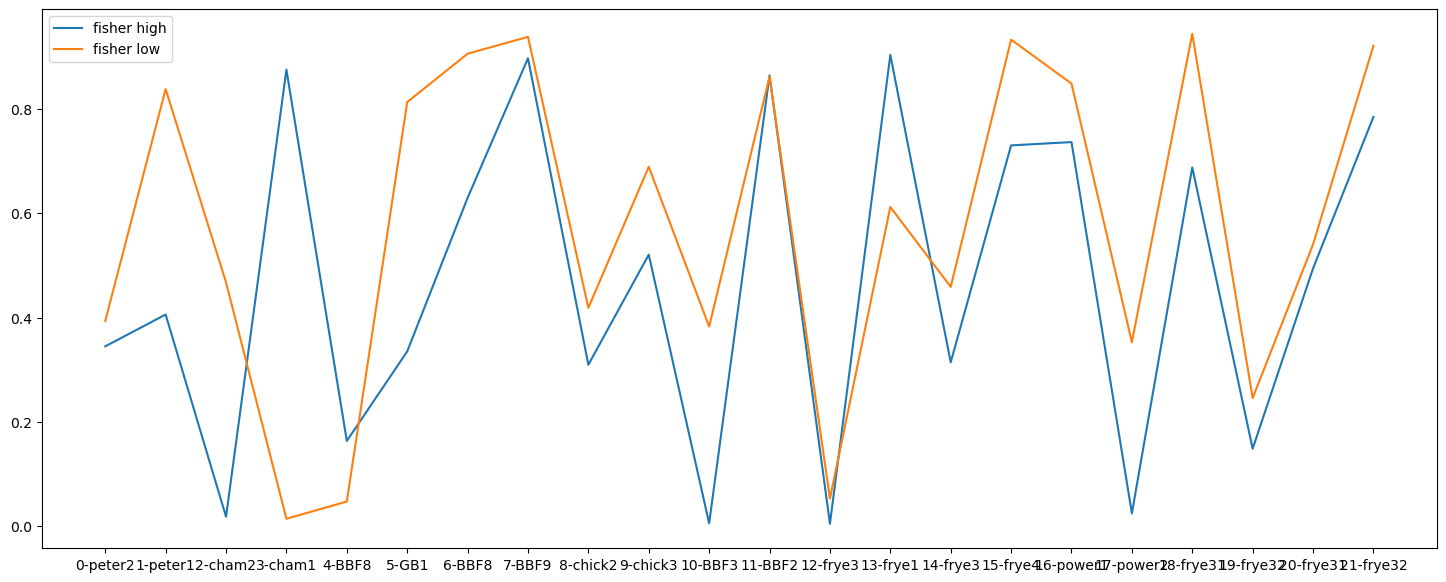

Name  % low songs out of all songs  % high songs out of all songs  \
0   peter2                      0.849850                       0.150150   
1   peter1                      0.761246                       0.238754   
2    cham2                      0.811966                       0.188034   
3    cham1                      0.832413                       0.167587   
4     BBF8                      0.807927                       0.192073   
5      GB1                      0.634656                       0.365344   
6     BBF8                      0.782946                       0.217054   
7     BBF9                      0.833091                       0.166909   
8   chick2                      0.590820                       0.409180   
9   chick3                      0.588674                       0.411326   
10    BBF3                      0.802326                       0.197674   
11    BBF2                      0.863184                       0.136816   
12   frye3                      0.853312                       0.146688   
13   frye1                      0.705641                       0.294359   
14   frye3                      0.838550                       0.161450   
15   frye4                      0.804388                       0.195612   
16  power1                      0.708286                       0.291714   
17  power2                      0.618879                       0.381121   
18  frye31                      0.654420                       0.345580   
19  frye32                      0.799539                       0.200461   
20  frye31                      0.657895                       0.342105   
21  frye32                      0.747024                       0.252976   

    # of low songs  # of high songs  # of low low  # of high high  \
0              566              100           183               6   
1              220               69           176               6   
2              380               88           255               7   
3              904              182           277              13   
4             1060              252           135              15   
5              304              175           168              27   
6             1010              280           488              26   
7              574              115           426              20   
8              605              419           250             109   
9              395              276           202              81   
10             621              153           470               7   
11             694              110           361              11   
12             541               93           301               8   
13             688              287           422              25   
14             509               98           177               5   
15             440              107           296              12   
16             624              257           322              64   
17             872              537           382              67   
18             570              301           194              24   
19             347               87           189              17   
20             475              247           161              19   
21             251               85           163              21   

    # of low high  # of high low  % of LM out of possible LM  \
0              39             54                    0.824324   
1              58             30                    0.752137   
2              68             78                    0.789474   
3              81             63                    0.773743   
4              47             95                    0.741758   
5             101             36                    0.624535   
6             133             83                    0.785829   
7              87            108                    0.830409   
8             191            182                    0.566893   
9             149            129                    

In [17]:
highps, lowps = freq_match_fishers(match_df)
match_df

In [18]:
p_vals_df = match_df[['Name', '% high match vs exp.', '% low matches vs exp.', 'high p', 'low p']]

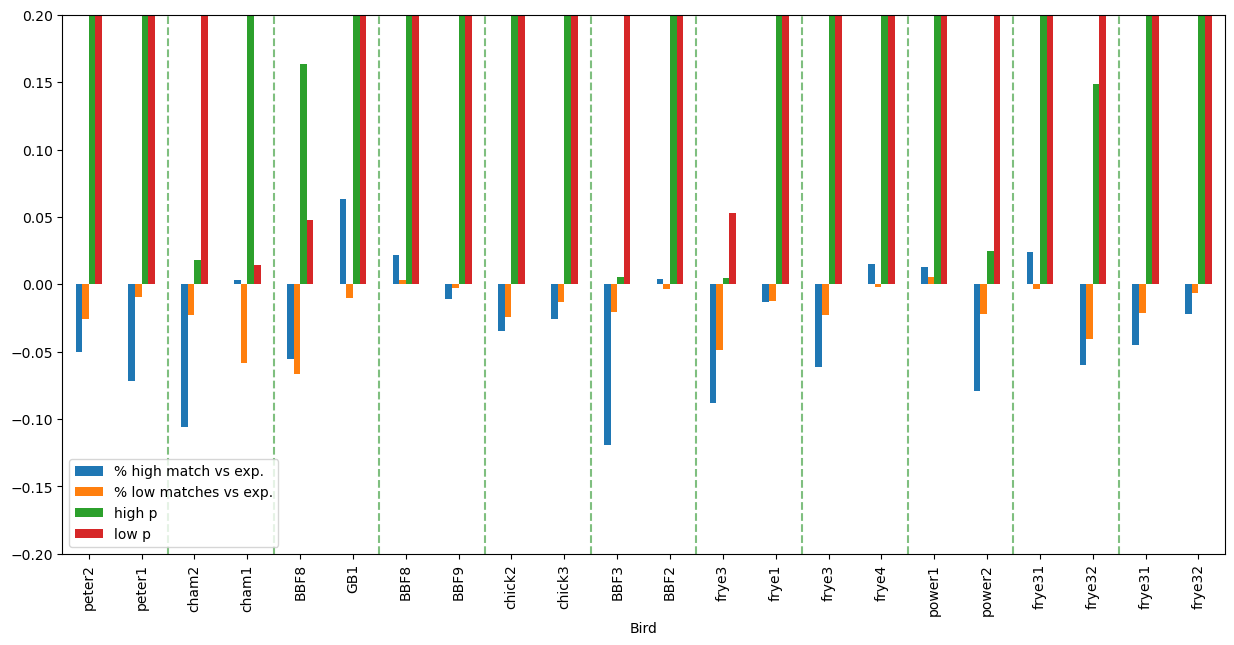

In [21]:
#fig, ax = plt.subplots(figsize=(15,7))
ax = p_vals_df.plot.bar(figsize=(15,7))
for i in range(len(p_vals_df)):
    if i % 2 == 0 and i > 0:
        plt.axvline(x = i - .5, color = 'green', linestyle='--', alpha=0.5, label = 'cs pairs')
plt.xticks(range(len(p_vals_df)),birdnames)
#plt.yscale('symlog')
plt.xlabel('Bird')
plt.ylim([-0.2, 0.2])
plt.show()

In [16]:
numnames = []
for i, birdname in enumerate(birdnames):
    numnames.append(str(i) + '-' + birdname)

In [107]:
match_df

Name  % low songs out of all songs  % high songs out of all songs  \
0    frye3                      0.853774                       0.146226   
1    frye1                      0.705641                       0.294359   
2    frye3                      0.839080                       0.160920   
3    frye4                      0.802947                       0.197053   
4     BBF3                      0.802326                       0.197674   
5     BBF2                      0.863184                       0.136816   
6   power1                      0.708286                       0.291714   
7   power2                      0.618337                       0.381663   
8   frye31                      0.654420                       0.345580   
9   frye32                      0.805104                       0.194896   
10  frye31                      0.657895                       0.342105   
11  Frye32                      0.745509                       0.254491   
12    BBF8                      0.782508                       0.217492   
13    BBF9                      0.833091                       0.166909   
14   cham2                      0.811159                       0.188841   
15   cham1                      0.832413                       0.167587   
16  chick2                      0.590820                       0.409180   
17  chick3                      0.588674                       0.411326   
18  peter2                      0.840299                       0.159701   
19  peter1                      0.761246                       0.238754   

    # of low songs  # of high songs  # of low matches  # of high matches  \
0              543               93               312                  8   
1              688              287               439                 25   
2              511               98               180                  5   
3              436              107               294                 12   
4              621              153               473                  7   
5              694              110               361                 11   
6              624              257               320                 64   
7              870              537               383                 69   
8              570              301               196                 23   
9              347               84               189                 16   
10             475              247               161                 19   
11             249               85               162                 21   
12            1011              281               489                 27   
13             574              115               426                 20   
14             378               88               253                  7   
15             904              182               277                 13   
16             605              419               251                109   
17             395              276               203                 81   
18             563              107               185                  6   
19             220               69               176                  6   

    # of low high  # of high low  % of LM out of possible LM  \
0              73            132                    0.810390   
1             194             64                    0.693523   
2              40             45                    0.818182   
3              74             43                    0.798913   
4             131             82                    0.783113   
5              59             67                    0.859524   
6             129            147                    0.712695   
7             258            154                    0.597504   
8             105             39                    0.651163   
9              58            104                    0.765182   
10             92             45                    0.636364   
11             57             69                    0.739726   
1

--------------- 0-frye3 ----------------
high song fishers: 
[[93, 543], [8, 132]] exp:  0.15 obs:  0.06
odd ratio is : 2.8259668508287294
p_value is :  0.003358950130716322
-
low song fishers: 
[[543, 93], [312, 73]] exp:  0.85 obs:  0.81
odd ratio is : 1.36610835401158
p_value is : 0.07989246781081358
-
###################################
--------------- 1-frye1 ----------------
high song fishers: 
[[287, 688], [25, 64]] exp:  0.29 obs:  0.28
odd ratio is : 1.067906976744186
p_value is :  0.9032437962739079
-
low song fishers: 
[[688, 287], [439, 194]] exp:  0.71 obs:  0.69
odd ratio is : 1.0593604406594017
p_value is : 0.6161464204217117
-
###################################
--------------- 2-frye3 ----------------
high song fishers: 
[[98, 511], [5, 45]] exp:  0.16 obs:  0.1
odd ratio is : 1.726027397260274
p_value is :  0.3143636319891195
-
low song fishers: 
[[511, 98], [180, 40]] exp:  0.84 obs:  0.82
odd ratio is : 1.1587301587301588
p_value is : 0.46221503096952316
-
#########

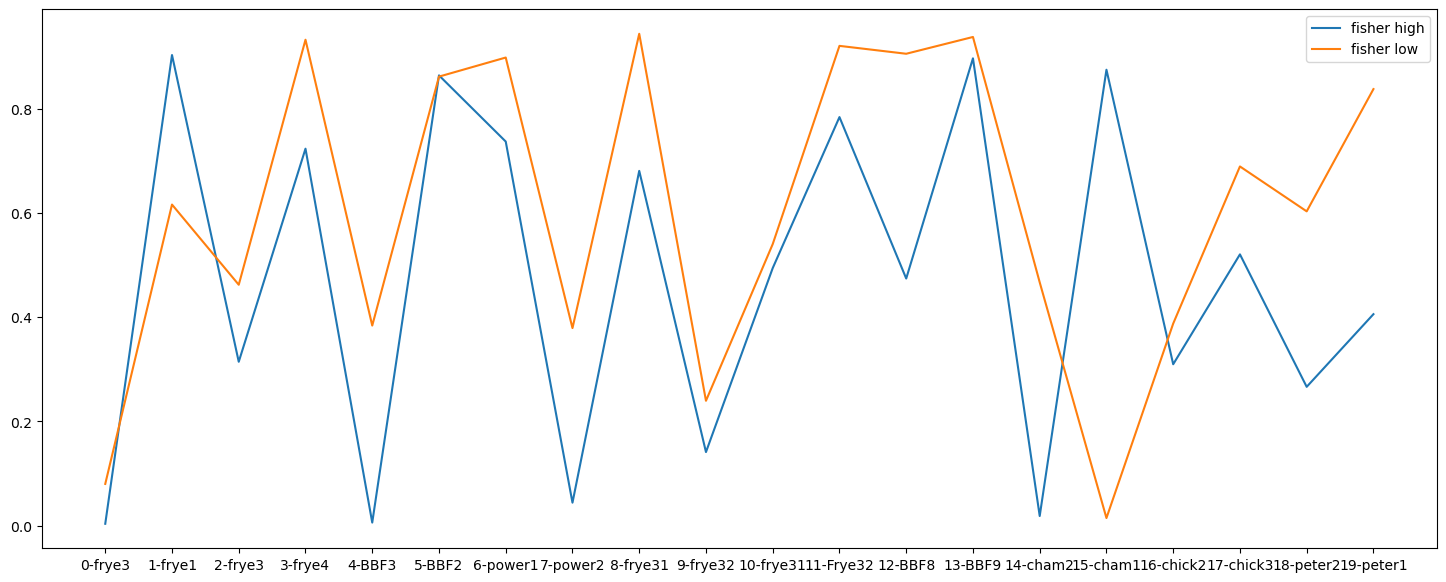

In [146]:
    #plot_consistency_vs_distance(big_df)
    #plot_consistency_vs_territory_distance(big_df)
birds = big_df['BirdID'].unique()

song_rates = []
rolled_song_rates = []
song_times = []
for bird in birds:
    sr = big_df[big_df['BirdID'] == bird]['tsl'].to_numpy()
    times = big_df[big_df['BirdID'] == bird]['RecA Time'].to_numpy()
    song_rates.append(sr)
    #print(sr)
    roll_window_length = 10
    rolled_sr = rolling_backward_mean(sr, roll_window_length)
    rolled_song_rates.append(rolled_sr)
    song_times.append(times)

dist = big_df[big_df['BirdID'] == birds[0]]['dist to ' + birds[1]].to_numpy()
dist_times = big_df[big_df['BirdID'] == birds[0]]['RecA Time'].to_numpy()

colors = ['blue', 'orange', 'purple', 'green',]
lines = []


fig, ax1 = plt.subplots(figsize=(15,7))
for i, rolled_sr in enumerate(rolled_song_rates):
    line = ax1.scatter(song_times[i], rolled_sr, s=5, c=colors[i], label=birds[i])
    ax1.plot(song_times[i], rolled_sr, c=colors[i], label=birds[i])
    # plt.plot(song_times[i], song_rates[i], alpha=0.1, c=colors[i])
    lines.append(line)


normdist = (dist - np.nanmin(dist)) / (np.nanmax(dist) - np.nanmin(dist))
ax2 = ax1.twinx()
line = ax2.scatter(dist_times, normdist, s=10, alpha=0.5, c=colors[3], marker='o', label=f"dist btw birds")
lines.append(line)

start_times = []
end_times = []
for times in song_times:
    start_times.append(np.min(times))
    end_times.append(np.max(times))


plt.title(f'Averaged Singing Rates for {birds[0]} & {birds[1]} on {date}')
plt.legend(handles = lines)
ax1.set_ylabel('Average Time Since Last Song (s)')
ax2.set_ylabel('Normalized Distance Between Birds', color=colors[3])
plt.xlabel("Time (seconds)")
#plt.ylabel("Average Seconds Since Last Song (s)")
plt.savefig(f'songrate_distance-{birds[0]}_{birds[1]}_{date}.png')
#plt.xlim([np.max(start_times), np.min(end_times)])
#plt.xlim([3000, 4000])
plt.show()
plt.close()

IndentationError: expected an indented block after 'for' statement on line 8 (2087455778.py, line 9)

In [234]:




# for i, row in big_df.iterrows():
#     if row['BirdID'] == 'BBF8':
#         print(row['RecA Time'])


# dists1 = new_df['dist to BBF9'].to_numpy()
# dists2 = new_df['dist to GB1'].to_numpy()
# dists3 = new_df['dist to BBF8'].to_numpy()
# time = new_df['RecA Time'].to_numpy()
# print(type(dists1))
# print(np.nanmin(dists1), np.nanmax(dists1))
# print(np.nanmin(cons2), np.nanmax(cons2))
# normdists1 = (dists1 - np.nanmin(dists1)) / (np.nanmax(dists1) - np.nanmin(dists1))
# normdists2 = (dists2 - np.nanmin(dists2)) / (np.nanmax(dists2) - np.nanmin(dists2))
# normcons2 = (cons2 - np.min(cons2)) / (np.max(cons2) - np.min(cons2))
# normcons1 = (cons1 - np.min(cons1)) / (np.max(cons1) - np.min(cons1))


# fig = plt.figure(figsize=(15,7))
# plt.scatter(time, normdists1, s=5, alpha=0.5)
# #plt.scatter(time, normdists2, s=5, alpha=0.5)
# #plt.scatter(con_times1, normcons1, label=bird1 + " consistency", color='purple', s=5, alpha=.2)
# plt.scatter(con_times2, normcons2, label=bird2 + " consistency", color='orange', s=5, alpha=.4)
# #plt.scatter(time, dists3, s=5, alpha=0.5)
# #plt.xlim([2000, 2500])
# plt.show()
# plt.close()
# big_df

In [133]:
def add_cs(df):
    birds = df['BirdID'].unique()
    for i, row in big_df.iterrows():
        if row['BirdID'] == birds[0]:
            # 
            if last_song_indexes[0] >= 0 and row['Begin Time (s)'] - big_df.loc[last_song_indexes[0], 'Begin Time (s)'] < 10:
                big_df.loc[last_song_indexes[0], 'next'] = row['ID']
                big_df.loc[i, 'tsl'] = row['Begin Time (s)'] - big_df.loc[last_song_indexes[0], 'Begin Time (s)']
            last_song_indexes[0] = i
            if last_song_indexes[1] >= 0 and row['Begin Time (s)'] - big_df.loc[last_song_indexes[1], 'Begin Time (s)'] < 10:
                big_df.loc[i, 'countersinging'] = 'cs'
            else:
                big_df.loc[i, 'countersinging'] = 'solo'
    else:
        if last_32 >= 0 and row['Begin Time (s)'] - big_df.loc[last_32, 'Begin Time (s)'] < 10:
            big_df.loc[last_32, 'next'] = row['ID']
            big_df.loc[last_32, 'tsl'] = row['Begin Time (s)'] - big_df.loc[last_32, 'Begin Time (s)']
        last_32 = i
        if last_31 >= 0 and row['Begin Time (s)'] - big_df.loc[last_31, 'Begin Time (s)'] < 10:
            big_df.loc[i, 'countersinging'] = 'cs'
        else:
            big_df.loc[i, 'countersinging'] = 'solo'    
    if i != len(big_df) - 1:
        if big_df.iloc[i + 1]['bird'] != row['bird']:
            if (big_df.iloc[i + 1]['Begin Time (s)'] - row['Begin Time (s)']) < 10 and (big_df.iloc[i + 1]['Begin Time (s)'] - row['Begin Time (s)']) > .1:
                nextID = big_df.iloc[i + 1]['ID']
                big_df.loc[i, 'answer'] = nextID
big_df[big_df.bird == 'frye31']

NameError: name 'last_song_indexes' is not defined

In [ ]:
#get df of just cs or solo
frye31_cs_df = bothbirds[(bothbirds['bird'] == 'frye31') & (bothbirds['countersinging'] == 'cs')]
frye31_solo_df = bothbirds[(bothbirds['bird'] == 'frye31') & (bothbirds['countersinging'] == 'solo')]

In [ ]:
#compare song rate between solo and cs
cs_tsl = frye31_cs_df['tsl'].to_numpy()
cs_tsl = cs_tsl[~np.isnan(cs_tsl)]
solo_tsl = frye31_solo_df['tsl'].to_numpy()
solo_tsl = solo_tsl[~np.isnan(solo_tsl)]
print(solo_tsl[-5:])
print(cs_tsl[:5])
print('cs: ', np.nanmean(cs_tsl))
print('cs: ', np.mean(cs_tsl))
print('solo: ', np.nanmean(solo_tsl))
print('solo: ', np.mean(solo_tsl))
stats.ttest_ind(cs_tsl, solo_tsl)

In [ ]:
#compare song-type proportions based on cs vs solo
cs_counts = frye31_cs_df['ID'].value_counts().to_numpy()
solo_counts = frye31_solo_df['ID'].value_counts().to_numpy()
solo_counts = solo_counts * (np.sum(cs_counts)/np.sum(solo_counts))
print(cs_counts)
print(solo_counts)

stats.chisquare(cs_counts, solo_counts * (np.sum(cs_counts)/np.sum(solo_counts)))

In [ ]:
#make pivot table using an iter column full of ones
cs_table = pd.pivot_table(frye31_cs_df, values='iter', index=['ID'],
                       columns=['next'], aggfunc="sum", fill_value=0)
cs_table

In [ ]:
#make pivot table using crosstab. can use proportions by row instead of counts
cs_norm_table = pd.crosstab(frye31_cs_df.ID, frye31_cs_df.next)
solo_norm_table = pd.crosstab(frye31_solo_df.ID, frye31_solo_df.next)
cs_norm_table

In [ ]:
solo_norm_table

In [ ]:
#compare crosstab tables (esp if using proportions)
diff_table = cs_norm_table - solo_norm_table

In [200]:

    
arr1 = np.array(['A', 'C', 'C', 'B', 'B', 'B', 'A', 'B', 'C', 'B', 'B', 'C', 'B', 'C', 'D'])
times1 = np.array([3, 5, 8, 15.3, 17.4, 20.54, 25.4, 30, 33, 36, 51, 58, 60, 61, 64])

transitions, transition_times = get_valid_transitions(arr1, times1)
lin = get_linearity(transitions)
print(lin)

0.375


In [217]:


arr1 = np.array(['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'A', 'B'])
times1 = np.array([3, 5, 8, 15.3, 17.4, 20.54, 25.4, 30, 33, 36, 51, 58, 60, 61, 64])

transitions, transition_times = get_valid_transitions(arr1, times1)
print(len(transitions))
cons = get_consistency(transitions)
print(cons)
            
            
    

13
0.9230769230769231


In [153]:
test_transitions = [['A', 'B'], ['A', 'B'], ['A', 'C'], ['A', 'C']]
unique, counts = np.unique(test_transitions, axis=0, return_counts=True)
max_ind = np.argmax(counts)
print(max_ind)
print(unique)
print(unique[max_ind])

0
[['A' 'B']
 ['A' 'C']]
['A' 'B']


In [ ]:
df_name_list = []
name_stub ='test_finaldf_' + '*.pickle'
for file in glob.glob(name_stub):
    df_name_list.append(file)
df_name_list

df_array = []
for name in df_name_list:
    with open(name, "rb") as input_file:
        current_df = pickle.load(input_file)
    df_array.append(current_df)

big_df = pd.concat(df_array)
big_df = big_df.sort_values("RecA Time")
print(len(big_df))
# big_df = big_df[big_df["RecA Time"] > 1452]
# big_df = big_df[big_df["RecA Time"] < 5494]
# print(len(big_df))
# big_df[90:100]

birds = big_df["BirdID"].unique()
bird1 = birds[0]
bird2 = birds[1]


times1 = big_df[big_df["BirdID"] == bird1]['RecA Time'].to_numpy()
types1 = big_df[big_df["BirdID"] == bird1]['ID'].to_numpy()
times2 = big_df[big_df["BirdID"] == bird2]['RecA Time'].to_numpy()
types2 = big_df[big_df["BirdID"] == bird2]['ID'].to_numpy()

not enough future transitions...stopping.
not enough future transitions...stopping.
not enough future transitions...stopping.
not enough future transitions...stopping.
not enough future transitions...stopping.
not enough future transitions...stopping.
not enough future transitions...stopping.
not enough future transitions...stopping.
not enough future transitions...stopping.
not enough future transitions...stopping.
not enough future transitions...stopping.
not enough future transitions...stopping.
not enough future transitions...stopping.
not enough future transitions...stopping.


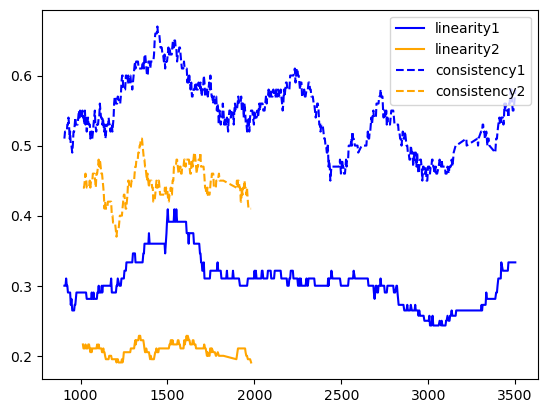

88


In [224]:





lins1, lin_times1 = get_rolling_linearity(types1, times1, 100)
cons1, con_times1 = get_rolling_consistency(types1, times1, 100)
lins2, lin_times2 = get_rolling_linearity(types2, times2, 100)
cons2, con_times2 = get_rolling_consistency(types2, times2, 100)

plt.plot(lin_times1, lins1, label="linearity1", color='blue')
plt.plot(lin_times2, lins2, label="linearity2", color='orange')
plt.plot(con_times1, cons1, label="consistency1", color='blue', linestyle='--')
plt.plot(con_times2, cons2, label="consistency2", color='orange', linestyle='--')

plt.legend(['linearity1', 'linearity2', 'consistency1', 'consistency2',], loc="upper right")
plt.show()
plt.close()
print(np.min(lin_counts))

In [119]:


transitions, transition_times = get_valid_transitions(types1, times1)
print(len(times1))
print(len(types1))
print(len(transitions))
print(len(transition_times))

15
722
13
13


In [253]:

center = 763
cluster_size = 5
transitions = get_valid_transitions_around_a_time(types1[:10], times1[:10], center, cluster_size)


print(transitions)
for i, type in enumerate(types1[:10]):
    print(type, times1[i])

not enough times before center
None
A 1570.4292978705366
D 1575.1825987640414
B 1579.969549270336
G 1584.0593710621222
C 1590.8912324643102
H 1595.9105592087747
D 1599.5123909004044
A 1603.6022126921905
F 1607.4596582458068
C 1611.5030047899588


working on:  04-26-2024
['test_finaldf_frye1_H1_1_04-26-2024.pickle', 'test_finaldf_frye1_H2_0_04-26-2024.pickle', 'test_finaldf_frye3_A_0_04-26-2024.pickle', 'test_finaldf_frye3_E_0_04-26-2024.pickle', 'test_finaldf_frye3_H6_0_04-26-2024.pickle']
1455
LINEARITY VALUES ----------------------
params:  [ 0.29159865 -0.2456184 ]
tvalues:  [27.53353759 -6.10623256]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2916      0.011     27.534      0.000       0.271       0.312
f test:  <F test: F=47248.14415850907, p=0.0, df_denom=439, df_num=2>
CONSISTENCY VALUES ----------------------
params:  [0.35378936 0.14944007]
tvalues:  [18.40097514  3.91144449]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      

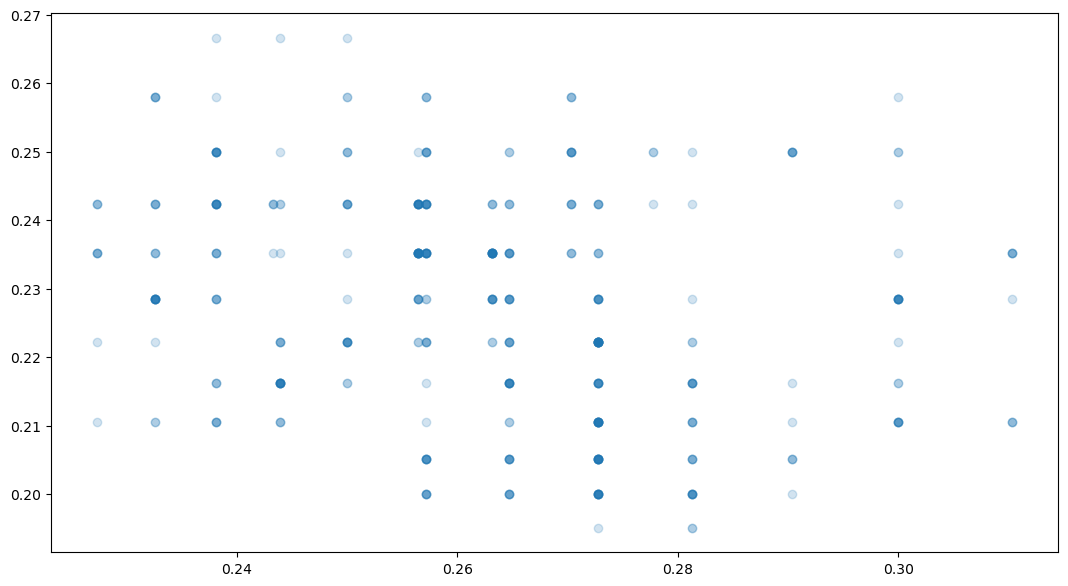

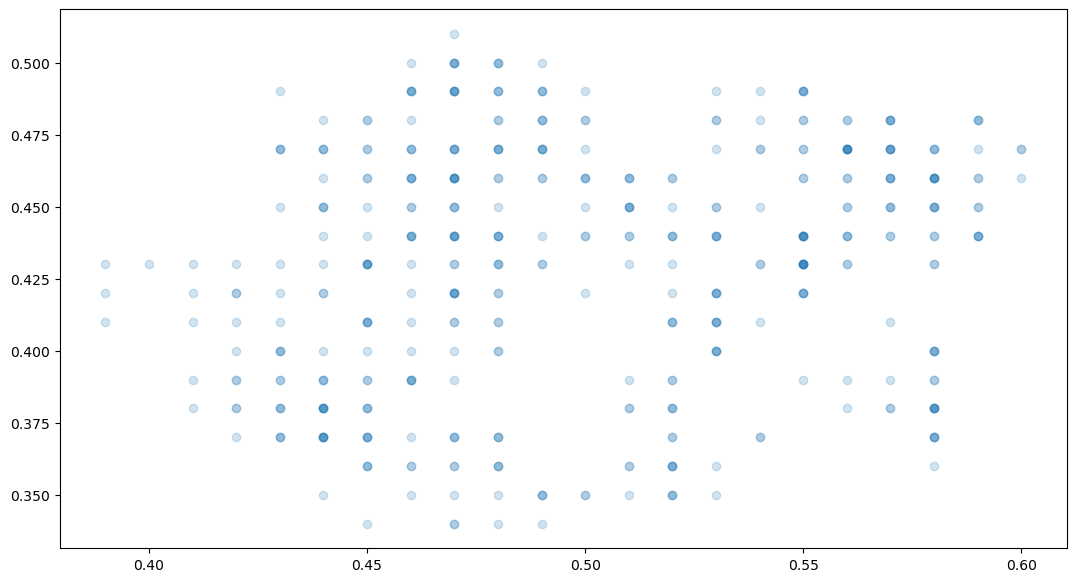

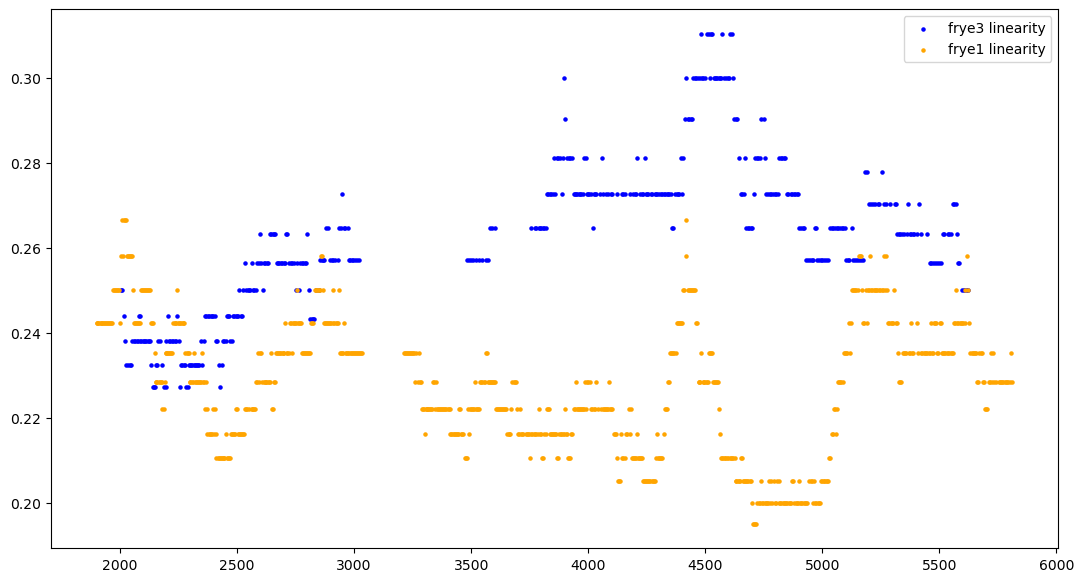

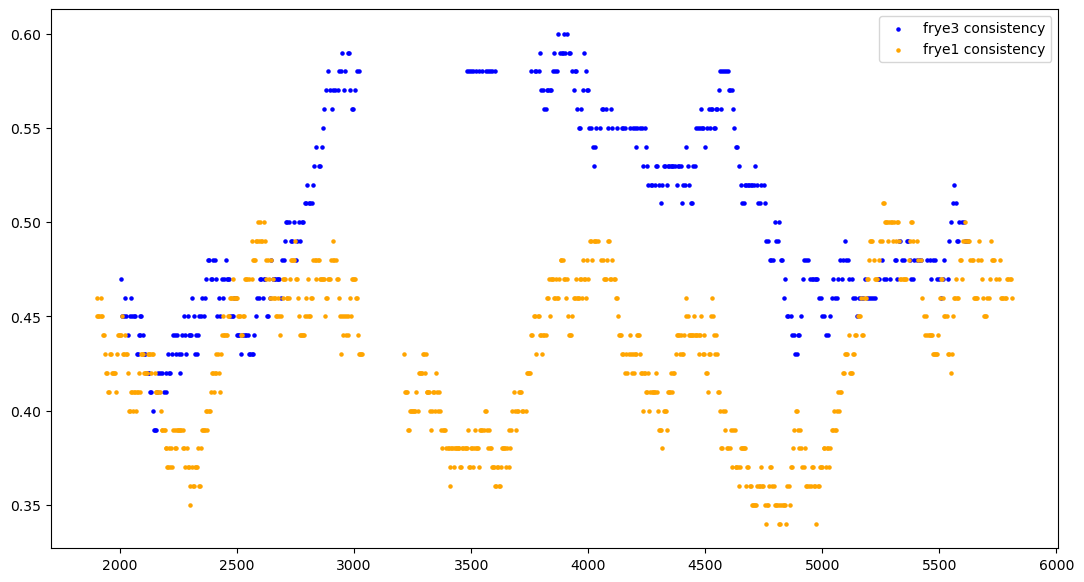

working on:  04-27-2024
['test_finaldf_frye3_E_0_04-27-2024.pickle', 'test_finaldf_frye3_H6_1_04-27-2024.pickle', 'test_finaldf_frye4_H1_0_04-27-2024.pickle', 'test_finaldf_frye4_H1_1_04-27-2024.pickle']
945
LINEARITY VALUES ----------------------
params:  [0.23854906 0.06290936]
tvalues:  [16.17095956  0.92456759]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2385      0.015     16.171      0.000       0.210       0.268
f test:  <F test: F=26481.976193387214, p=0.0, df_denom=382, df_num=2>
CONSISTENCY VALUES ----------------------
params:  [ 0.49079465 -0.11092613]
tvalues:  [22.09013949 -2.15136647]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

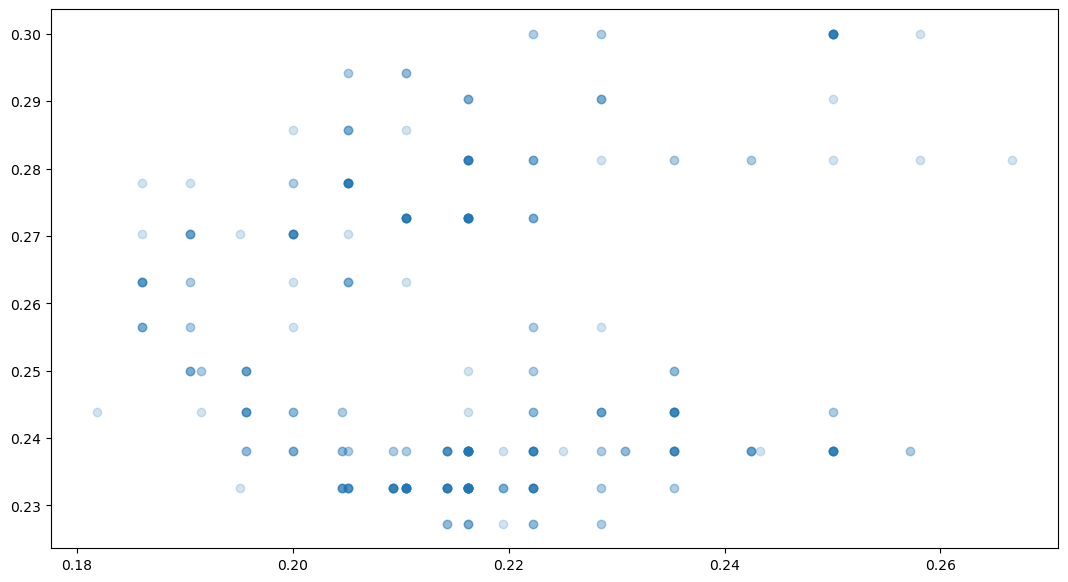

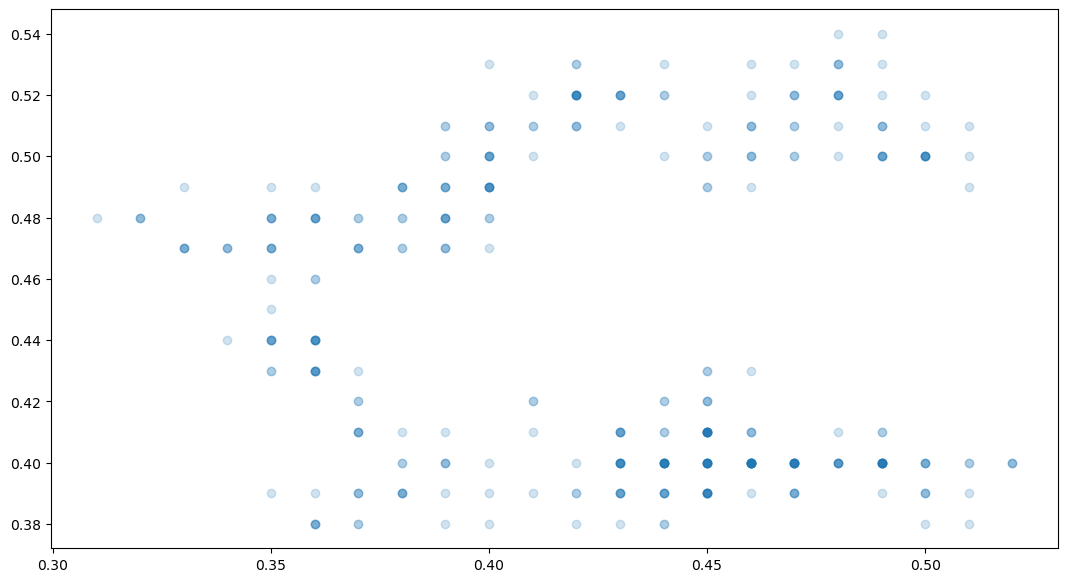

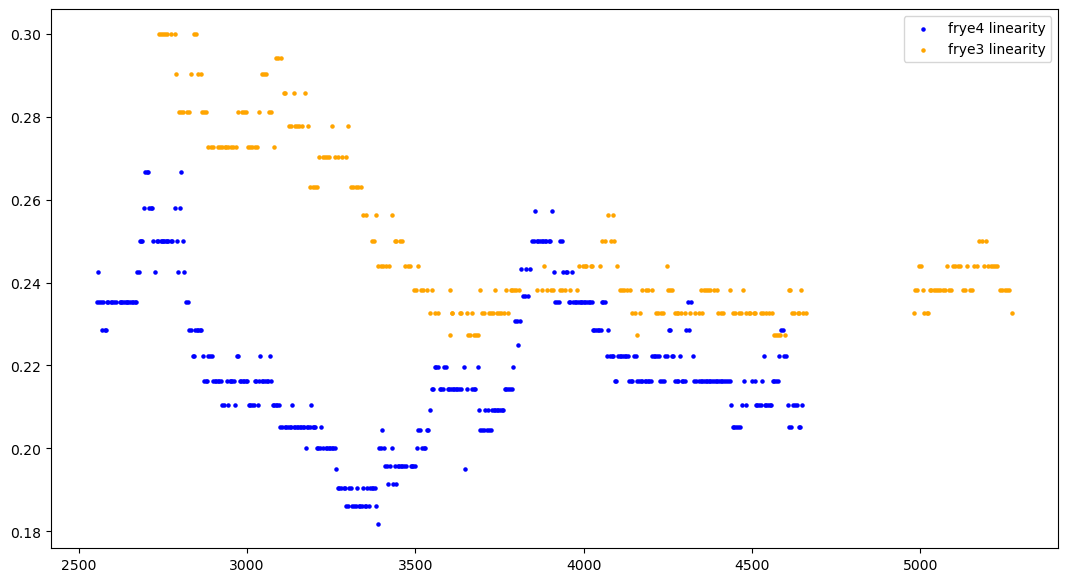

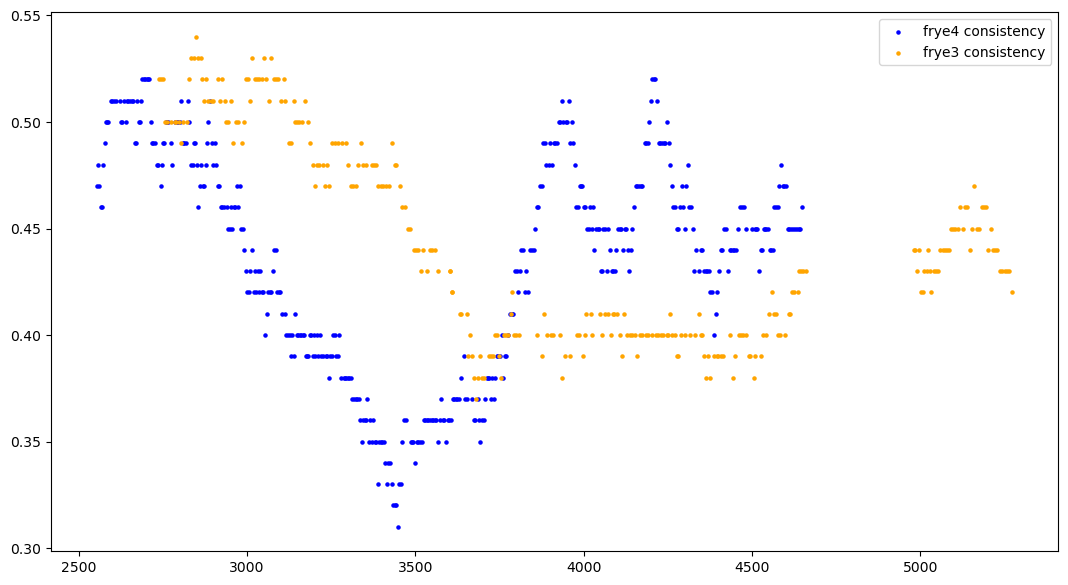

working on:  04-22-2024
['test_finaldf_BBF2_H2_0_04-22-2024.pickle', 'test_finaldf_BBF2_H2_1_04-22-2024.pickle', 'test_finaldf_BBF3_A_0_04-22-2024.pickle', 'test_finaldf_BBF3_H6_0_04-22-2024.pickle']
1521
LINEARITY VALUES ----------------------
params:  [0.10192866 0.50453339]
tvalues:  [14.80237848 17.44056327]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1019      0.007     14.802      0.000       0.088       0.115
f test:  <F test: F=110920.99804621829, p=0.0, df_denom=477, df_num=2>
CONSISTENCY VALUES ----------------------
params:  [0.19293937 0.38155149]
tvalues:  [15.11856794 13.96665297]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

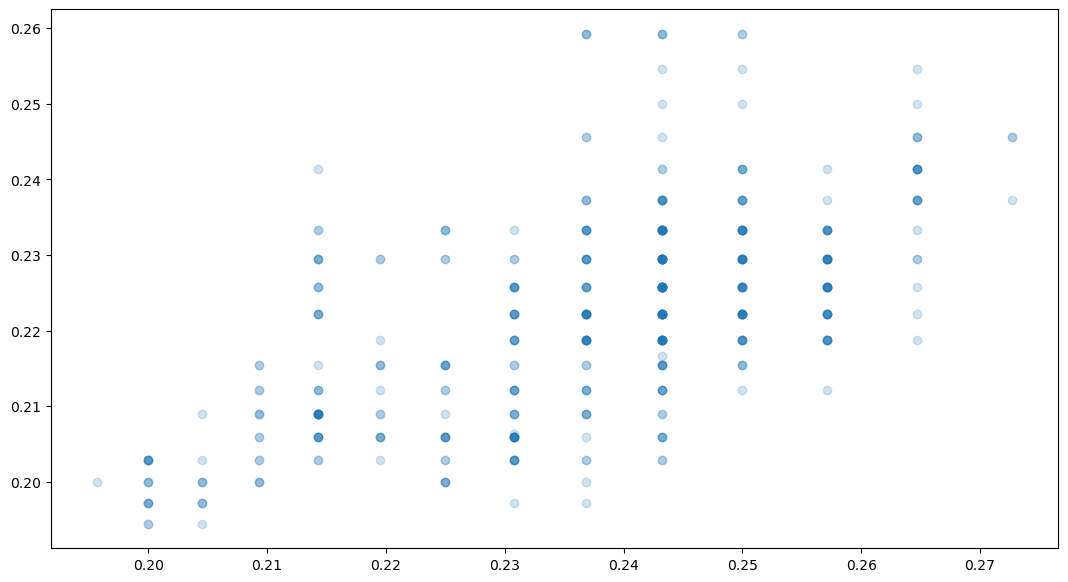

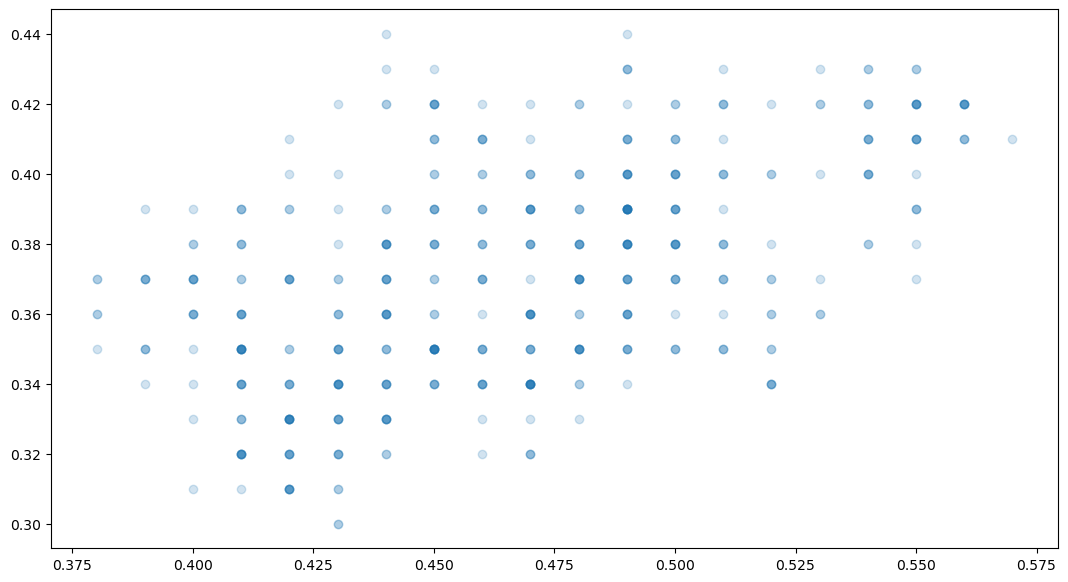

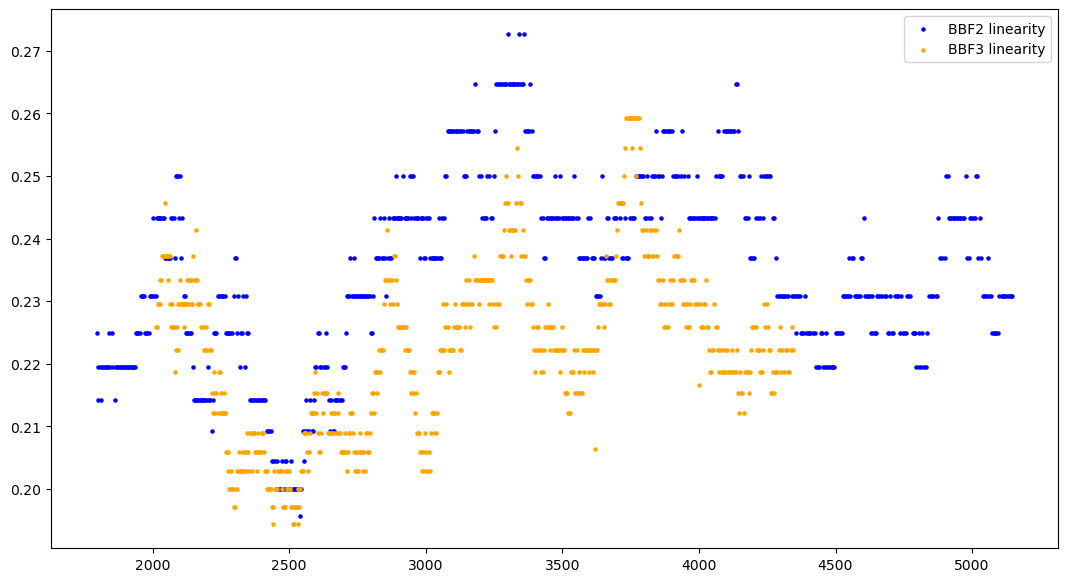

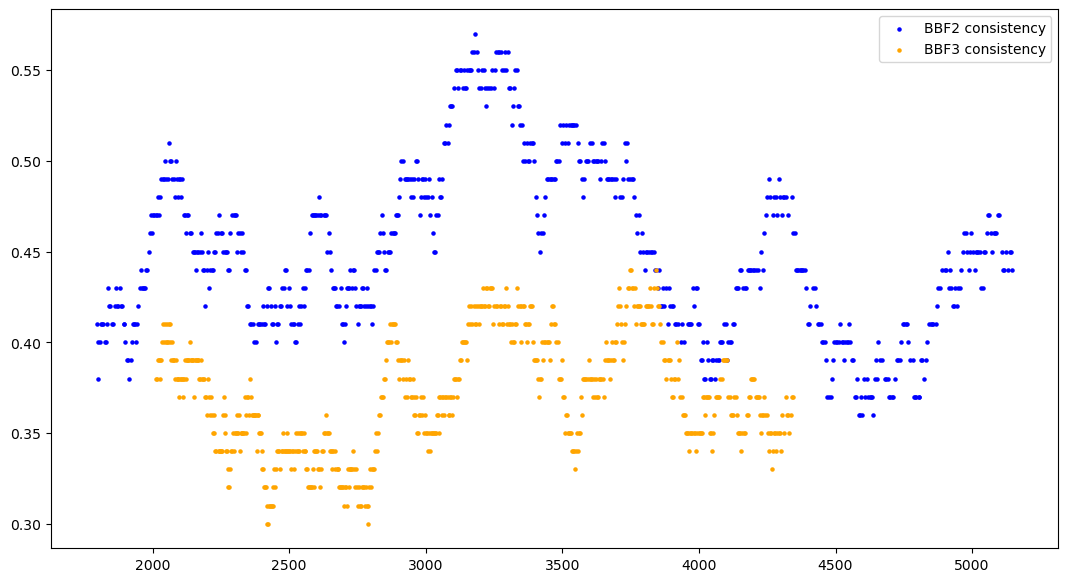

working on:  04-30-2024
['test_finaldf_power1_A_0_04-30-2024.pickle', 'test_finaldf_power1_E_0_04-30-2024.pickle', 'test_finaldf_power2_H3_0_04-30-2024.pickle', 'test_finaldf_power2_H3_1_04-30-2024.pickle']
2048
LINEARITY VALUES ----------------------
params:  [ 0.2266966  -0.08274804]
tvalues:  [37.27165988 -3.68441264]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2267      0.006     37.272      0.000       0.215       0.239
f test:  <F test: F=55441.82221724072, p=0.0, df_denom=645, df_num=2>
CONSISTENCY VALUES ----------------------
params:  [ 0.43996866 -0.14644536]
tvalues:  [27.47169225 -4.59349541]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------

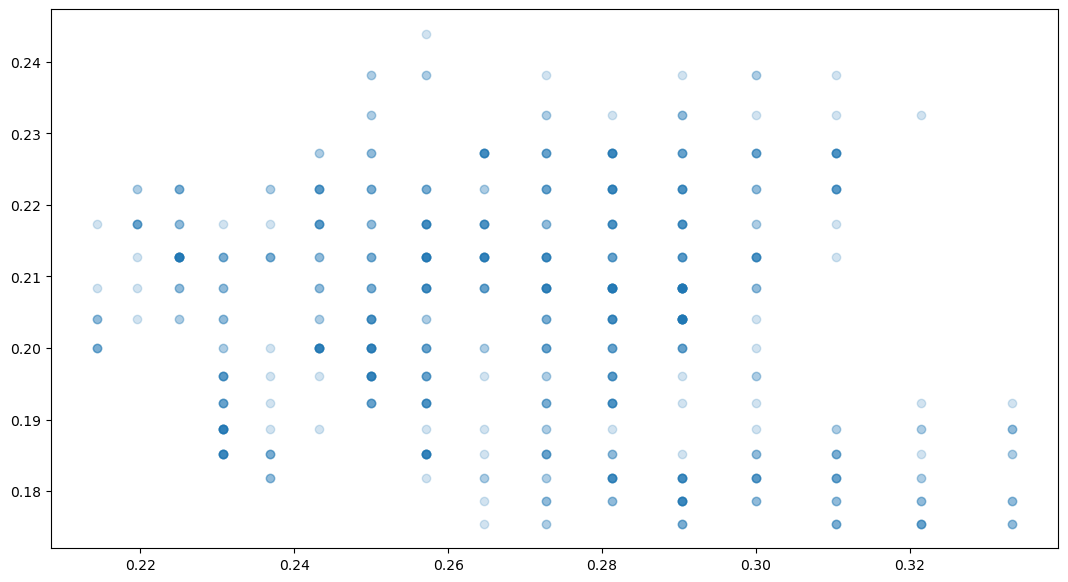

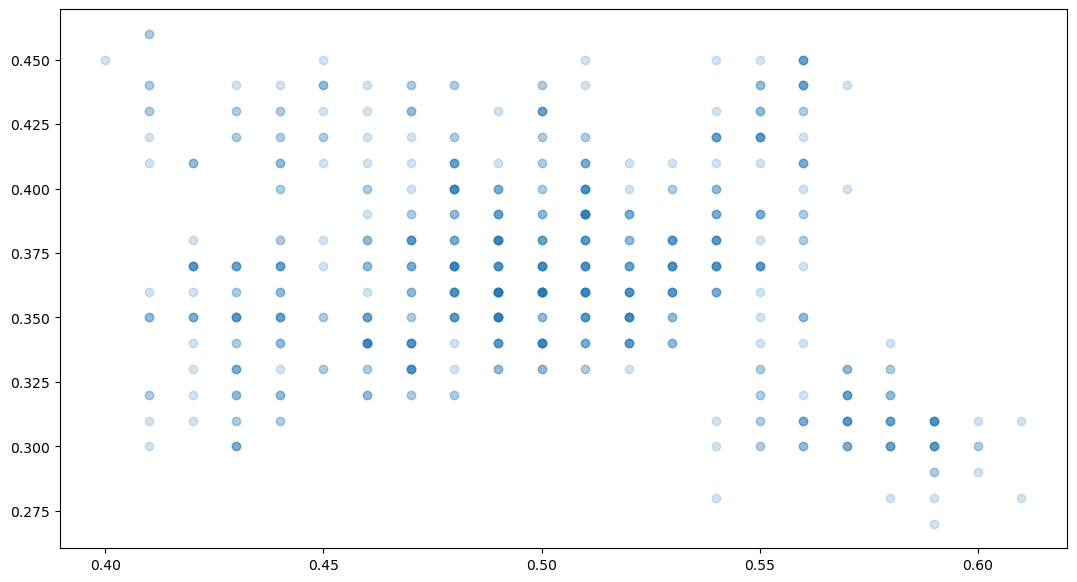

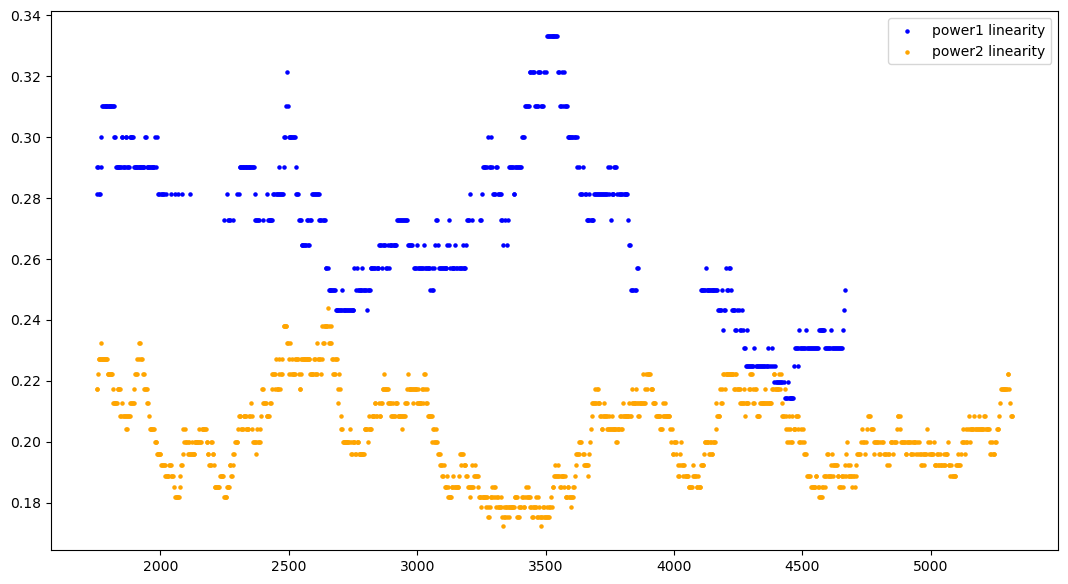

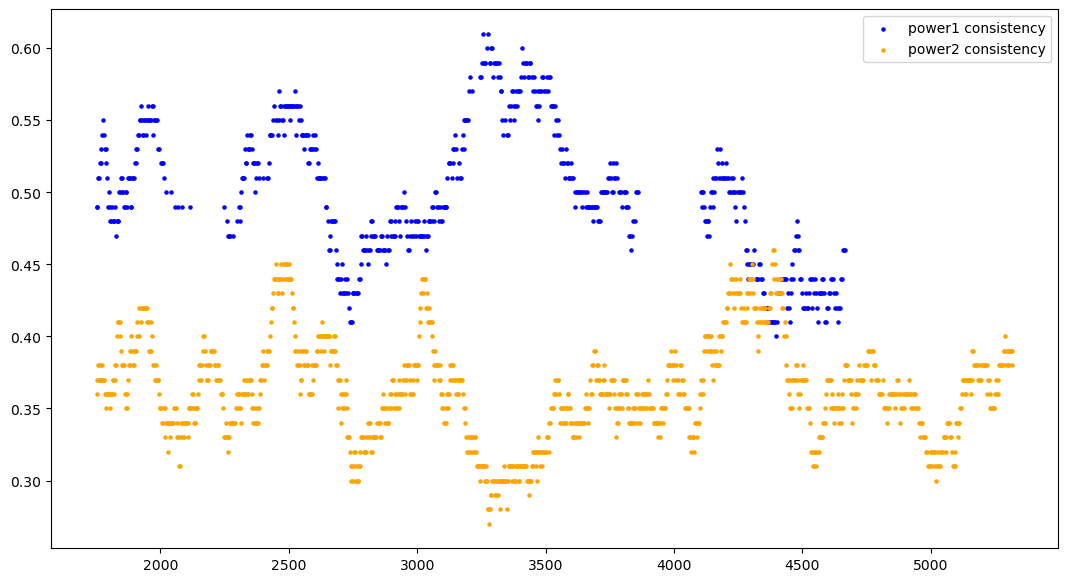

working on:  05-06-2024
['test_finaldf_frye31_A_0_05-06-2024.pickle', 'test_finaldf_frye31_B_0_05-06-2024.pickle', 'test_finaldf_frye31_E_0_05-06-2024.pickle', 'test_finaldf_frye32_H1_0_05-06-2024.pickle', 'test_finaldf_frye32_H2_0_05-06-2024.pickle', 'test_finaldf_frye32_H3_0_05-06-2024.pickle', 'test_finaldf_frye32_H4_0_05-06-2024.pickle']
1127
LINEARITY VALUES ----------------------
params:  [ 0.30632714 -0.36584002]
tvalues:  [ 55.30673577 -17.10150901]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.3063      0.006     55.307      0.000       0.295       0.317
f test:  <F test: F=129868.91527652067, p=0.0, df_denom=323, df_num=2>
CONSISTENCY VALUES ----------------------
params:  [0.38858093 0.07693948]
tvalues:  [11.51127862  1.1733345 ]
                             Test for Co

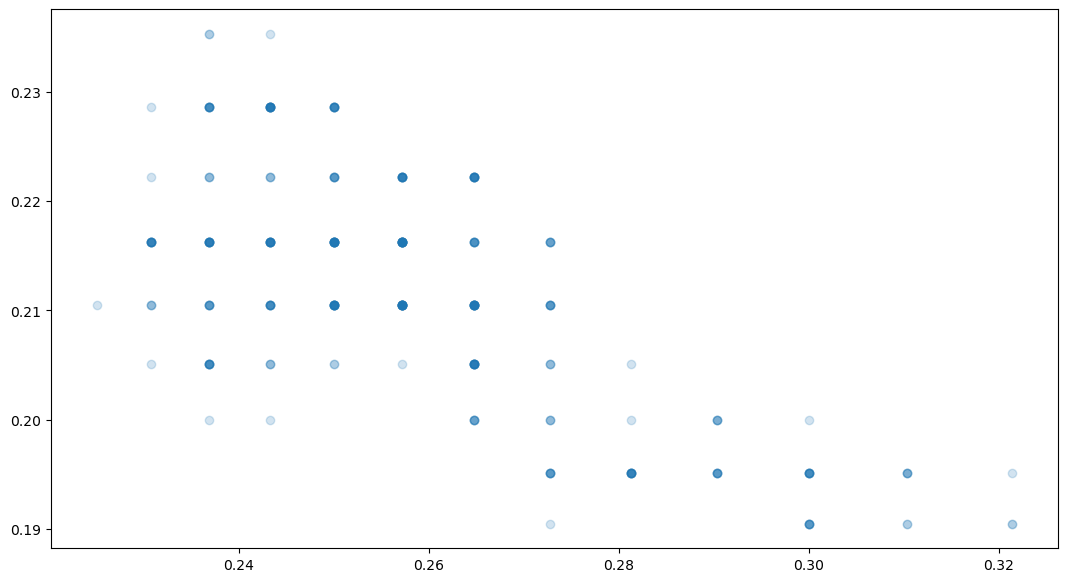

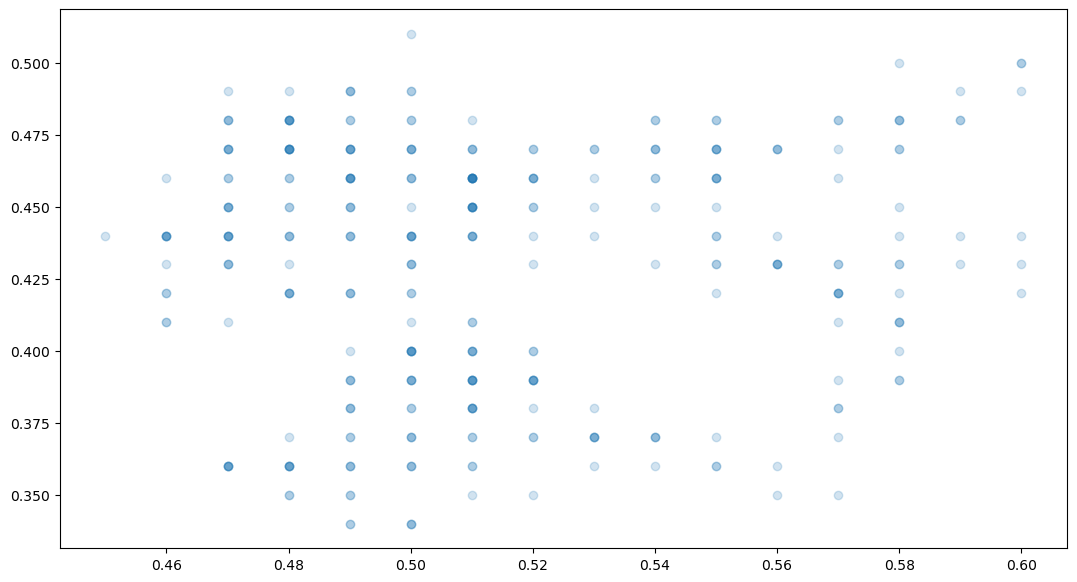

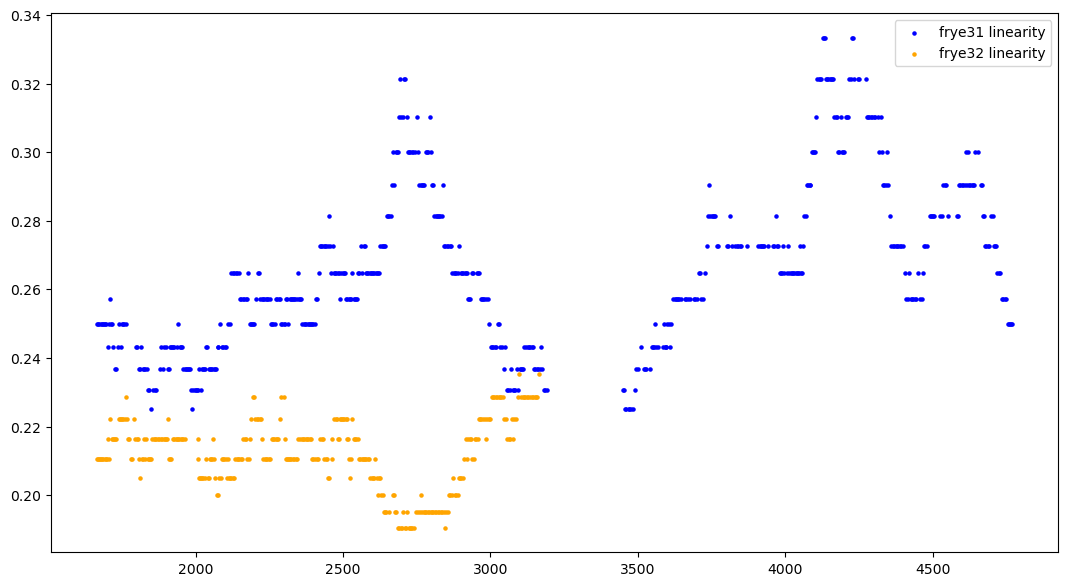

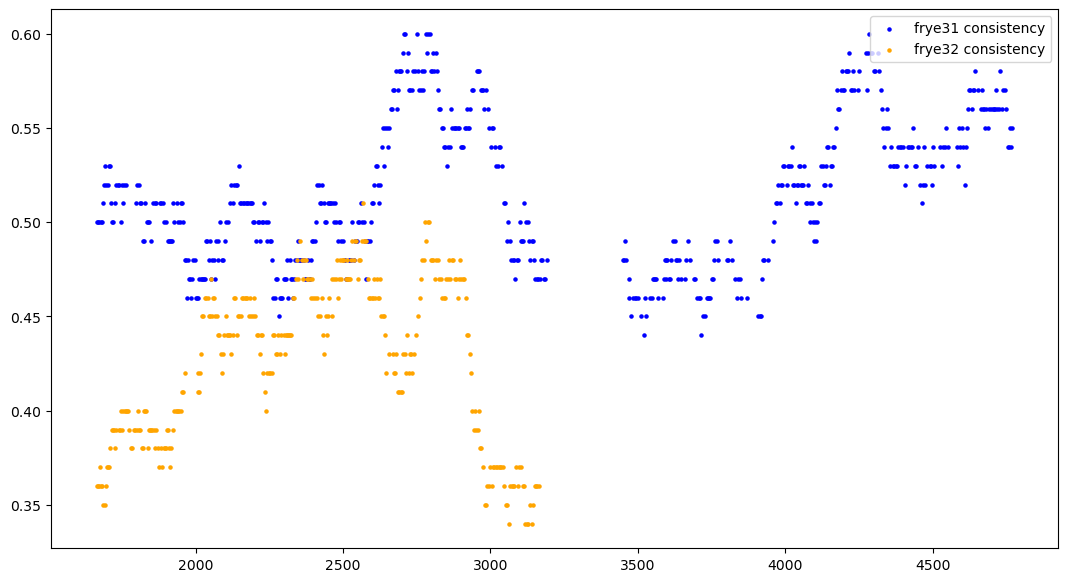

working on:  05-07-2024
['test_finaldf_frye31_B_0_05-07-2024.pickle', 'test_finaldf_frye31_D_0_05-07-2024.pickle', 'test_finaldf_Frye32_H1_0_05-07-2024.pickle', 'test_finaldf_Frye32_H2_0_05-07-2024.pickle', 'test_finaldf_Frye32_H3_0_05-07-2024.pickle']
836
LINEARITY VALUES ----------------------
params:  [-0.12639899  2.2765787 ]
tvalues:  [-1.98147224  7.47459241]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1264      0.064     -1.981      0.050      -0.253      -0.000
f test:  <F test: F=10826.602816121827, p=9.280694122664124e-150, df_denom=135, df_num=2>
CONSISTENCY VALUES ----------------------
params:  [0.52361234 0.16159257]
tvalues:  [7.49428595 1.0431259 ]
                             Test for Constraints                             
                 coef    std err      

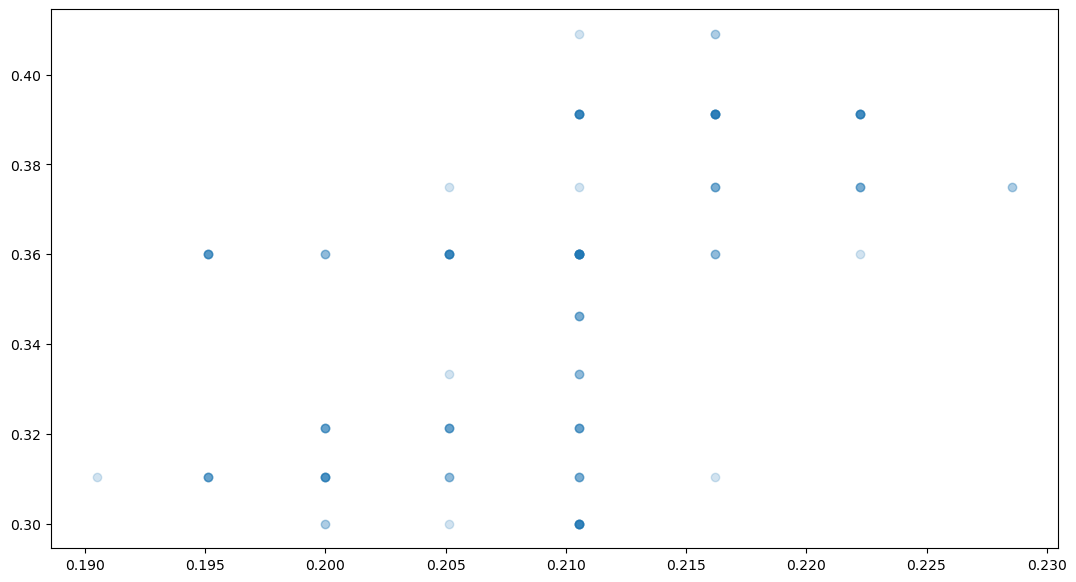

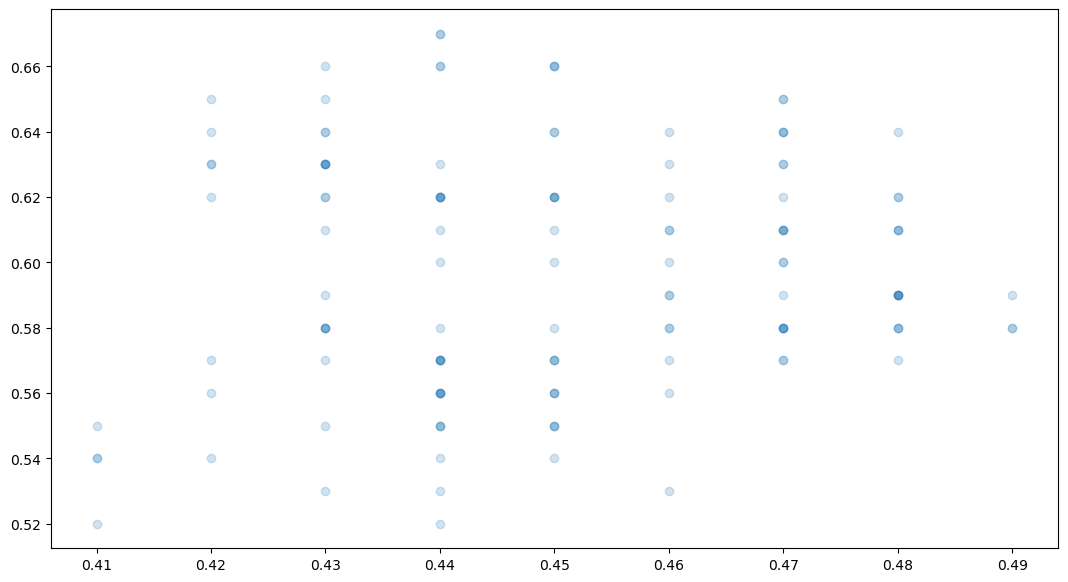

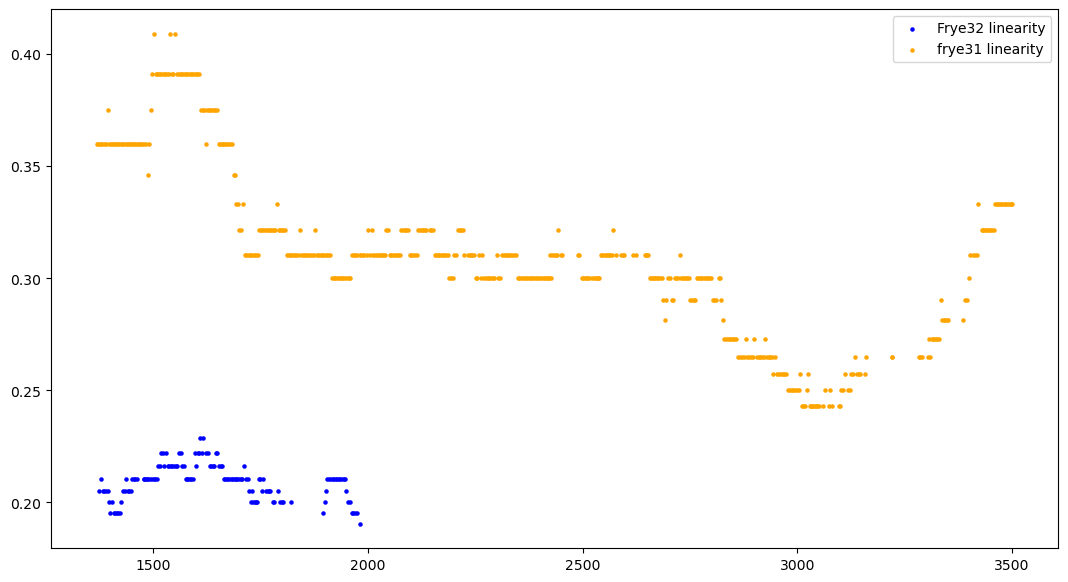

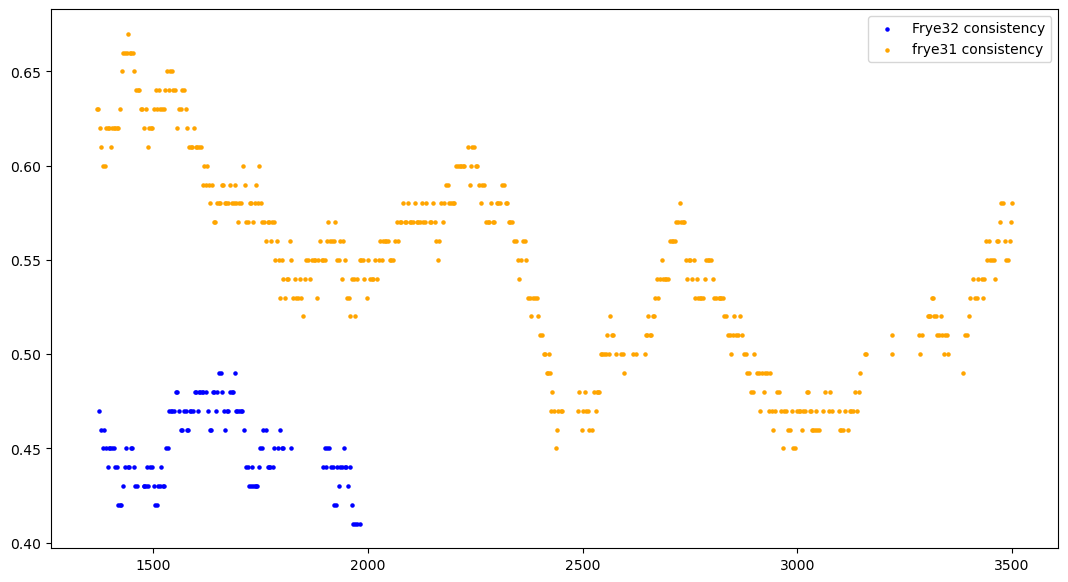

working on:  06-22-2023
['test_finaldf_BBF8_H2_0_06-22-2023.pickle', 'test_finaldf_BBF8_H2_1_06-22-2023.pickle', 'test_finaldf_GB1_A_0_06-22-2023.pickle', 'test_finaldf_GB1_B_0_06-22-2023.pickle']
1627
LINEARITY VALUES ----------------------
params:  [0.19872924 0.14976643]
tvalues:  [22.87024644  3.14904236]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1987      0.009     22.870      0.000       0.182       0.216
f test:  <F test: F=80113.0946168655, p=0.0, df_denom=467, df_num=2>
CONSISTENCY VALUES ----------------------
params:  [ 0.49059907 -0.22406176]
tvalues:  [36.5803812  -5.70462911]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

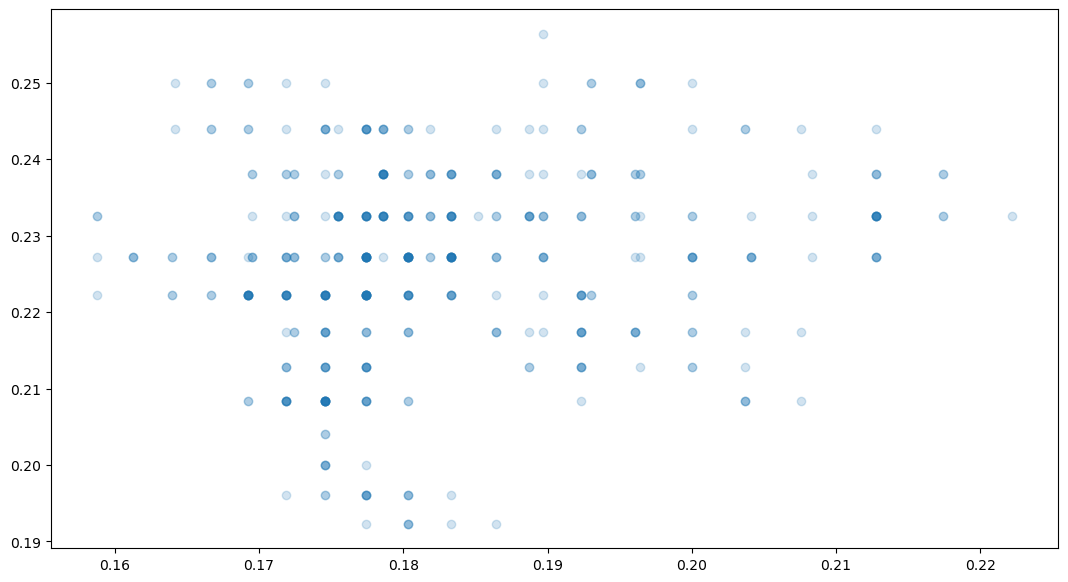

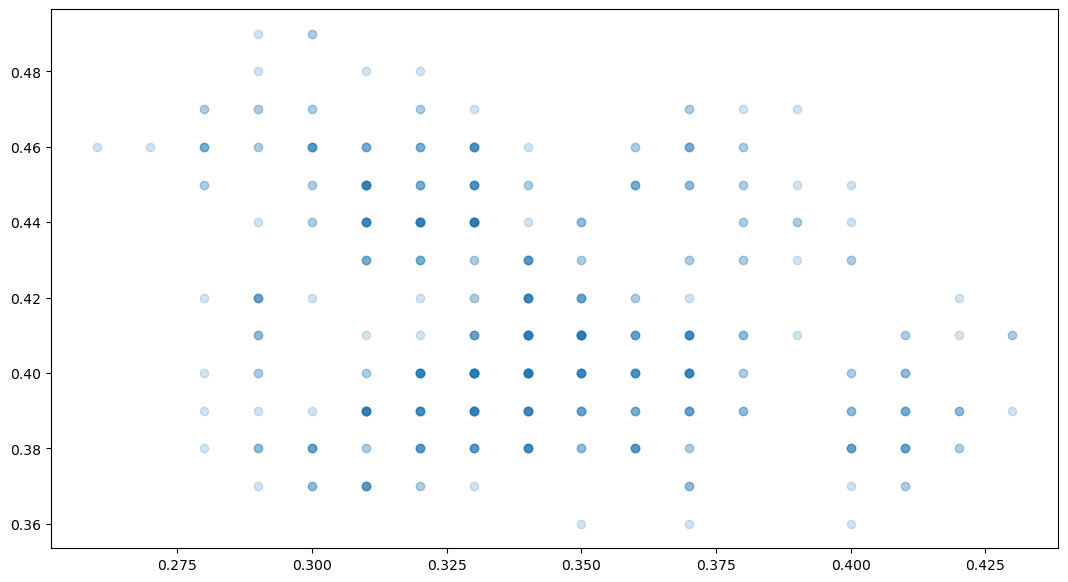

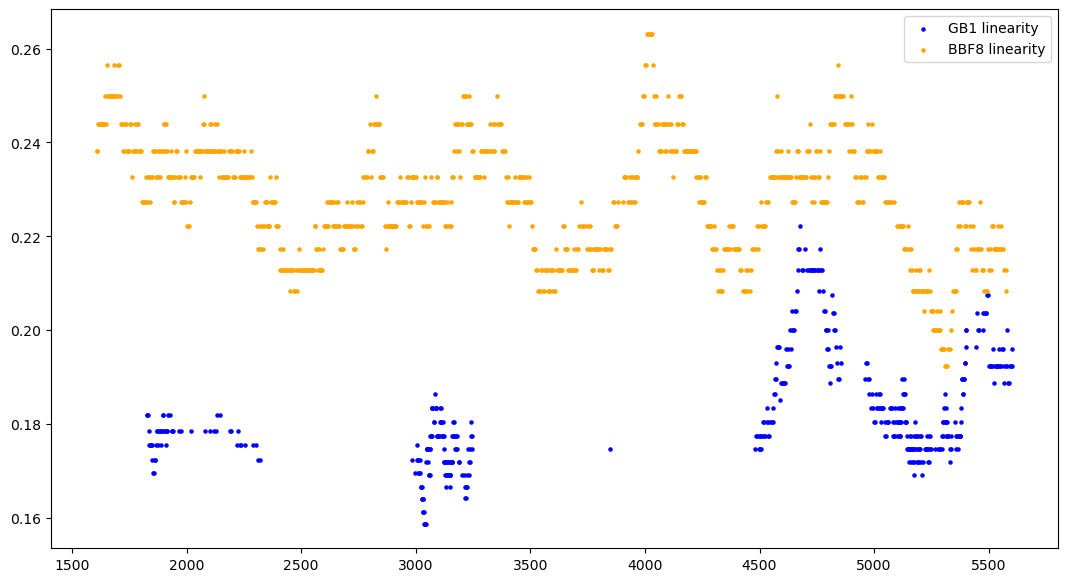

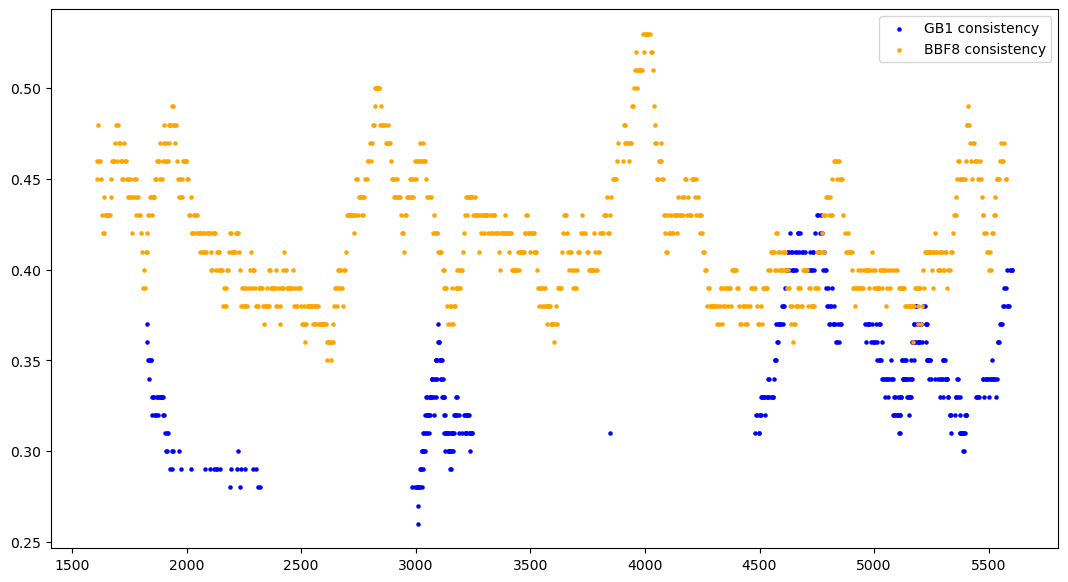

working on:  06-23-2023
['test_finaldf_BBF8_H1_0_06-23-2023.pickle', 'test_finaldf_BBF8_H1_1_06-23-2023.pickle', 'test_finaldf_BBF8_H3_0_06-23-2023.pickle', 'test_finaldf_BBF9_H6_0_06-23-2023.pickle', 'test_finaldf_BBF9_H6_1_06-23-2023.pickle', 'test_finaldf_GB1_B_0_06-23-2023.pickle', 'test_finaldf_GB1_E_0_06-23-2023.pickle']
2057
LINEARITY VALUES ----------------------
params:  [ 0.24709049 -0.08144842]
tvalues:  [20.0313188 -1.4867897]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2471      0.012     20.031      0.000       0.223       0.271
f test:  <F test: F=48020.75988145361, p=0.0, df_denom=475, df_num=2>
CONSISTENCY VALUES ----------------------
params:  [ 0.55382204 -0.37333797]
tvalues:  [31.57679488 -8.167273  ]
                             Test for Constraints         

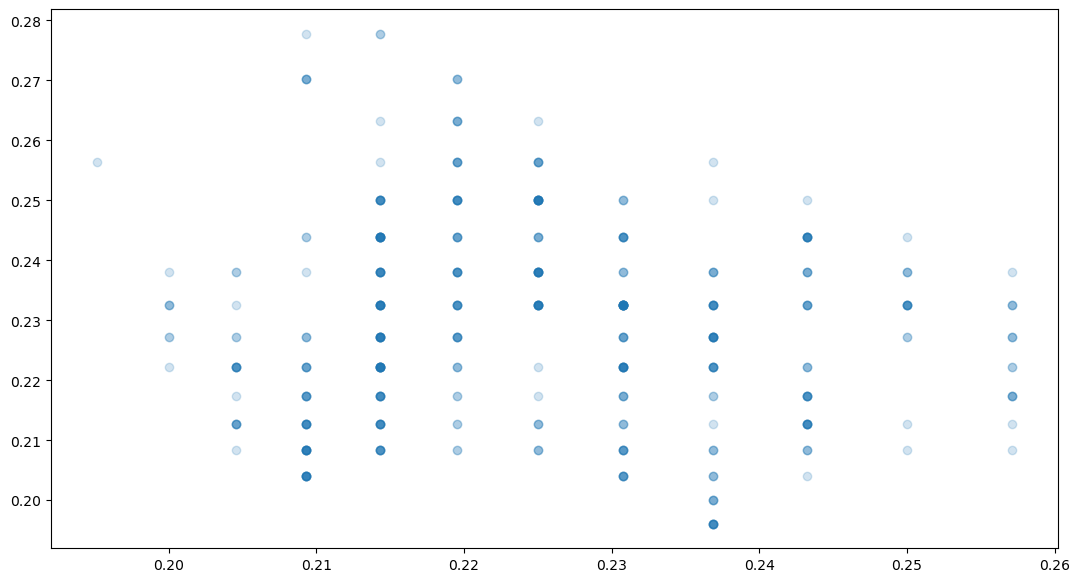

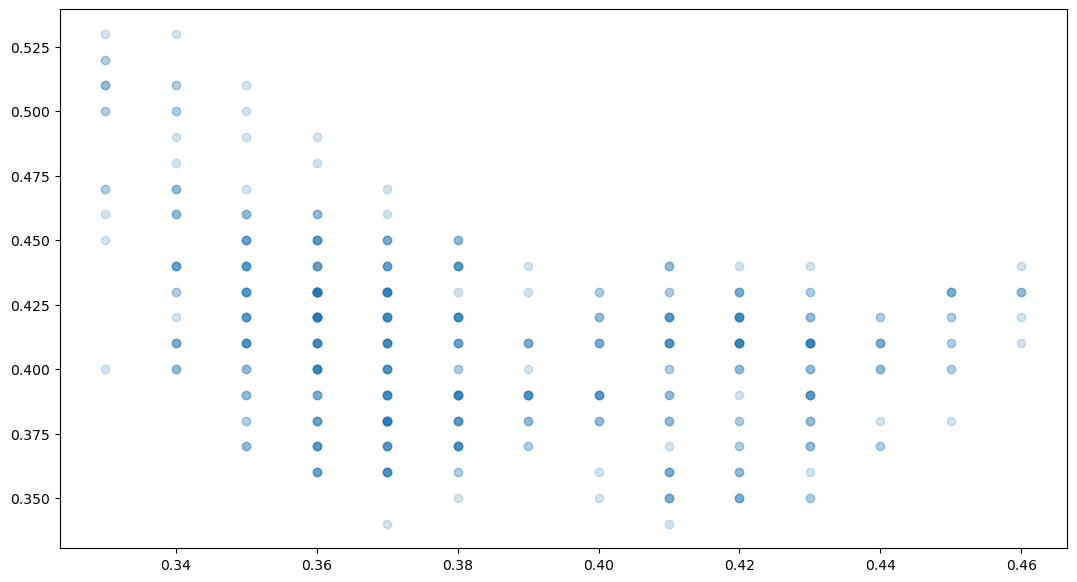

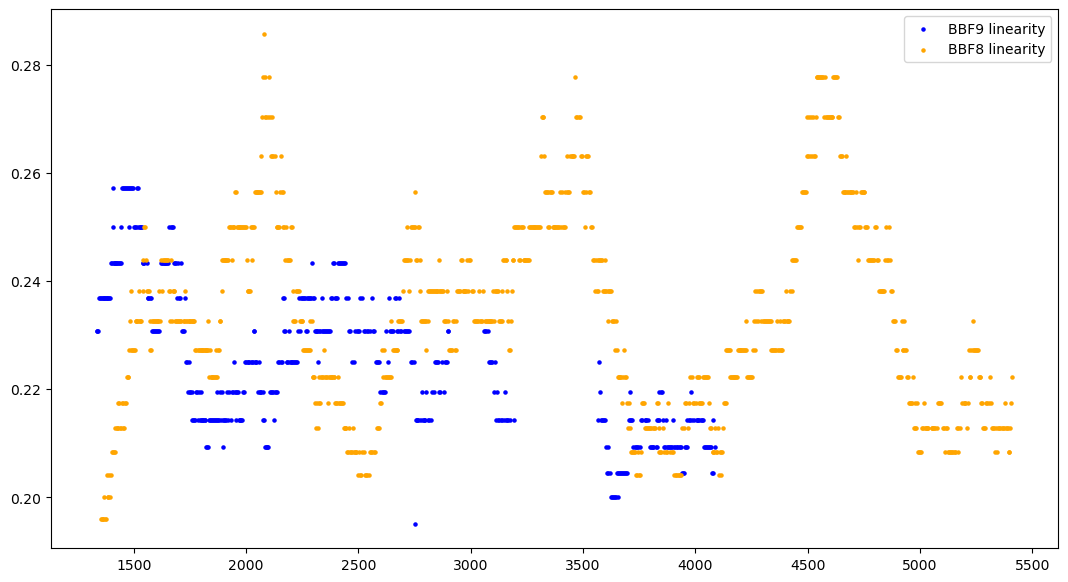

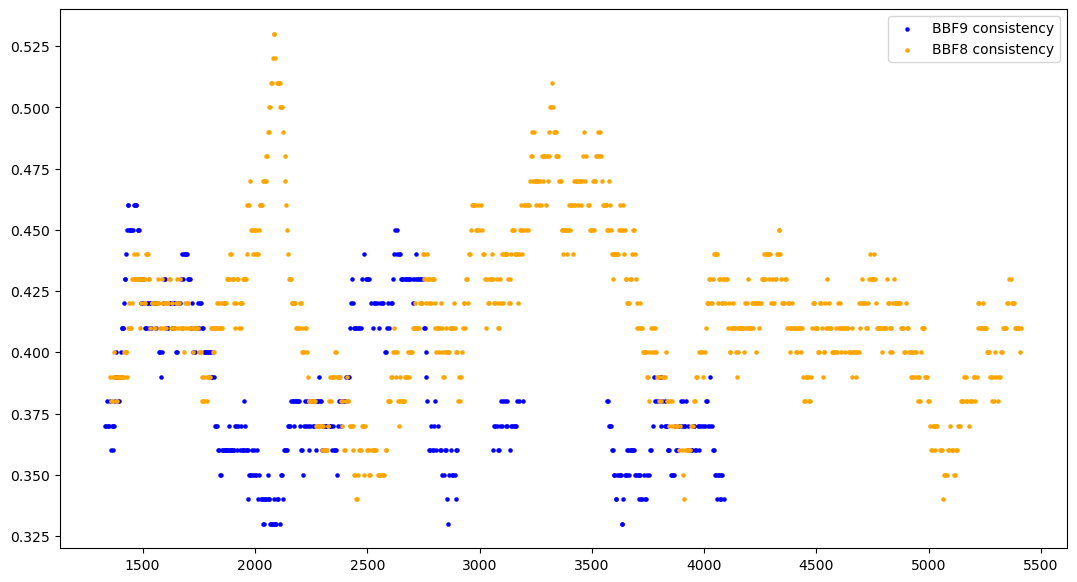

In [164]:
dates = ['04-26-2024', '04-27-2024', '04-22-2024', '04-30-2024', '05-06-2024', '05-07-2024', '06-22-2023','06-23-2023']
start_times = ['0:27:50', '0:38:29', '0:25:59', '0:26:30', '0:24:12', '0:19:34', '0:23:21', '0:19:05']
end_times = ['1:41:40', '1:37:23', '1:30:29', '1:31:35', '1:31:34', '1:31:24', '1:37:37', '1:35:19']

for date_i, date in enumerate(dates):
# date_i = 0
# date = dates[0]
    
    print("working on: ", date)
    df_name_list = []
    name_stub ='test_finaldf_' + '*' + date + '.pickle'
    for file in glob.glob(name_stub):
        df_name_list.append(file)
    df_name_list
    print(df_name_list)
    df_array = []
    for name in df_name_list:
        with open(name, "rb") as input_file:
            current_df = pickle.load(input_file)
        df_array.append(current_df)
    
    big_df = pd.concat(df_array)
    big_df = big_df.sort_values("RecA Time")
    start_time = get_sec(start_times[date_i])
    end_time = get_sec(end_times[date_i])
    big_df = big_df[big_df["RecA Time"] > start_time]
    big_df = big_df[big_df["RecA Time"] < end_time]
    print(len(big_df))
    # big_df = big_df[big_df["RecA Time"] > 1452]
    # big_df = big_df[big_df["RecA Time"] < 5494]
    # print(len(big_df))
    # big_df[90:100]
    
    birds = big_df["BirdID"].unique()
    bird1 = birds[0]
    bird2 = birds[1]
    
    
    times1 = big_df[big_df["BirdID"] == bird1]['RecA Time'].to_numpy()
    types1 = big_df[big_df["BirdID"] == bird1]['ID'].to_numpy()
    times2 = big_df[big_df["BirdID"] == bird2]['RecA Time'].to_numpy()
    types2 = big_df[big_df["BirdID"] == bird2]['ID'].to_numpy()
    
    lins1, lin_times1 = get_rolling_linearity(types1, times1, 100)
    cons1, con_times1 = get_rolling_consistency(types1, times1, 100)
    lins2, lin_times2 = get_rolling_linearity(types2, times2, 100)
    cons2, con_times2 = get_rolling_consistency(types2, times2, 100)
    
    
    closest_birds2_indexes = find_index_of_closest_time(lin_times1, lin_times2)
    paired_bird2_lin_values = []
    for ind in closest_birds2_indexes:
        if isinstance(ind, int):
            paired_bird2_lin_values.append(lins2[ind])
        else:
            paired_bird2_lin_values.append(np.nan)
    
    paired_bird2_con_values = []
    for ind in closest_birds2_indexes:
        if isinstance(ind, int): 
            paired_bird2_con_values.append(cons2[ind])
        else:
            paired_bird2_con_values.append(np.nan)

    # linear regrssion of linearity
    print("LINEARITY VALUES ----------------------")
    x = []
    y = []
    for i, val in enumerate(lins1):
        if np.isnan(paired_bird2_lin_values[i]):
            continue
        else:
            x.append(val)
            y.append(paired_bird2_lin_values[i])

    x = np.array(x)
    y = np.array(y)
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    print("params: ", results.params)
    print("tvalues: ", results.tvalues)
    print(results.t_test([1, 0]))
    print("f test: ", results.f_test(np.identity(2)))

    print("CONSISTENCY VALUES ----------------------")
    x = []
    y = []
    for i, val in enumerate(cons1):
        if np.isnan(paired_bird2_con_values[i]):
            continue
        else:
            x.append(val)
            y.append(paired_bird2_con_values[i])

    x = np.array(x)
    y = np.array(y)
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    print("params: ", results.params)
    print("tvalues: ", results.tvalues)
    print(results.t_test([1, 0]))
    print("f test: ", results.f_test(np.identity(2)))

    print("STEREOTYPY VALUES ----------------------")
    x = []
    y = []
    for i, val in enumerate(cons1):
        if np.isnan(paired_bird2_con_values[i]):
            continue
        else:
            x.append(np.mean([val, lins1[i]]))
            y.append(np.mean([paired_bird2_con_values[i], paired_bird2_lin_values[i]]))

    x = np.array(x)
    y = np.array(y)
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    print("params: ", results.params)
    print("tvalues: ", results.tvalues)
    print(results.t_test([1, 0]))
    print("f test: ", results.f_test(np.identity(2)))
    
    fig = plt.figure(figsize=(13,7))
    #ax = fig.add_subplot(111)
    plt.scatter(lins1, paired_bird2_lin_values, alpha=0.2)
    plt.show()
    plt.close()
    
    fig = plt.figure(figsize=(13,7))
    plt.scatter(cons1, paired_bird2_con_values, alpha=0.2)
    plt.show()
    plt.close()
    
    fig = plt.figure(figsize=(13,7))
    plt.scatter(lin_times1, lins1, label=bird1 + " linearity", color='blue', s=5)
    plt.scatter(lin_times2, lins2, label=bird2 + " linearity", color='orange', s=5)
    plt.legend([bird1 + ' linearity', bird2 + ' linearity',], loc="upper right")
    plt.show()
    plt.close()
    
    fig = plt.figure(figsize=(13,7))
    plt.scatter(con_times1, cons1, label=bird1 + " consistency", color='blue', s=5)
    plt.scatter(con_times2, cons2, label=bird2 + " consistency", color='orange', s=5)
    plt.legend([bird1 + ' consistency', bird2 + ' consistency',], loc="upper right")
    plt.show()
    plt.close()

In [39]:

                

times1 = [-10, -9, -5, 1, 3, 4, 5, 6, 7.2, 11.5, 20]
times2 = [3.5, 5, 6.2, 8]

times1_closest = find_index_of_closest_time(times1, times2)
print(times1_closest)
print(times1)
print(times2)
for i, time in enumerate(times1):
    if isinstance(times1_closest[i], int):
        print(f"closest to {time} is {times2[times1_closest[i]]}")
    else:
        print(f"{time} has no closest.")

[nan, nan, 0, 0, 0, 0, 1, 2, 3, 3, nan]
[-10, -9, -5, 1, 3, 4, 5, 6, 7.2, 11.5, 20]
[3.5, 5, 6.2, 8]
-10 has no closest.
-9 has no closest.
closest to -5 is 3.5
closest to 1 is 3.5
closest to 3 is 3.5
closest to 4 is 3.5
closest to 5 is 5
closest to 6 is 6.2
closest to 7.2 is 8
closest to 11.5 is 8
20 has no closest.


In [72]:
results.params

array([ 0.55382204, -0.37333797])

In [469]:
arr1 = [0, 1, 2, 3, np.nan, 4, 5, 6, 7, 8, 9]


rolled_arr = rolling_backward_mean(arr1, 9)
rolled_arr

[3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4.5, 5.5]

In [6]:
ultimate_names

['..\\LC-2023\\Jul7-Peter1-Peter2\\Ultimate_df_07-07-2023.pickle',
 '..\\LC-2023\\Jun11-Cham1\\Ultimate_df_06-11-2023.pickle',
 '..\\LC-2023\\Jun22-BBF\\Ultimate_df_06-22-2023.pickle',
 '..\\LC-2023\\Jun23_BBF8-BBF9\\Ultimate_df_06-23-2023.pickle',
 '..\\LC-2023\\Jun9-Chick2\\Ultimate_df_06-09-2023.pickle',
 '..\\LC-2024\\apr22_BBF2_BBF3\\Ultimate_df_04-22-2024.pickle',
 '..\\LC-2024\\apr26_frye1_frye3\\Ultimate_df_04-26-2024.pickle',
 '..\\LC-2024\\apr27_frye3_frye4\\Ultimate_df_04-27-2024.pickle',
 '..\\LC-2024\\apr30_power1_power2\\Ultimate_df_04-30-2024.pickle',
 '..\\LC-2024\\may6_frye31_frye32\\Ultimate_df_05-06-2024.pickle',
 '..\\LC-2024\\may7_frye31_frye32\\Ultimate_df_05-07-2024.pickle']

In [14]:
#COMPARING SONG RATE FROM SOLO TO COUNTERSINGING

bbf_df = big_dfs[5].copy()
bbf_df

BirdID    RecA Time RecID   OGRec Time              OG Location  \
0      BBF3   974.134332    H6   856.117577                    [nan]   
1      BBF3   977.428317    H6   859.409035                    [nan]   
2      BBF3   981.017755    H6   862.995718                      NaN   
3      BBF3   983.852845    H6   865.828633                    [nan]   
4      BBF3   988.114909    H6   870.087427                    [nan]   
...     ...          ...   ...          ...                      ...   
1573   BBF2  5536.091689    H2  1826.959733   [53.75, 38.75, 0.9375]   
1574   BBF2  5542.342609    H2  1833.205863    [52.5, 40.0, 11.4375]   
1575   BBF2  5547.338698    H2  1838.198123  [53.75, 41.25, 14.0625]   
1576   BBF2  5553.008679    H2  1843.863758      [52.5, 40.0, 14.25]   
1577   BBF2  5558.330094    H2  1849.181095   [53.75, 40.0, 11.4375]   

                Good Location  \
0                       [nan]   
1                       [nan]   
2                         NaN   
3                       [nan]   
4                       [nan]   
...                       ...   
1573   [53.75, 38.75, 0.9375]   
1574    [52.5, 40.0, 11.4375]   
1575  [53.75, 41.25, 14.0625]   
1576      [52.5, 40.0, 14.25]   
1577   [53.75, 40.0, 11.4375]   

                                           Av Location  Had OG  Leashed  \
0                                                  NaN       0        0   
1                                                  NaN       0        0   
2                                                  NaN       0        0   
3                                                  NaN       0        0   
4                                                  NaN       0        0   
...                                                ...     ...      ...   
1573  [52.916666666666664, 39.166666666666664, 4.4375]       1        0   
1574                [53.333333333333336, 40.0, 8.8125]       1        0   
1575   [52.916666666666664, 40.416666666666664, 13.25]       1        0   
1576   [53.333333333333336, 40.416666666666664, 13.25]       1        0   
1577                          [53.125, 40.0, 12.84375]       1        0   

      Bifabs  ...  dist to BBF3 dist btw BBF3 and BBF2       tsl  Next  \
0          0  ...           NaN                    NaN       NaN     F   
1          0  ...           NaN                    NaN  3.293985     K   
2          0  ...           NaN                    NaN  3.589438     G   
3          0  ...           NaN                    NaN  2.835090     B   
4          0  ...           NaN                    NaN  4.262065     J   
...      ...  ...           ...                    ...       ...   ...   
1573       0  ...           NaN                    NaN  3.369455     G   
1574       0  ...           NaN                    NaN  6.250921     A   
1575       0  ...           NaN                    NaN  4.996089     D   
1576       0  ...           NaN                    NaN  5.669980     B   
1577       0  ...           NaN                    NaN  5.321416  None   

      Freq Transition  Potential Match Type  Freq Match  \
0                 nan                   nan         NaN   
1                 nan                   nan         NaN   
2                 nan                   nan         NaN   
3                 nan                   nan         NaN   
4                 nan                   nan         NaN   
...               ...                   ...         ...   
1573              nan                   nan         NaN   
1574              nan                   nan         NaN   
1575              nan                   nan         NaN   
1576              nan                   nan         NaN   
1577              nan                   nan         NaN   

      BBF3 dist to BBF2 center  BBF2 dist to BBF3 center  Rolling Freq Matches  
0                          NaN                       NaN                   NaN  
1                          NaN                       NaN                   NaN  
2

In [17]:
def add_cs(df, bird):
    birds = df['BirdID'].unique()
    last_other_bird_index = 0
    for i, row in df.iterrows():
        if row['BirdID'] == bird:
            if row['RecA Time'] - df.loc[last_other_bird_index, 'RecA Time'] < 10:
                df.loc[i, 'countersinging'] = 'cs'
            else:
                df.loc[i, 'countersinging'] = 'solo'
        else:
            last_other_bird_index = i
    return df

#bbf_df = add_cs(bbf_df, 'BBF2')
#bbf_df[150:200][['BirdID', 'RecA Time', 'tsl', 'countersinging']]

In [43]:
def compare_cs_to_solo_sr(df, bird):
    bird_df = df[df['BirdID'] == bird]
    print("length before filtering nulls: ", len(bird_df))
    bird_df = bird_df[bird_df['countersinging'].notnull()]
    bird_df = bird_df[bird_df['tsl'].notnull()]
    print("length after filtering nulls: ", len(bird_df))
    cs_tsls = bird_df[bird_df['countersinging'] == 'cs']['tsl'].to_numpy()
    solo_tsls = bird_df[bird_df['countersinging'] == 'solo']['tsl'].to_numpy()
    plt.hist(cs_tsls)
    plt.title(f'{bird} countersinging times since last song')
    plt.show()
    plt.close()
    plt.hist(solo_tsls)
    plt.title(f'{bird} solosinging times since last song')
    plt.show()
    plt.close()
    print('solo mean: ', np.mean(solo_tsls), 'cs mean: ', np.mean(cs_tsls))
    print('solo n: ', len(solo_tsls), 'cs n: ', len(cs_tsls))
    results = stats.ttest_ind(cs_tsls, solo_tsls)
    print(results)
    return solo_tsls, cs_tsls, results.pvalue

#solo_tsls, cs_tsls = compare_cs_to_solo_sr(bbf_df, 'BBF2')


length before filtering nulls:  804
length after filtering nulls:  794


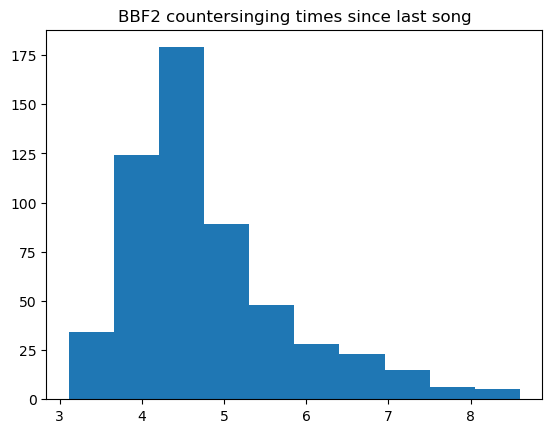

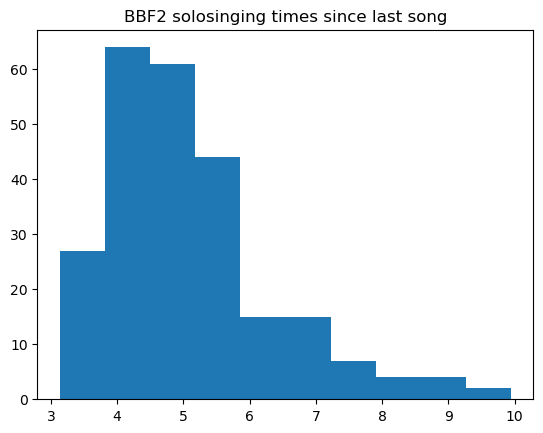

solo mean:  5.09196123875237 cs mean:  4.796566074770949
solo n:  243 cs n:  551
TtestResult(statistic=-3.5269671080688347, pvalue=0.0004445349828043729, df=792.0)
length before filtering nulls:  975
length after filtering nulls:  961


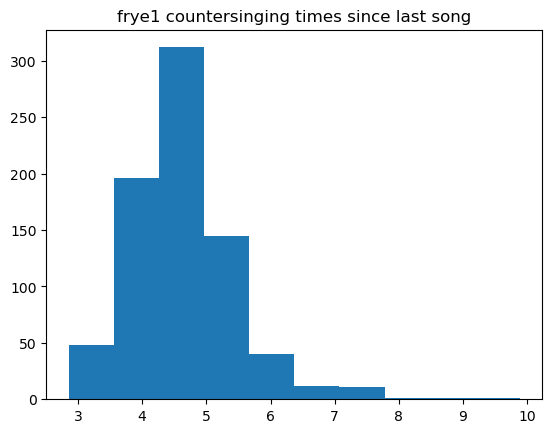

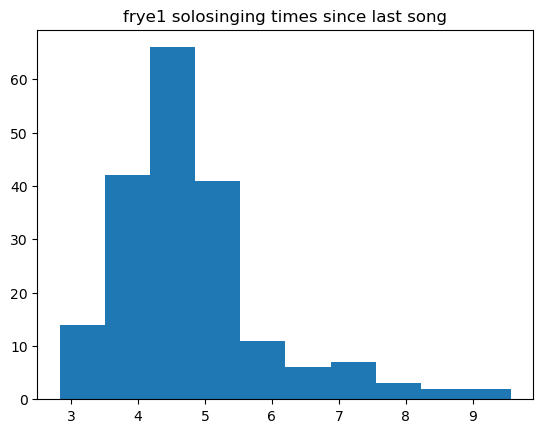

solo mean:  4.78930333265811 cs mean:  4.647671652459524
solo n:  194 cs n:  767
TtestResult(statistic=-2.0130440531256775, pvalue=0.044389044131674, df=959.0)
length before filtering nulls:  871
length after filtering nulls:  836


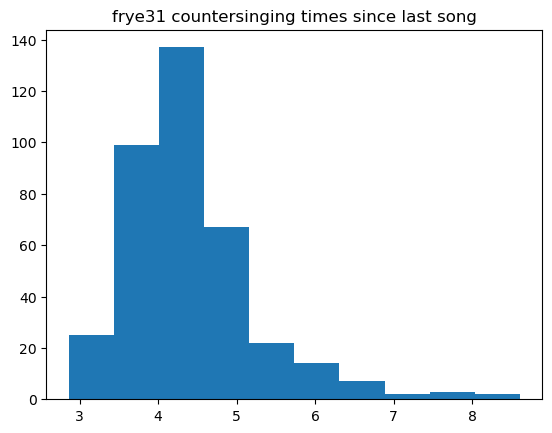

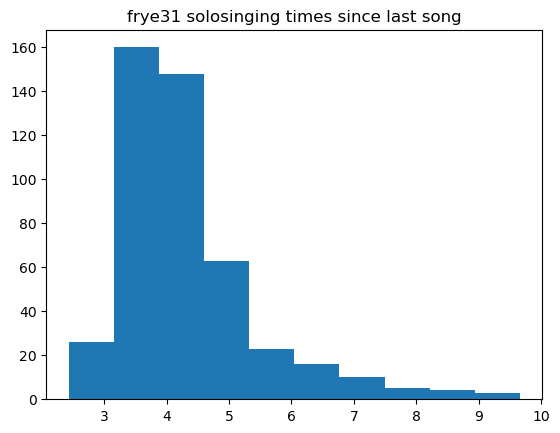

solo mean:  4.337714208817342 cs mean:  4.410284805013424
solo n:  458 cs n:  378
TtestResult(statistic=1.037558892874556, pvalue=0.2997761868136605, df=834.0)
length before filtering nulls:  434
length after filtering nulls:  426


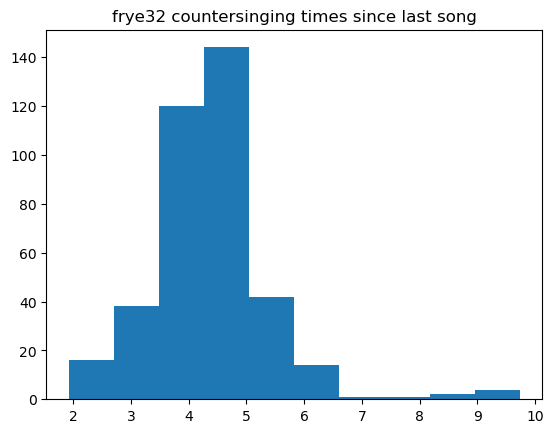

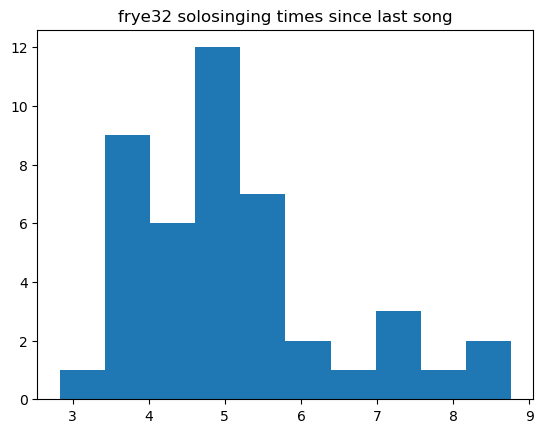

solo mean:  5.108342319609764 cs mean:  4.3898110185502865
solo n:  44 cs n:  382
TtestResult(statistic=-4.234764928935225, pvalue=2.8077596898613607e-05, df=424.0)
length before filtering nulls:  722
length after filtering nulls:  706


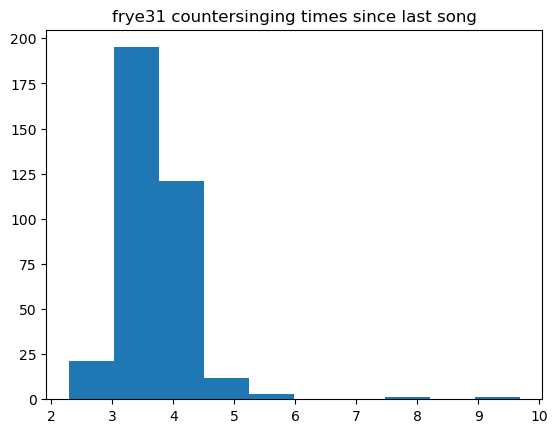

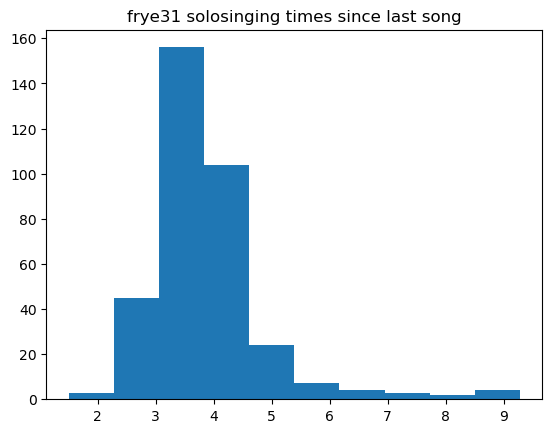

solo mean:  3.8802103028694503 cs mean:  3.7196751525725844
solo n:  352 cs n:  354
TtestResult(statistic=-2.56920654997032, pvalue=0.010397988388435258, df=704.0)
length before filtering nulls:  1024
length after filtering nulls:  1015


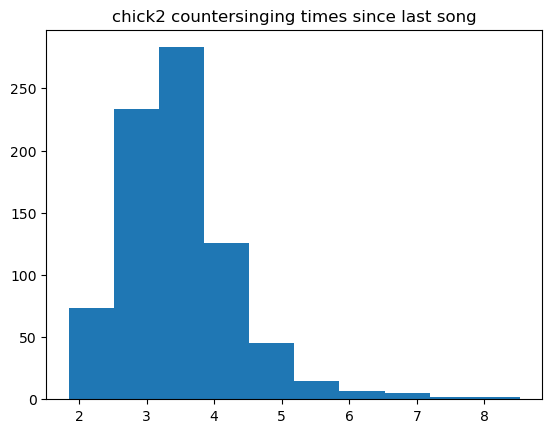

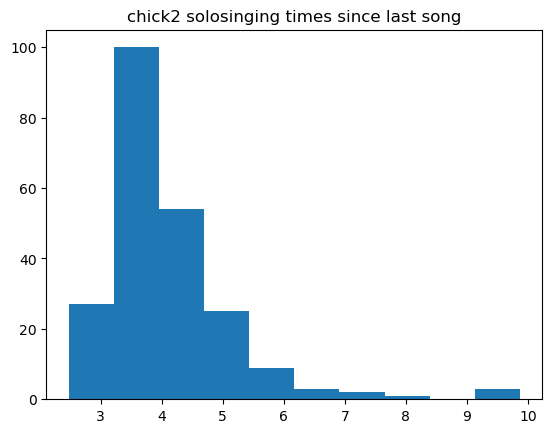

solo mean:  4.066913543386288 cs mean:  3.484576720655114
solo n:  224 cs n:  791
TtestResult(statistic=-8.416992322926115, pvalue=1.30494529071706e-16, df=1013.0)
length before filtering nulls:  1086
length after filtering nulls:  1081


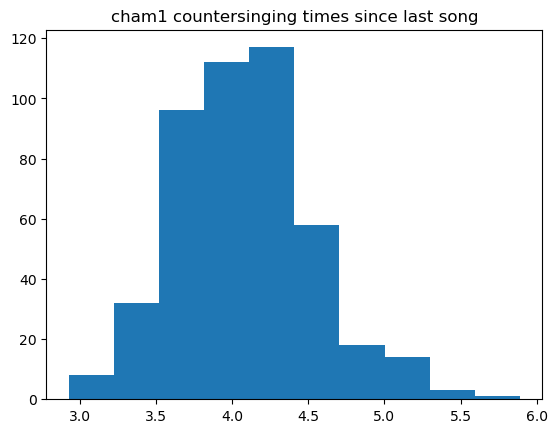

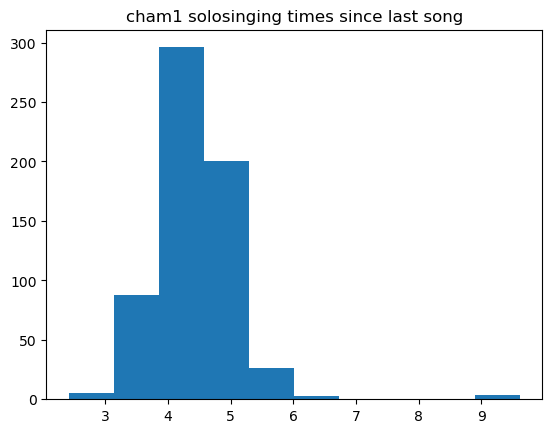

solo mean:  4.441073874885253 cs mean:  4.076453683145437
solo n:  622 cs n:  459
TtestResult(statistic=-10.099743152739725, pvalue=5.601296993044314e-23, df=1079.0)
length before filtering nulls:  1312
length after filtering nulls:  1303


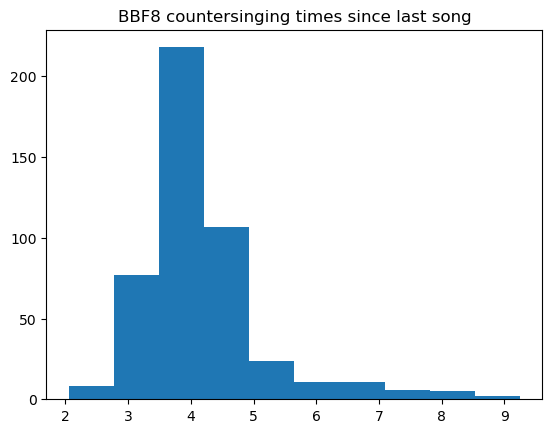

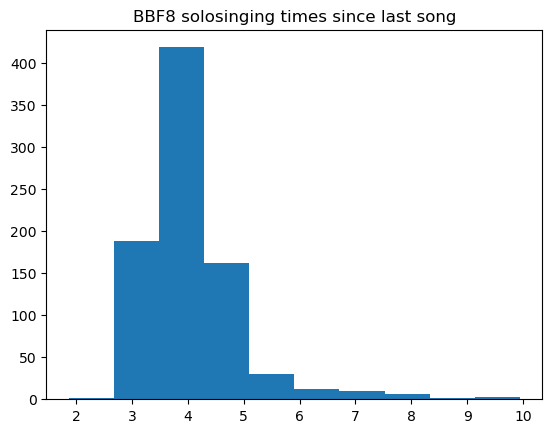

solo mean:  4.054347275820207 cs mean:  4.182708245063527
solo n:  834 cs n:  469
TtestResult(statistic=2.3821323721004295, pvalue=0.017355724256631448, df=1301.0)
length before filtering nulls:  1290
length after filtering nulls:  1281


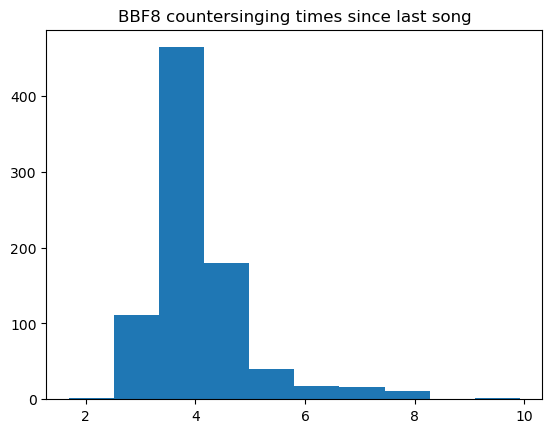

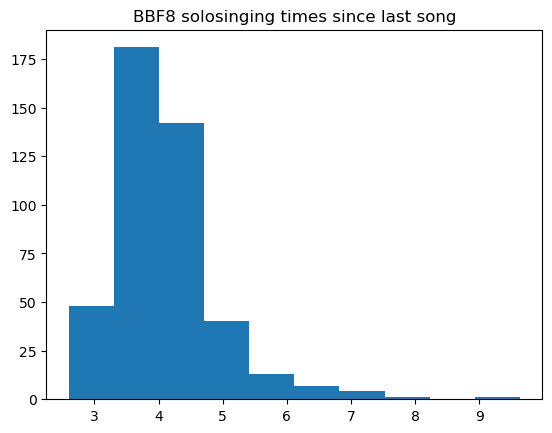

solo mean:  4.108441948294268 cs mean:  4.081944334223831
solo n:  437 cs n:  844
TtestResult(statistic=-0.5002969654264816, pvalue=0.6169520595093911, df=1279.0)
243 551
194 767
458 378
44 382
352 354
224 791
622 459
834 469
437 844


In [44]:
birds = ['BBF2', 'frye1', 'frye31', 'frye32', 'frye31', 'chick2', 'cham1', 'BBF8', 'BBF8']
df_indexes = [5, 6, 9, 9, 10, 4, 1, 2, 3]

tsl_ps = []
all_solo_tsls = []
all_cs_tsls = []
for i, bird in enumerate(birds):
    df = big_dfs[df_indexes[i]].copy()
    df = add_cs(df, bird)
    solo_tsls, cs_tsls, pval = compare_cs_to_solo_sr(df, bird)
    all_solo_tsls.append(solo_tsls)
    all_cs_tsls.append(cs_tsls)
    tsl_ps.append(pval)
for item in tsls:
    print(len(item[0]), len(item[1]))

In [23]:
for i, name in enumerate(ultimate_names):
    print(i, name)

0 ..\LC-2023\Jul7-Peter1-Peter2\Ultimate_df_07-07-2023.pickle
1 ..\LC-2023\Jun11-Cham1\Ultimate_df_06-11-2023.pickle
2 ..\LC-2023\Jun22-BBF\Ultimate_df_06-22-2023.pickle
3 ..\LC-2023\Jun23_BBF8-BBF9\Ultimate_df_06-23-2023.pickle
4 ..\LC-2023\Jun9-Chick2\Ultimate_df_06-09-2023.pickle
5 ..\LC-2024\apr22_BBF2_BBF3\Ultimate_df_04-22-2024.pickle
6 ..\LC-2024\apr26_frye1_frye3\Ultimate_df_04-26-2024.pickle
7 ..\LC-2024\apr27_frye3_frye4\Ultimate_df_04-27-2024.pickle
8 ..\LC-2024\apr30_power1_power2\Ultimate_df_04-30-2024.pickle
9 ..\LC-2024\may6_frye31_frye32\Ultimate_df_05-06-2024.pickle
10 ..\LC-2024\may7_frye31_frye32\Ultimate_df_05-07-2024.pickle


In [45]:
solo_means = []
cs_means = []
for i, solo in enumerate(all_solo_tsls):
    solo_means.append(np.mean(solo))
    cs_means.append(np.mean(all_cs_tsls[i]))

print(len(solo_means))
print(len(cs_means))
print(len(birds))

9
9
9


In [46]:
sigs = test_bon_holm(tsl_ps, 0.05)
sigs

0.005
0.005555555555555556
0.00625
0.0071428571428571435
0.008333333333333333
0.01
0.0125
0.016666666666666666
0.025


[True, False, False, True, False, True, True, False, False]

In [37]:
tsl_results_dict = {'name': birds, 'solo': solo_means, 'cs': cs_means}
tsl_results_df = pd.DataFrame.from_dict(tsl_results_dict)

In [38]:
tsl_results_df

name      solo        cs
0    BBF2  5.091961  4.796566
1   frye1  4.789303  4.647672
2  frye31  4.337714  4.410285
3  frye32  5.108342  4.389811
4  frye31  3.880210  3.719675
5  chick2  4.066914  3.484577
6   cham1  4.441074  4.076454
7    BBF8  4.054347  4.182708
8    BBF8  4.108442  4.081944

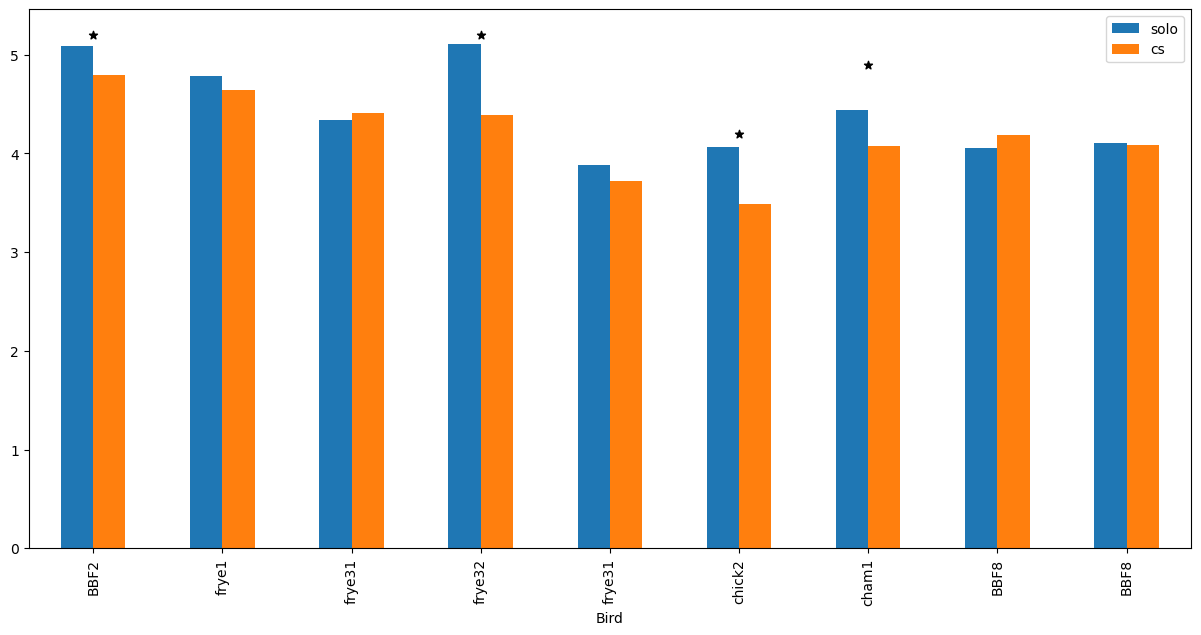

In [49]:
ax = tsl_results_df.plot.bar(figsize=(15,7))
# for i in range(len(tsl_results_df)):
#     if i % 2 == 0 and i > 0:
#         plt.axvline(x = i - .5, color = 'green', linestyle='--', alpha=0.5, label = 'cs pairs')
plt.scatter(0, 5.2, marker='*', c='black')
plt.scatter(3, 5.2, marker='*', c='black')
plt.scatter(5, 4.2, marker='*', c='black')
plt.scatter(6, 4.9, marker='*', c='black')
plt.xticks(range(len(tsl_results_df)), birds)
#plt.yscale('symlog')
plt.xlabel('Bird')

plt.show()

In [51]:
for b, bird in enumerate(birds):
    print(b, bird, tsl_ps[b])

0 BBF2 0.0004445349828043729
1 frye1 0.044389044131674
2 frye31 0.2997761868136605
3 frye32 2.8077596898613607e-05
4 frye31 0.010397988388435258
5 chick2 1.30494529071706e-16
6 cham1 5.601296993044314e-23
7 BBF8 0.017355724256631448
8 BBF8 0.6169520595093911


In [52]:
rel_results = stats.ttest_rel(solo_means, cs_means)
rel_results

TtestResult(statistic=2.425376456099737, pvalue=0.041500512422701134, df=8)